<a href="https://colab.research.google.com/github/deniseiras/BAM1D-Microphysics-Emulation/blob/main/BAM1D_Physics_Emulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BAM1D Physics Emulation

<font size="5">**Objetivo:** Emular a Hugh Morrison Microphysics implementada em BAM1D</font>
 


SUBROUTINE RunMicro_HugMorr(  
  
**ncols** - numero de colunas - fixo = 1  
nCols       , &!INTEGER      , INTENT(IN   ) :: nCols

**kmax** - número de níveis = k_max  
kMax        , &!INTEGER      , INTENT(IN   ) :: kMax 

**si** - kmax+1 removido, sem valores/usado
si          , &!REAL(KIND=r8), INTENT(IN   ) :: si(kMax+1)

**sl**  
sl          , &!REAL(KIND=r8), INTENT(IN   ) :: sl(kMax)

**tc** - Temperature(K)  
tc          , &!REAL(KIND=r8), INTENT(INOUT) :: Tc (1:nCols, 1:kMax)

<font size="5">Q's - Mixing ratio </font>

**QV** - water vapor  
QV          , &!REAL(KIND=r8), INTENT(INOUT) :: qv (1:nCols, 1:kMax)

**QC** - cloud water  
QC          , &!REAL(KIND=r8), INTENT(INOUT) :: qc (1:nCols, 1:kMax)

**QR**  - rain water  
QR          , &!REAL(KIND=r8), INTENT(INOUT) :: qr (1:nCols, 1:kMax)

**QI** - cloud ice  
QI          , &!REAL(KIND=r8), INTENT(INOUT) :: qi (1:nCols, 1:kMax)

**QS** - Snow  
QS          , &!REAL(KIND=r8), INTENT(INOUT) :: qs (1:nCols, 1:kMax)

**QG** - Graupel  
QG          , &!REAL(KIND=r8), INTENT(INOUT) :: qg (1:nCols, 1:kMax)

<font size="5">*N's* - number concentration
</font>  

**NI** - cloud ice  
NI          , &!REAL(KIND=r8), INTENT(INOUT) :: ni (1:nCols, 1:kMax)

**NS** - Snow  
NS          , &!REAL(KIND=r8), INTENT(INOUT) :: ns (1:nCols, 1:kMax)

**NR** - Rain    
NR          , &!REAL(KIND=r8), INTENT(INOUT) :: nr (1:nCols, 1:kMax)

**NG** - Graupel  
NG          , &!REAL(KIND=r8), INTENT(INOUT) :: NG (1:nCols, 1:kMax)   

**NC** - Cloud droplet  
NC          , &!REAL(KIND=r8), INTENT(INOUT) :: NC (1:nCols, 1:kMax)   

**TKE** - turbulence kinetic energy (m^2 s-2), NEEDED FOR DROPLET ACTIVATION  
TKE         , &!REAL(KIND=r8), INTENT(IN   ) :: TKE (1:nCols, 1:kMax)   

**KZH** -  heat eddy diffusion coefficient from YSU scheme (M^2 S-1), NEEDED FOR DROPLET ACTIVATION  
KZH         , &!REAL(KIND=r8), INTENT(IN   ) :: KZH (1:nCols, 1:kMax)   

**gps** - Pressão - removida da entrada da RNA - valor fixo  
gps         , &!gps- AIR PRESSURE (PA)

**DT_IN** - model time step (sec) - Removido da entrada da RNA
DT_IN       , &!REAL(KIND=r8), INTENT(IN   ) :: dt_in

**omega**  
omega       , &!REAL(KIND=r8), INTENT(IN   ) :: omega  ! omega (Pa/s)

**EFFCS** - CLOUD DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFCS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFCS (1:nCols, 1:kMax)   

**EFFIS** - ICE DROPLET EFFECTIVE RADIUS OUTPUT TO RADIATION CODE (micron)  
EFFIS       , &!REAL(KIND=r8), INTENT(OUT  ) :: EFFIS (1:nCols, 1:kMax)   

**LSRAIN** - Large scale Rain  
LSRAIN      , &!REAL(KIND=r8), INTENT(OUT) :: LSRAIN(1:nCols)

**LSSNOW** - Large scale Snow  
LSSNOW        )!REAL(KIND=r8), INTENT(OUT) :: LSSNOW(1:nCols)


# Setup do dados

Carregamento dos dados

In [ ]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from sklearn import metrics, preprocessing

%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

import keras
from tensorflow.python.data import Dataset

from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold, train_test_split
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Conv1D, Flatten, MaxPooling1D, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.utils.vis_utils import plot_model
from keras.callbacks import TensorBoard


import csv    

from datetime import datetime
from shutil import copyfile, copytree, rmtree

k_max = 28  # número de níveis utilizado

# % pip install XlsxWriter
# % pip install SkillMetrics
# import skill_metrics as sm


# tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
# pd.options.display.float_format = '{:.1f}'.format
pd.options.display.float_format = '{:f}'.format


# working local
#
# %load_ext tensorboard funciona local ???
# %reload_ext tensorboard ???
# colab_in_drive_root_dir = "/home/denis/_COM_BACKUP/NN_BAM1d/bam1d_data/Colab Notebooks"
# tb_logdir_base = colab_in_drive_root_dir + '/logs'
# data_in_drive_dir = "/media/denis/dados/_COM_BACKUP/NN_BAM1D/bam1d_data/"


# loading from gdrive - COLAB MOUNTS AUTOMATICALLY NOW
#
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
tb_logdir_base = './logs'
colab_in_drive_root_dir = "/content/drive/My Drive/Colab Notebooks/"
data_in_drive_dir = "/content/drive/My Drive/NN_Microphysics/"


Tensorflow version 2.5.0
Mounted at /content/drive


In [ ]:

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_HSR.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}/hug_morr_inputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/hug_morr_outputs_CRD_RRTMG___dt_60.csv".format(data_in_drive_dir), sep=",")


# IOP com menos de 180 falta memória

# original_input_df = pd.read_csv("{}/IOP2014__CRD_RRTMG_dt_360/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}/IOP2014__CRD_RRTMG_dt_360/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_60/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_60/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

# original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_120/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
# original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_120/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

original_input_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_180/hug_morr_inputs.csv".format(data_in_drive_dir), sep=",")
original_output_df = pd.read_csv("{}IOP2014__CRD_RRMTG_dt_180/hug_morr_outputs.csv".format(data_in_drive_dir), sep=",")

## Análise dos dados

### Análise estatística

- Resumo dos valores das variáveis de entrada e saída. Observe que os valores são truncados no Resumo
- Valores do primeiro, centésimo e último passo de tempo
- Níveis verticais do primeiro, centésimo e último passo de tempo

In [ ]:
print("\nAll input summary:")
display.display(original_input_df.describe())
print("\nAll output summary:")
display.display(original_output_df.describe())

print("\nInput First timestep:")
display.display(original_input_df.head(k_max))
print("\nInput 100th timestep:")
display.display(original_input_df.loc[k_max*100:k_max*100+27])
print("\nInput Last timestep:")
display.display(original_input_df.tail(k_max))

print("\nOutput First timestep:")
display.display(original_output_df.head(k_max))
print("\nOutput 100th timestep:")
display.display(original_output_df.loc[k_max*100:k_max*100+27])
print("\nOutput Last timestep:")
display.display(original_output_df.tail(k_max))

# original_output_df.describe().to_csv('/content/drive/My Drive/Colab Notebooks/temp_describe.csv')




All input summary:


k             si  ...            gps          omega
count 4865308.000000 4865308.000000  ... 4865308.000000 4865308.000000
mean       14.500000       0.468551  ...   99000.000000      -0.011695
std         8.077748       0.363561  ...       0.000000       0.079032
min         1.000000       0.003669  ...   99000.000000      -1.076957
25%         7.750000       0.103880  ...   99000.000000      -0.023818
50%        14.500000       0.432240  ...   99000.000000       0.000000
75%        21.250000       0.834470  ...   99000.000000       0.015078
max        28.000000       1.000000  ...   99000.000000       0.541837

[8 rows x 20 columns]


All output summary:


k             Tc  ...         LSRAIN         LSSNOW
count 4865308.000000 4865308.000000  ... 4865308.000000 4865308.000000
mean       14.500000     237.808947  ...       0.000001       0.000000
std         8.077748      61.351244  ...       0.000004       0.000000
min         1.000000      63.503048  ...      -0.000000      -0.000000
25%         7.750000     202.558915  ...       0.000000       0.000000
50%        14.500000     257.522230  ...       0.000000       0.000000
75%        21.250000     288.991030  ...       0.000000       0.000000
max        28.000000     308.962369  ...       0.000163       0.000000

[8 rows x 17 columns]


Input First timestep:


k       si  si_kmax_+_1       sl  ...      tke      kzh          gps     omega
0    1 1.000000     0.000000 0.994964  ... 0.000000 0.060765 99000.000000 -0.012614
1    2 0.989934     0.000000 0.981964  ... 0.000000 0.143061 99000.000000 -0.001955
2    3 0.974009     0.000000 0.964137  ... 0.000000 0.100000 99000.000000 -0.028920
3    4 0.954290     0.000000 0.942167  ... 0.000000 0.100000 99000.000000 -0.037237
4    5 0.930081     0.000000 0.915361  ... 0.000000 0.100000 99000.000000 -0.033169
..  ..      ...          ...      ...  ...      ...      ...          ...       ...
23  24 0.042912     0.000000 0.035429  ... 0.000000 0.100000 99000.000000  0.000000
24  25 0.028306     0.000000 0.022285  ... 0.000000 0.100000 99000.000000  0.000000
25  26 0.016629     0.000000 0.011763  ... 0.000000 0.100000 99000.000000  0.000000
26  27 0.007338     0.000000 0.005429  ... 0.000000 0.100000 99000.000000  0.000000
27  28 0.003669     0.000000 0.001523  ... 0.000000 0.100000 99000.000000  0.000000

[28 rows x 20 columns]


Input 100th timestep:


k       si  si_kmax_+_1  ...       kzh          gps     omega
2800   1 1.000000     0.000000  ...  9.711810 99000.000000 -0.001430
2801   2 0.989934     0.000000  ... 15.619333 99000.000000 -0.002425
2802   3 0.974009     0.000000  ... 23.227907 99000.000000 -0.000621
2803   4 0.954290     0.000000  ... 18.964212 99000.000000  0.004144
2804   5 0.930081     0.000000  ...  8.552701 99000.000000  0.010388
...   ..      ...          ...  ...       ...          ...       ...
2823  24 0.042912     0.000000  ...  0.100000 99000.000000  0.000000
2824  25 0.028306     0.000000  ...  0.100000 99000.000000  0.000000
2825  26 0.016629     0.000000  ...  0.100000 99000.000000  0.000000
2826  27 0.007338     0.000000  ...  0.100000 99000.000000  0.000000
2827  28 0.003669     0.000000  ...  0.100000 99000.000000  0.000000

[28 rows x 20 columns]


Input Last timestep:


k       si  si_kmax_+_1  ...        kzh          gps    omega
4865280   1 1.000000     0.000000  ...  11.103186 99000.000000 0.000416
4865281   2 0.989934     0.000000  ...  44.312742 99000.000000 0.004870
4865282   3 0.974009     0.000000  ...   0.100000 99000.000000 0.011449
4865283   4 0.954290     0.000000  ...   0.100000 99000.000000 0.017780
4865284   5 0.930081     0.000000  ...   0.100000 99000.000000 0.022871
...      ..      ...          ...  ...        ...          ...      ...
4865303  24 0.042912     0.000000  ...   0.100000 99000.000000 0.000000
4865304  25 0.028306     0.000000  ... 300.000000 99000.000000 0.000000
4865305  26 0.016629     0.000000  ... 300.000000 99000.000000 0.000000
4865306  27 0.007338     0.000000  ... 300.000000 99000.000000 0.000000
4865307  28 0.003669     0.000000  ... 300.000000 99000.000000 0.000000

[28 rows x 20 columns]


Output First timestep:


k         Tc       qv       qc  ...    EFFCS     EFFIS   LSRAIN   LSSNOW
0    1 300.672944 0.016230 0.000000  ... 1.000000 13.000000 0.000000 0.000000
1    2 300.526379 0.015747 0.000000  ... 1.000000 13.000000 0.000000 0.000000
2    3 299.960846 0.015145 0.000000  ... 1.000000 13.000000 0.000000 0.000000
3    4 298.651604 0.014704 0.000000  ... 1.000000 13.000000 0.000000 0.000000
4    5 296.805719 0.014252 0.000000  ... 1.000000 13.000000 0.000000 0.000000
..  ..        ...      ...      ...  ...      ...       ...      ...      ...
23  24 201.415438 0.000003 0.000000  ... 1.000000 13.000000 0.000000 0.000000
24  25 207.610504 0.000004 0.000000  ... 1.000000 13.000000 0.000000 0.000000
25  26 211.525561 0.000014 0.000000  ... 1.000000 13.000000 0.000000 0.000000
26  27 213.996873 0.000029 0.000000  ... 1.000000 13.000000 0.000000 0.000000
27  28 215.543717 0.000045 0.000000  ... 1.000000 13.000000 0.000000 0.000000

[28 rows x 17 columns]


Output 100th timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
2800   1 302.660529 0.016230 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2801   2 301.403797 0.015747 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2802   3 299.771242 0.015145 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2803   4 297.668440 0.014704 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2804   5 295.257251 0.014252 0.000000  ... 25.000000 25.000000 0.000000 0.000000
...   ..        ...      ...      ...  ...       ...       ...      ...      ...
2823  24 199.198687 0.000003 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2824  25 204.941411 0.000004 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2825  26 206.179766 0.000014 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2826  27 208.382146 0.000029 0.000000  ... 25.000000 25.000000 0.000000 0.000000
2827  28 210.473033 0.000045 0.000000  ... 25.000000 25.000000 0.000000 0.000000

[28 rows x 17 columns]


Output Last timestep:


k         Tc       qv       qc  ...     EFFCS     EFFIS   LSRAIN   LSSNOW
4865280   1 302.667146 0.016231 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865281   2 301.721692 0.015749 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865282   3 300.271134 0.015147 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865283   4 298.397783 0.014706 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865284   5 296.105611 0.014255 0.000000  ... 25.000000 25.000000 0.000003 0.000000
...      ..        ...      ...      ...  ...       ...       ...      ...      ...
4865303  24 180.170778 0.000003 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865304  25 159.627927 0.000004 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865305  26 133.086872 0.000014 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865306  27 110.417731 0.000029 0.000000  ... 25.000000 25.000000 0.000003 0.000000
4865307  28  75.627278 0.000045 0.000000  ... 25.000000 25.000000 0.000003 0.000000

[28 rows x 17 columns]

### Histogramas das variáveis de entrada

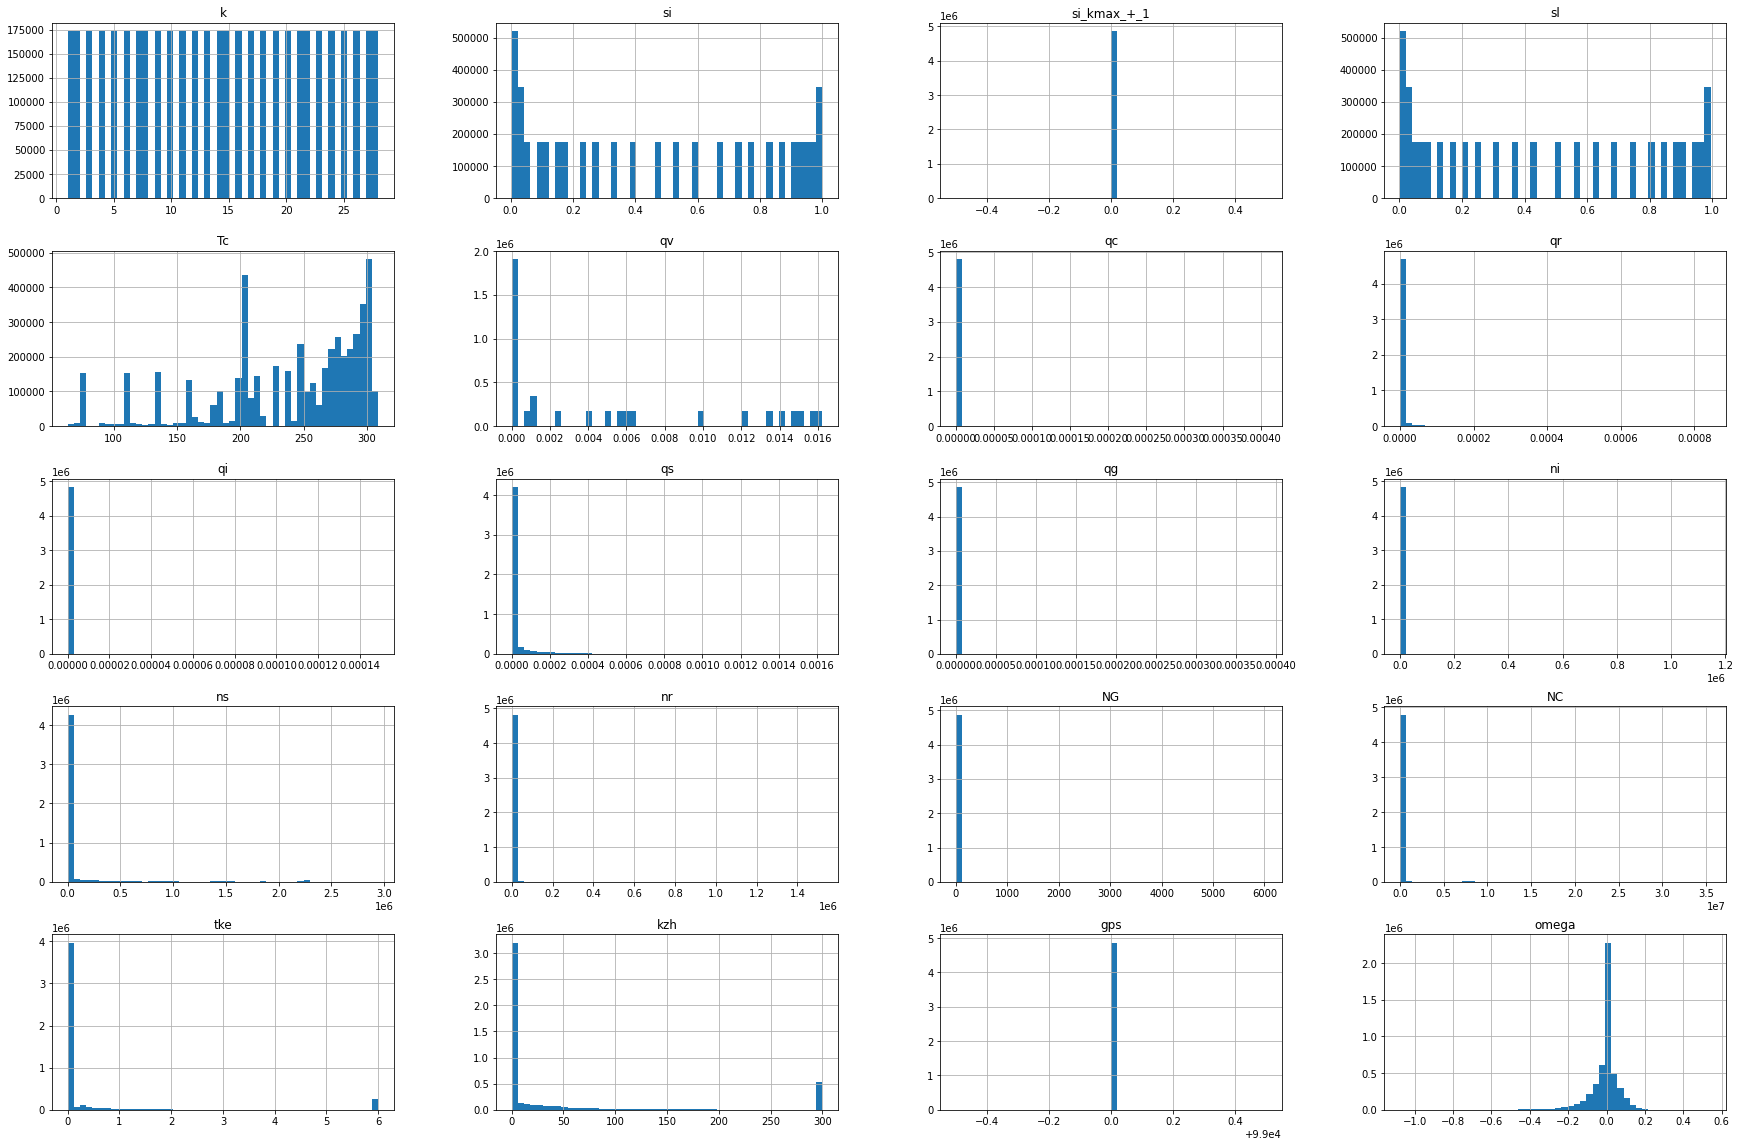

In [ ]:
# Input Histograms

_ = original_input_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)

### Histogramas das variáveis de saída

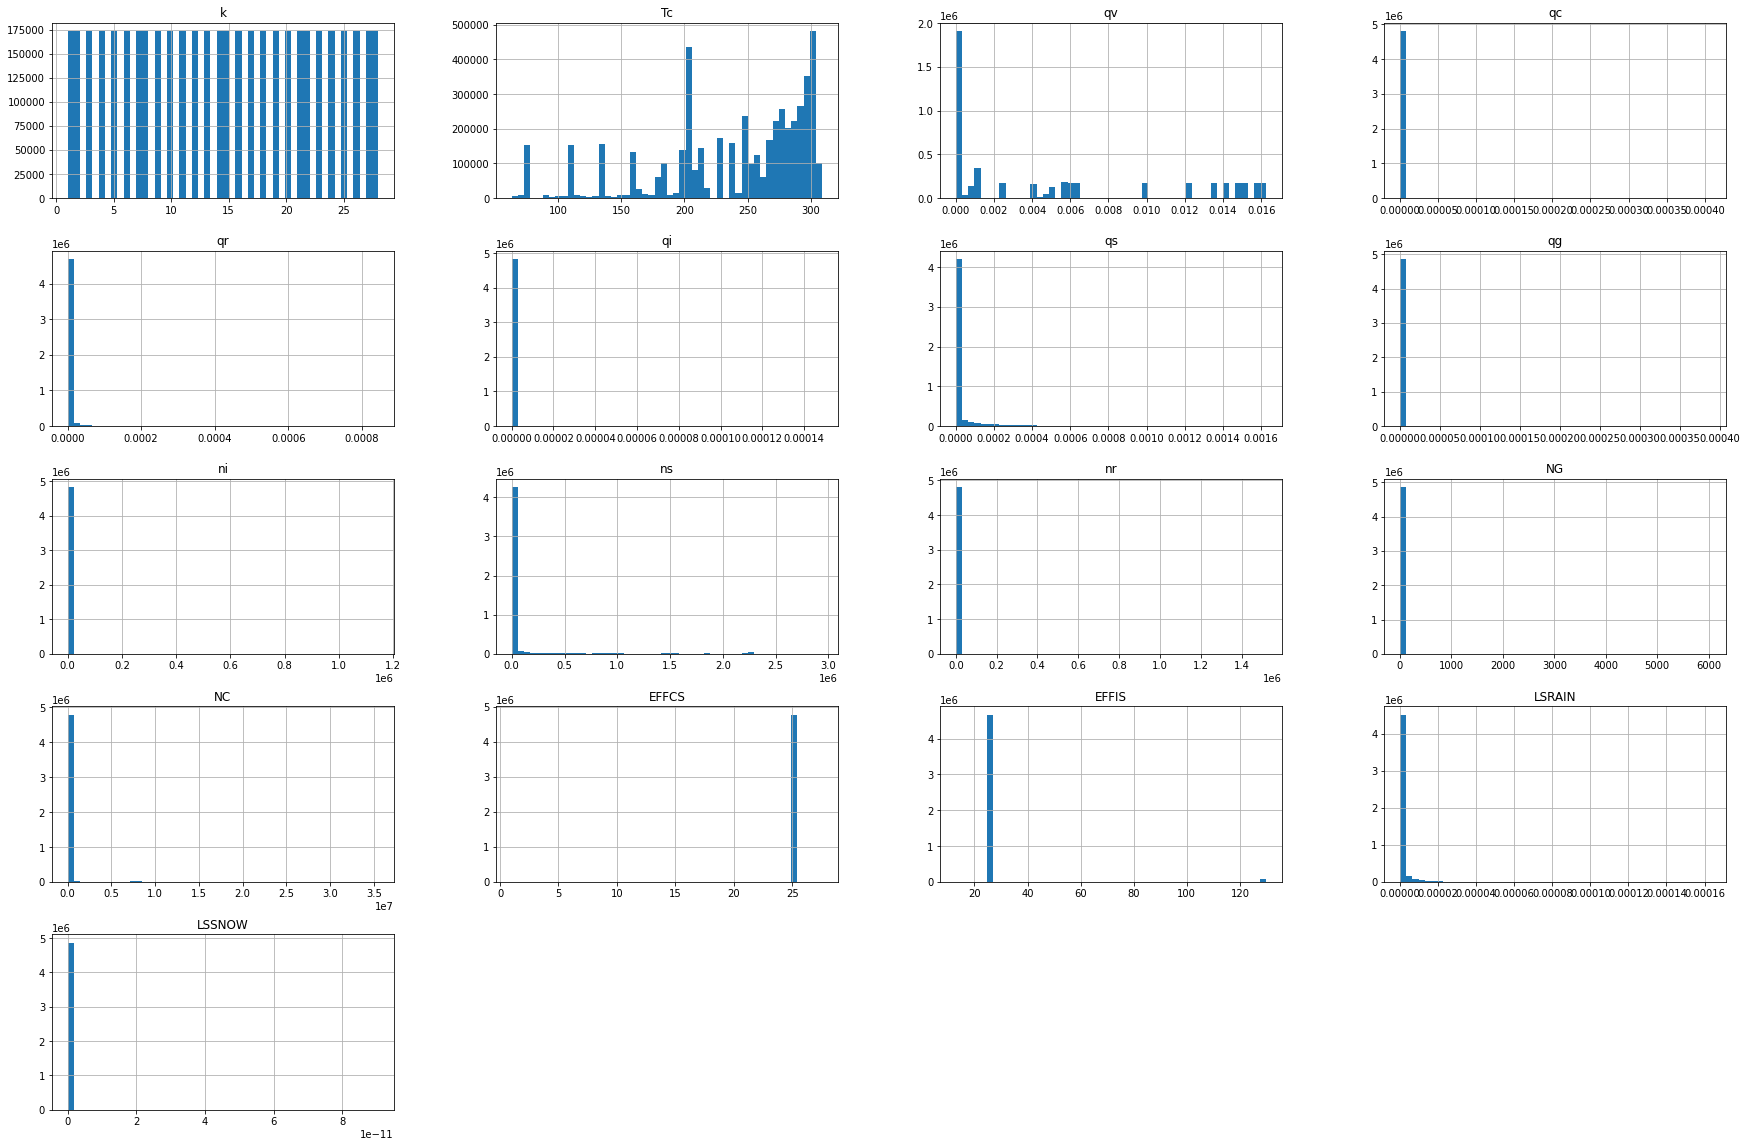

In [ ]:
# Output Histograms

_ = original_output_df.hist(bins=50, figsize=(30, 20), xlabelsize=10)
#_ = validation_examples.hist(bins=20, figsize=(18, 12), xlabelsize=10)

### Bloxpot das variáveis de entrada por níveis

In [ ]:
# Imprime boxplot exibindo se contém valores (True) ou não (False) em cada nível
def bloxplot_levels(df):
  for key in df.columns.tolist():
    if key == "k": continue
    bp = df.boxplot(column=key, by="k", figsize=(25, 6))
    
    x = np.arange(1,29)
    obsgroup = df[[key, 'k']].groupby(by="k")[key]
    noofobs = obsgroup.agg('sum').astype(bool)
    meanobs = obsgroup.agg('mean')

    for tick,label in zip(x,bp.get_xticklabels()):
      bp.text(x[tick-1], meanobs[tick], noofobs[tick], 
        horizontalalignment='center', color='blue' if noofobs[tick] == True else 'red' , weight='bold')
    plt.show()

# old fashion
# print("All normalized examples summary:")
# display.display(normalized_all_examples.describe())

# # Boxplot of variables through levels
# for key in normalized_all_examples.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()

In [ ]:
# Boxplot of variables through levels

# for key in original_input_df.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     original_input_df.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()


### Boxplot das variáveis de saída, por níveis

In [ ]:
# Boxplot of variables through levels

# for key in original_output_df.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     original_output_df.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()

### Gráfico de perfil vertical das variáves de entrada em 3 timesteps

In [ ]:
# Plot the vertical levels of first, 100th and last timestep

# first_timestep_input_df = original_input_df.head(k_max)
# med_timestep_input_df = original_input_df.loc[k_max00:k_max00+27]
# last_timestep_input_df = original_input_df.tail(k_max)

# idx_plot = 1
# plt.figure(figsize=(10, 10))
# for key in last_timestep_input_df.columns.tolist():
#     plt.subplot(7, 3, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.plot(first_timestep_input_df[key], first_timestep_input_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_input_df[key], med_timestep_input_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_input_df[key], last_timestep_input_df[["k"]], label="last timestep")
#     idx_plot += 1
# plt.legend(loc="upper left")
# plt.subplots_adjust(hspace=1, wspace=1)
# plt.show()


# first_timestep_output_df = original_output_df.head(k_max)
# med_timestep_output_df = original_output_df.loc[k_max01:k_max01+27]
# last_timestep_output_df = original_output_df.tail(k_max)

# idx_plot = 1
# for key in last_timestep_output_df.columns.tolist():
#     plt.subplot(4, 6, idx_plot)
#     plt.ylabel("k")
#     plt.xlabel(key)
#     plt.title("Output x Level")
#     plt.plot(first_timestep_output_df[key], first_timestep_output_df[["k"]], label="first timestep")
#     plt.plot(med_timestep_output_df[key], med_timestep_output_df[["k"]], label="100th timestep")
#     plt.plot(last_timestep_output_df[key], last_timestep_output_df[["k"]], label="last timestep")
#     plt.legend()
# plt.show()

## Pré-processando a entrada (exemplos) e saídas (metas)
- Selecionamos as primeiras variáveis de entrada e saída que serão usadas no treinamento e na validação;
- também podemos criar novas variáveis como um composto de variáveis

In [ ]:
def preprocess_features(input_df):
  """Prepares input features input_df

  Args:
    input data frame: A Pandas DataFrame expected to contain data from input data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
# All input variables
# "k", "si", "si_kmax_+_1", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "gps", "omega"    
  selected_features = input_df[
    [
    "k", "si", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"    
    ]]
  processed_features = selected_features.copy()
  return processed_features


def preprocess_targets(output_df):
  """Prepares target features (i.e., labels) from output_df

  Args:
    output_df: A Pandas DataFrame expected to contain data from output data set.
  Returns:
    A DataFrame that contains the target features.
  """
# All output variables
# "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
  output_targets = output_df [
      [
      "k", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"
      ]
  ]
  return output_targets


# execute the pre processing
all_examples = preprocess_features(original_input_df)
all_targets = preprocess_targets(original_output_df)

del original_input_df
del original_output_df


### Funções de normalização

In [ ]:
def linear_scale(serie_or_np_arr, min_val, max_val):
  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
  #   X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  # X_scaled = X_std * (max - min) + min  
  min, max = 0, 1
  y = lambda x:( ( x - min_val) / (max_val - min_val)) * (max - min) + min 
  return y(serie_or_np_arr)
  # Linear normalization (serie or numpy 1D array)
  # -1 e 1

def delinear_scale(serie_or_np_arr, min_val, max_val):
  # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
  #   X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
  # X_scaled = X_std * (max - min) + min  
  min, max = 0, 1
  y = lambda x: min_val + (max_val-min_val)*(x - min) / (max - min)      
  return y(serie_or_np_arr)


def linear_scale_htang(serie_or_np_arr, min_val, max_val):
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x - min_val) / scale) - 1.0
  return y(serie_or_np_arr)

# old bak
# def linear_scale(serie_or_np_arr):
#   min_val = serie_or_np_arr.min()
#   max_val = serie_or_np_arr.max()
#   scale = (max_val - min_val) / 2.0
#   y = lambda x:((x - min_val) / scale) - 1.0
#   return y(serie_or_np_arr), min_val, max_val


# Linear denormalization (serie or numpy 1D array)
#
# enter with min and max val of values before normalization
def delinear_scale_htang(serie_or_np_arr, min_val, max_val):
  scale = (max_val - min_val) / 2.0
  y = lambda x:((x + 1.0) * scale) + min_val
  return y(serie_or_np_arr)


# Different normalilzation functions

def log_normalize(series):
  return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
  return series.apply(lambda x:(
    min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
  mean = series.mean()
  std_dv = series.std()
  return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
  return series.apply(lambda x:(1 if x > threshold else 0))


# cols = ['A', 'B']
# data =  pd.DataFrame(np.array([[2,3],[1.02,1.2],[0.5,0.3]]),columns=cols)
# serie = [2, 1.02, 0.5]
# display.display(data)

# scaler = preprocessing.MinMaxScaler(feature_range = (0,1))
# scaled_data = scaler.fit_transform(data[cols])
# display.display(scaled_data)

# scaled_data = linear_scale(data, 0.5, 2.0)
# display.display(scaled_data)

# de_scaled_data = delinear_scale(scaled_data, 0.5, 2.0)
# display.display(de_scaled_data)

# inv = scaler.inverse_transform(scaled_data)
# display.display(inv)


### Normalização da base usando escala linear

Normalização das entradas para a escala -1, 1. para os primeiros testes

Como regra geral, o NN treina melhor quando os recursos de entrada estão aproximadamente na mesma escala.

Isso ajuda o NN a não ficar preso em etapas que são muito grandes em uma dimensão ou muito pequenas em outra.


In [ ]:
def normalize_linear_scale(examples_dataframe, minmax_dict=None, scaler="normalize", minmax_border_perc=0.2):
  """Returns a version of the input `DataFrame` that has all its features normalized linearly."""

  # Convert pandas data into a dict of np arrays.
  processed_features = examples_dataframe.copy()

  for key,value in dict(examples_dataframe).items():
    if key != 'k':
      if minmax_dict is None:
        min_val = value.min() - value.min()*minmax_border_perc
        max_val = value.max() + value.max()*minmax_border_perc
      else:
        min_val = minmax_dict[key][0]
        max_val = minmax_dict[key][1]
      if scaler == "normalize":
        processed_features[key] = linear_scale(value, min_val, max_val)
      else:
        processed_features[key] = linear_scale_htang(value, min_val, max_val)
  return processed_features


#### Análise estatística

In [ ]:
normalized_all_examples = normalize_linear_scale(all_examples)
normalized_all_targets = normalize_linear_scale(all_targets)

print("\nAll input summary:")
display.display(normalized_all_examples.describe())
print("\nAll output summary:")
display.display(normalized_all_targets.describe())


All input summary:


k             si  ...            kzh          omega
count 4865308.000000 4865308.000000  ... 4865308.000000 4865308.000000
mean       14.500000       0.388965  ...       0.132076       0.562169
std         8.077748       0.303710  ...       0.267325       0.052278
min         1.000000       0.000613  ...       0.000017      -0.142476
25%         7.750000       0.084327  ...       0.000211       0.554150
50%        14.500000       0.358631  ...       0.000211       0.569905
75%        21.250000       0.694645  ...       0.089708       0.579879
max        28.000000       0.832925  ...       0.833322       0.928318

[8 rows x 17 columns]


All output summary:


k             Tc  ...         LSRAIN         LSSNOW
count 4865308.000000 4865308.000000  ... 4865308.000000 4865308.000000
mean       14.500000       0.584482  ...       0.004567       0.000162
std         8.077748       0.191751  ...       0.018036       0.006224
min         1.000000       0.039695  ...      -0.000000      -0.000000
25%         7.750000       0.474310  ...       0.000000       0.000000
50%        14.500000       0.646095  ...       0.000000       0.000000
75%        21.250000       0.744450  ...       0.000380       0.000000
max        28.000000       0.806870  ...       0.833333       0.833333

[8 rows x 17 columns]

#### Boxplot das variáveis de entrada linearmente normalizadas

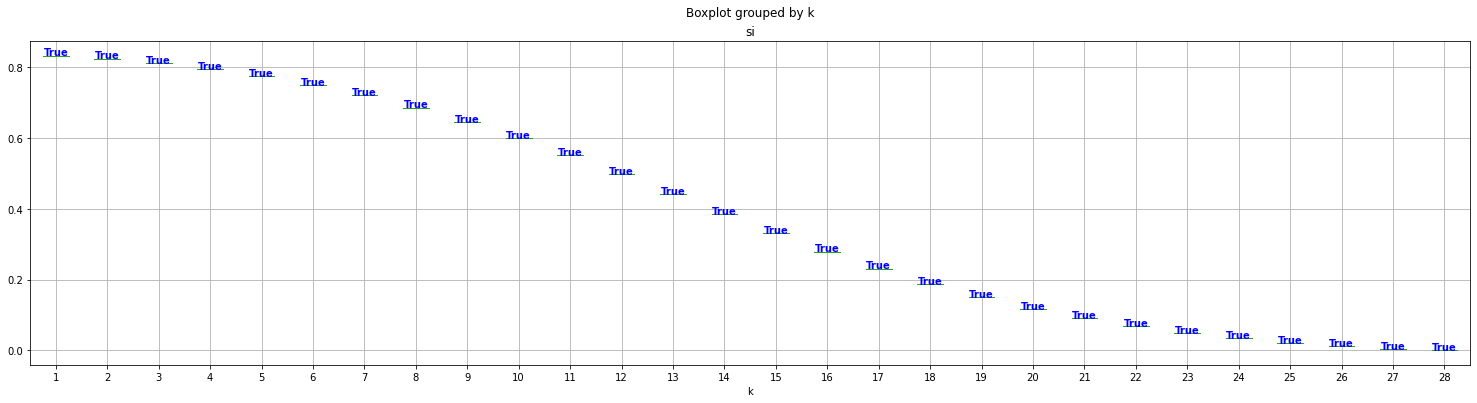

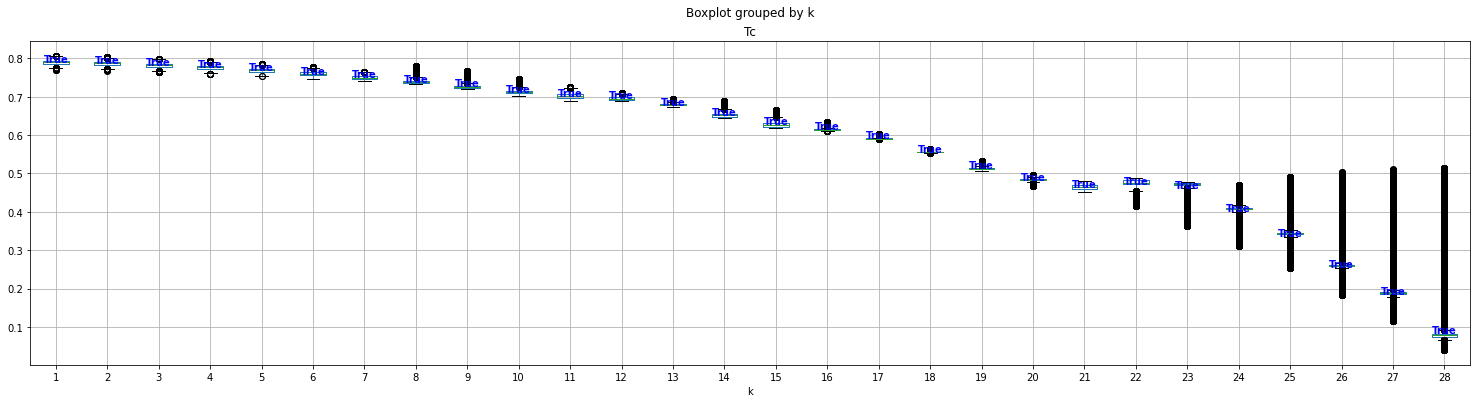

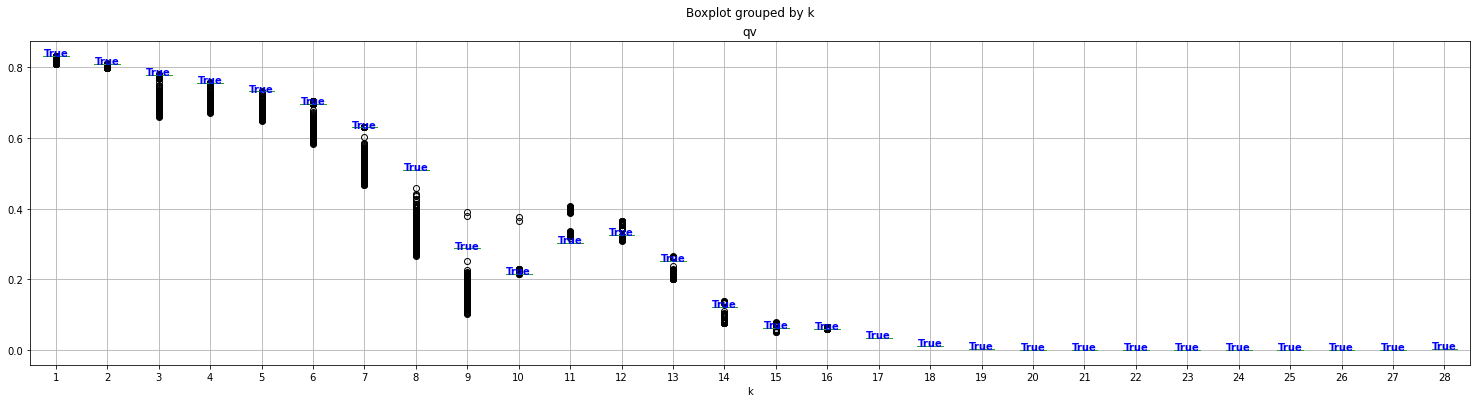

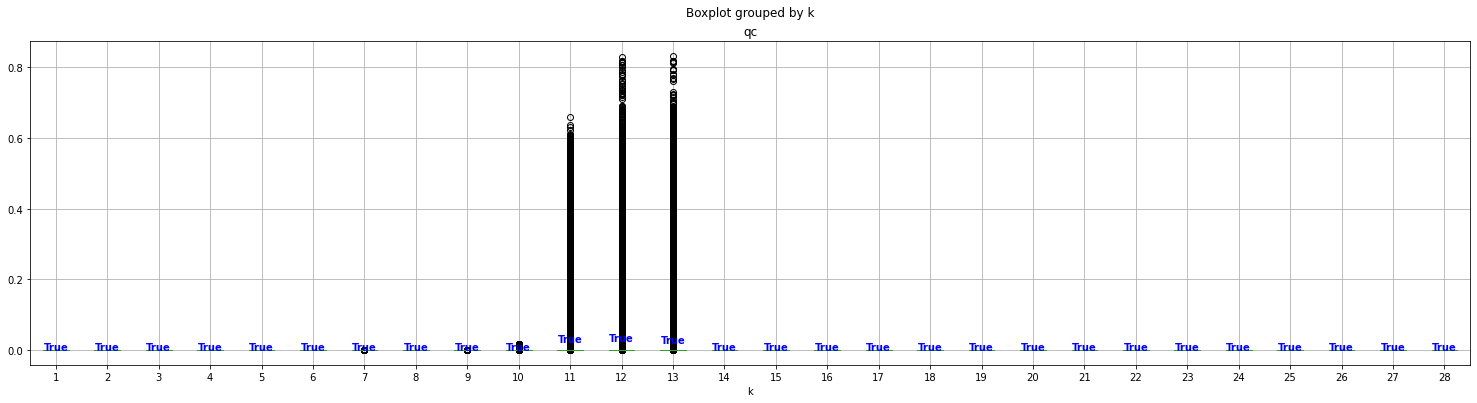

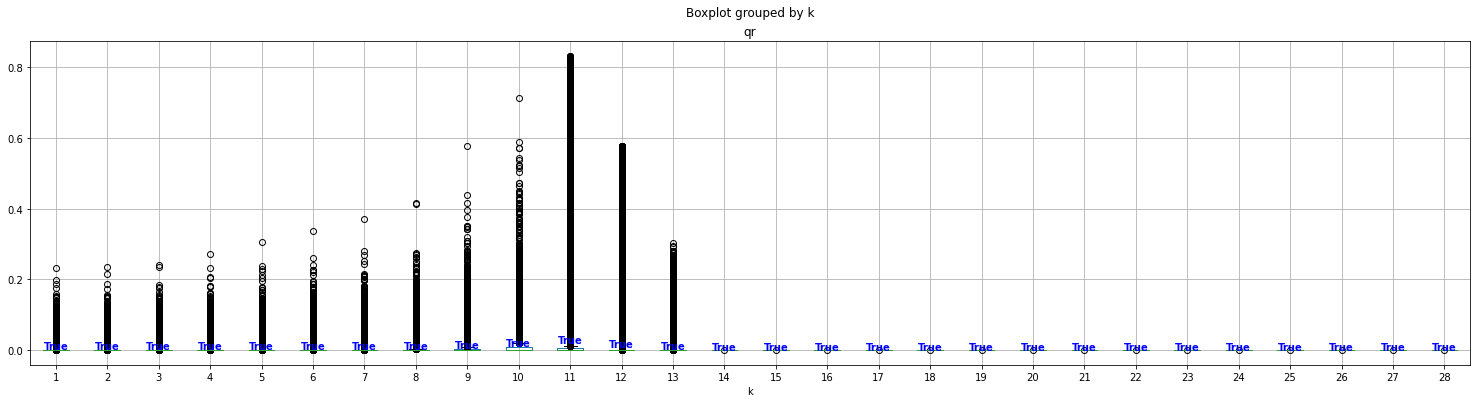

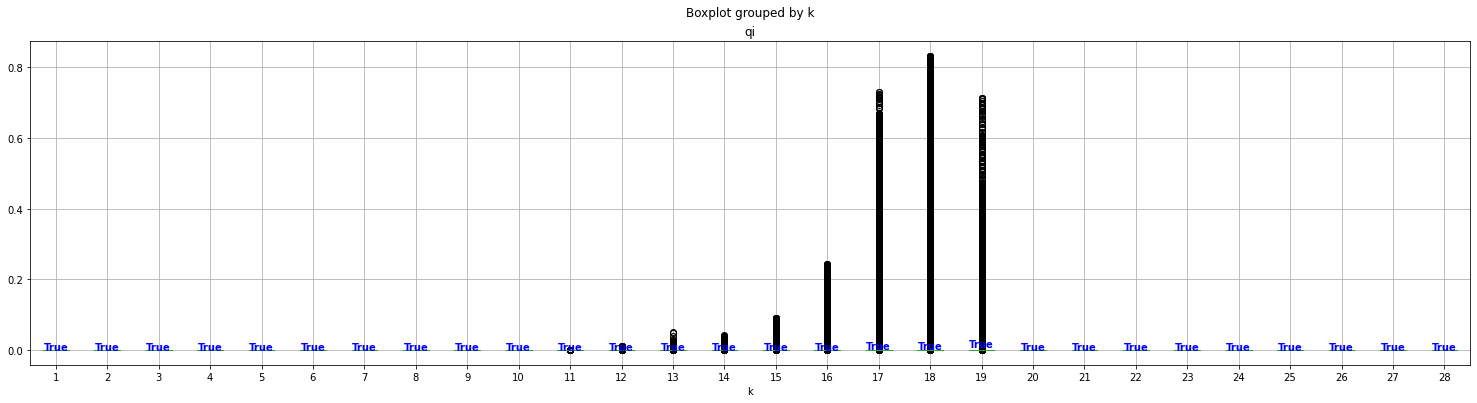

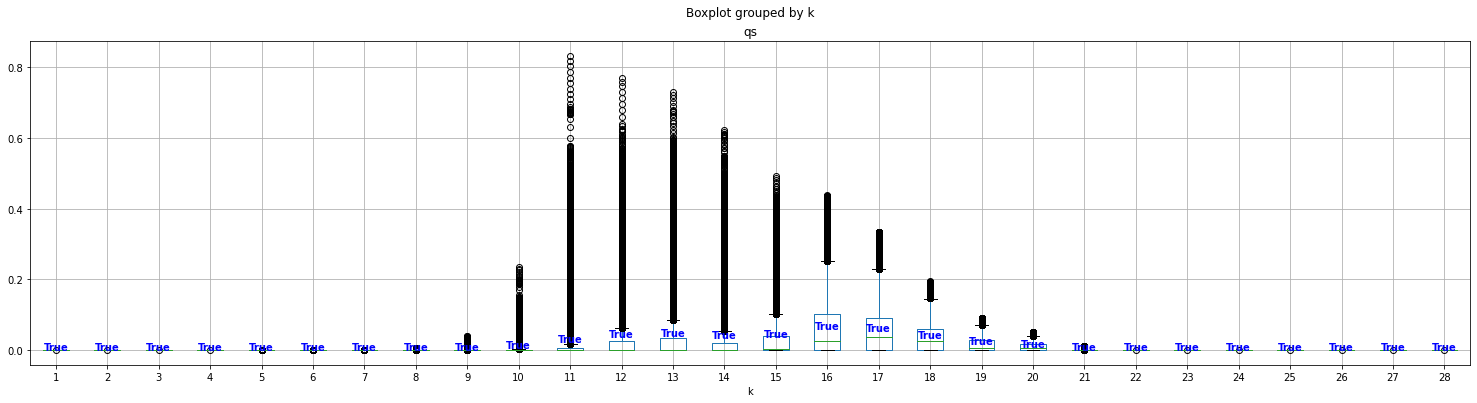

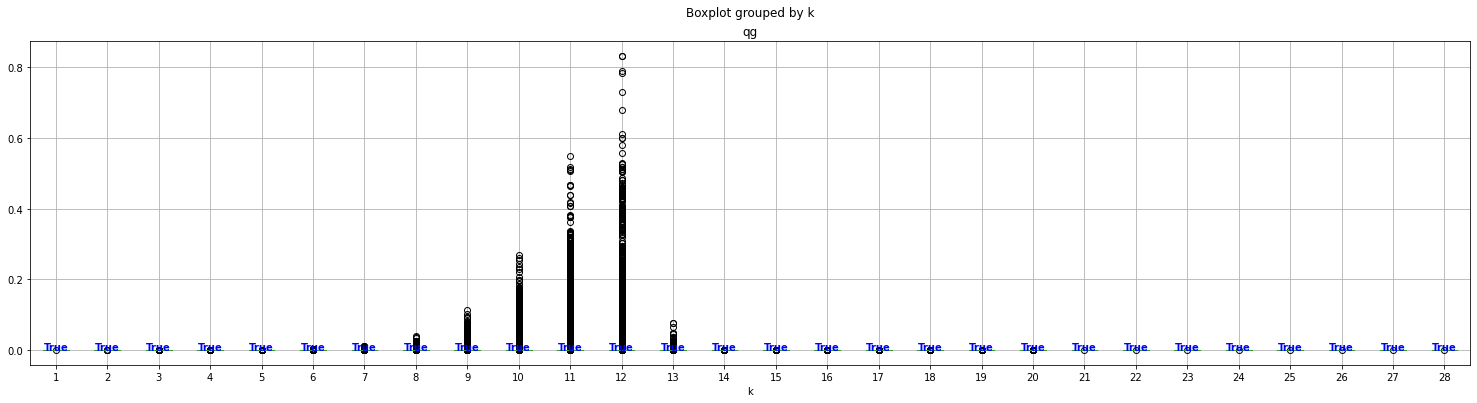

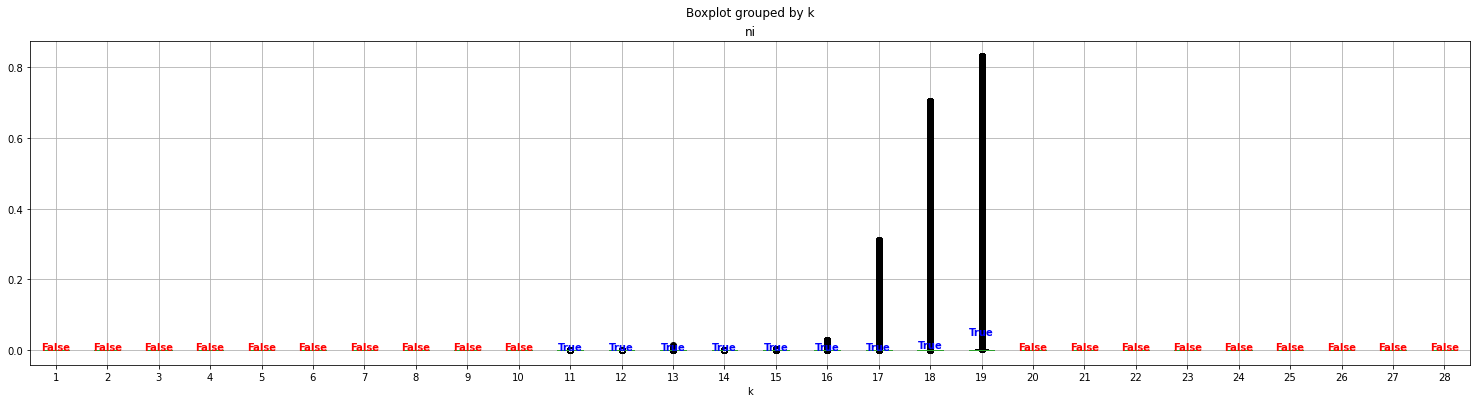

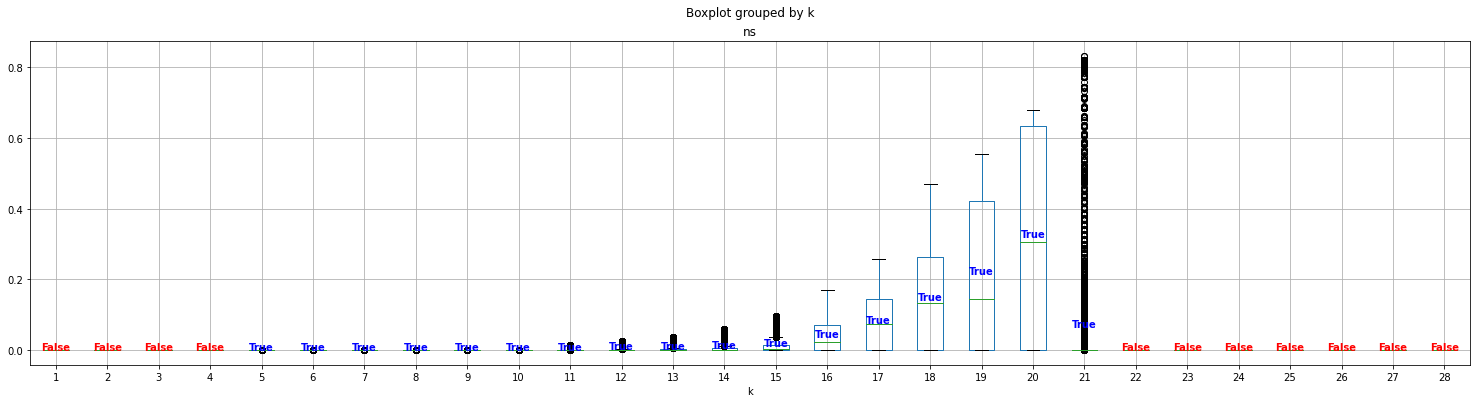

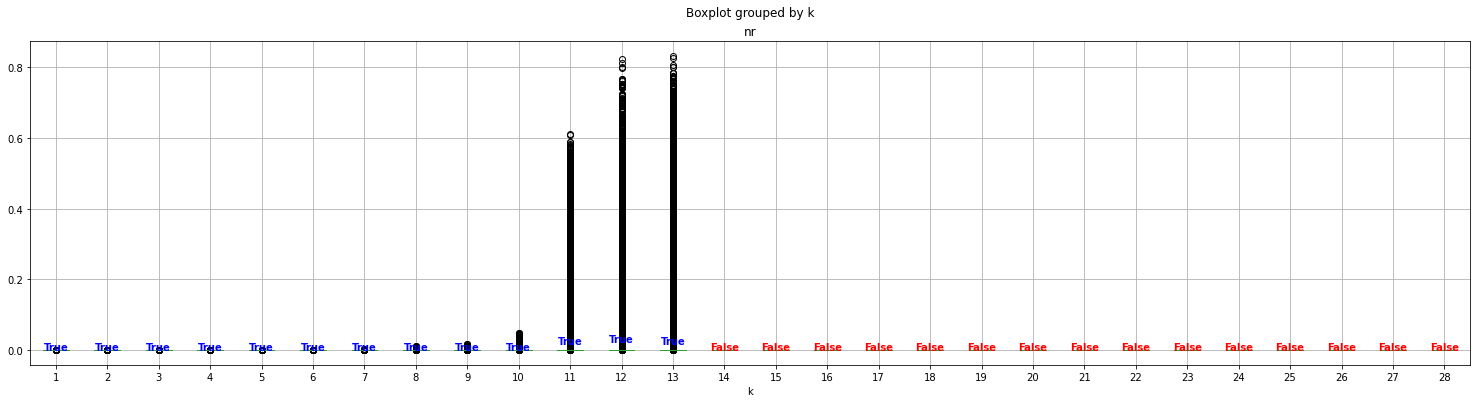

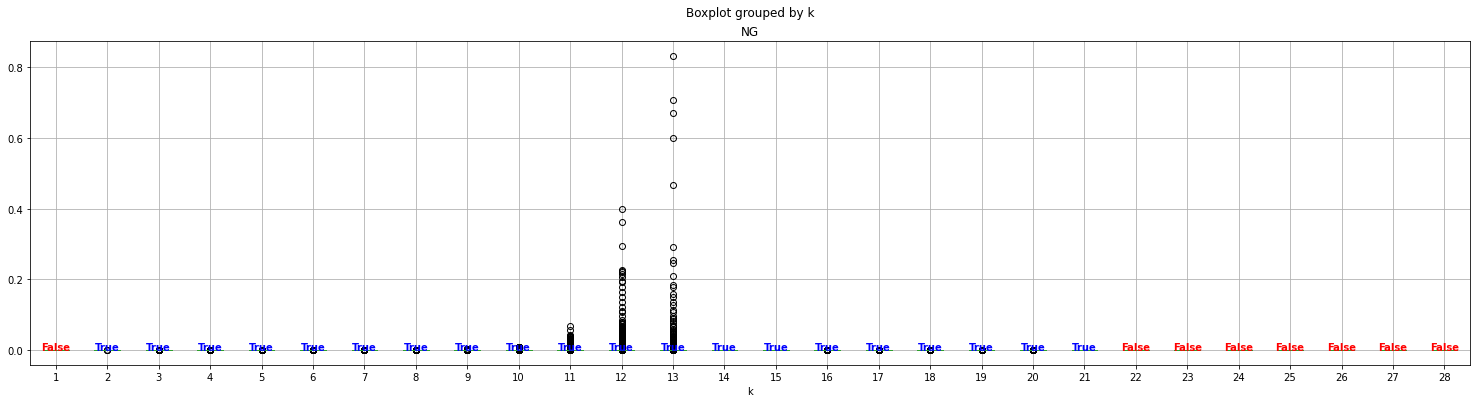

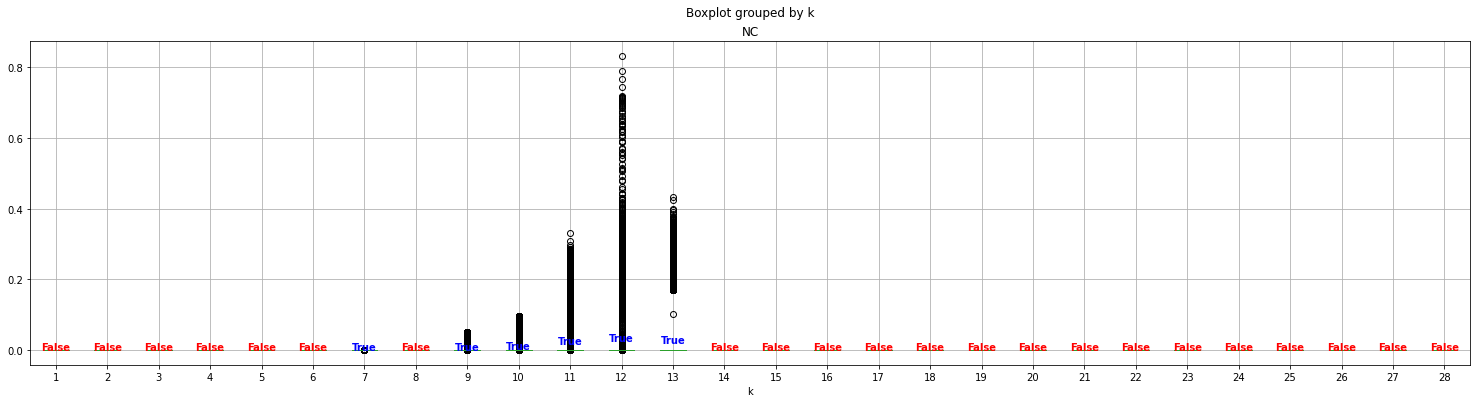

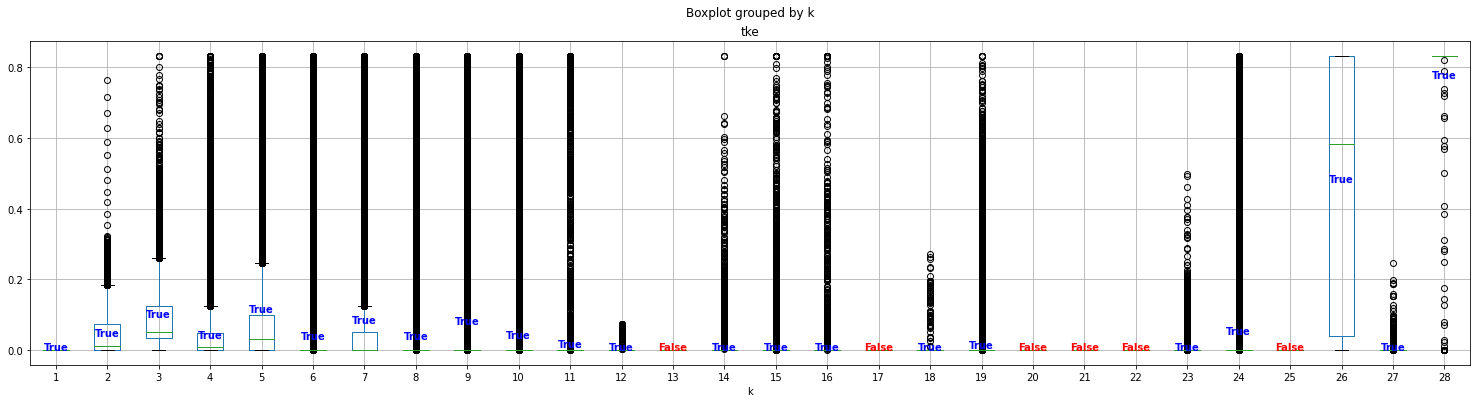

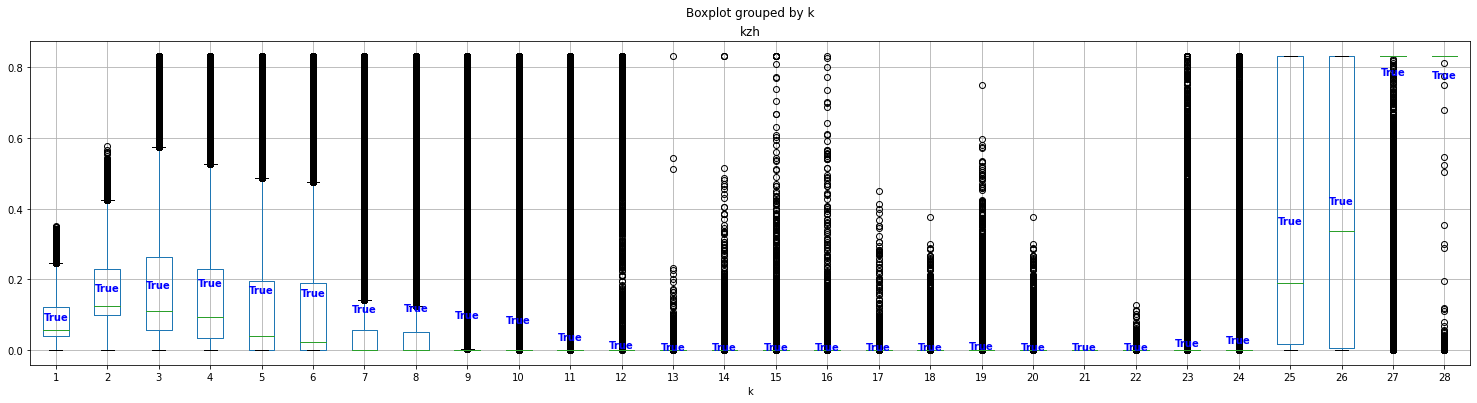

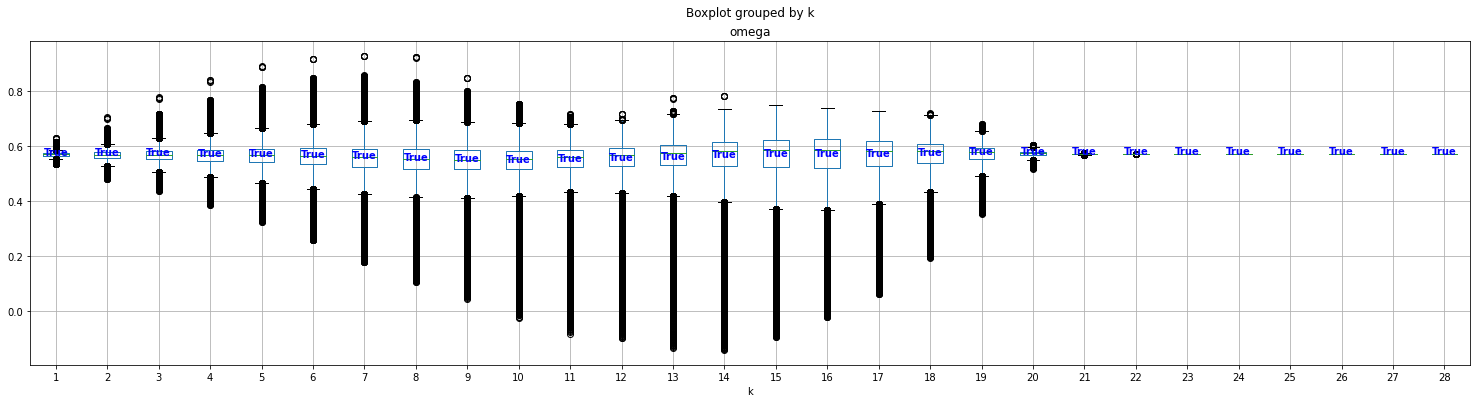

In [ ]:
#
# code below just to show
#

# normalized_all_examples = normalize_linear_scale(all_examples)
bloxplot_levels(normalized_all_examples)

# # normalized_all_examples_htang = normalize_linear_scale(all_examples, scaler="htang")

#### Boxplot das variáveis de saída linearmente normalizadas

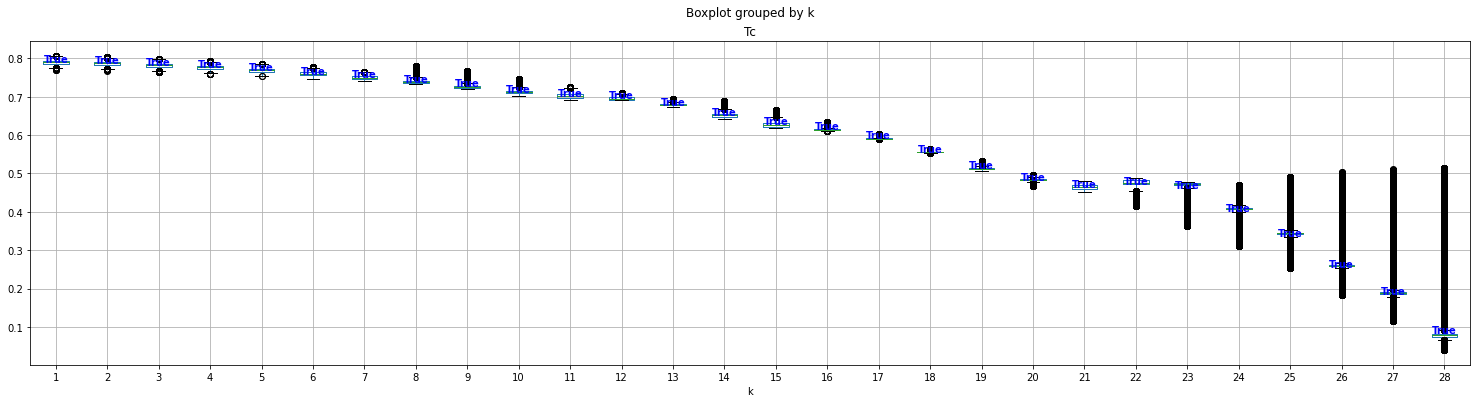

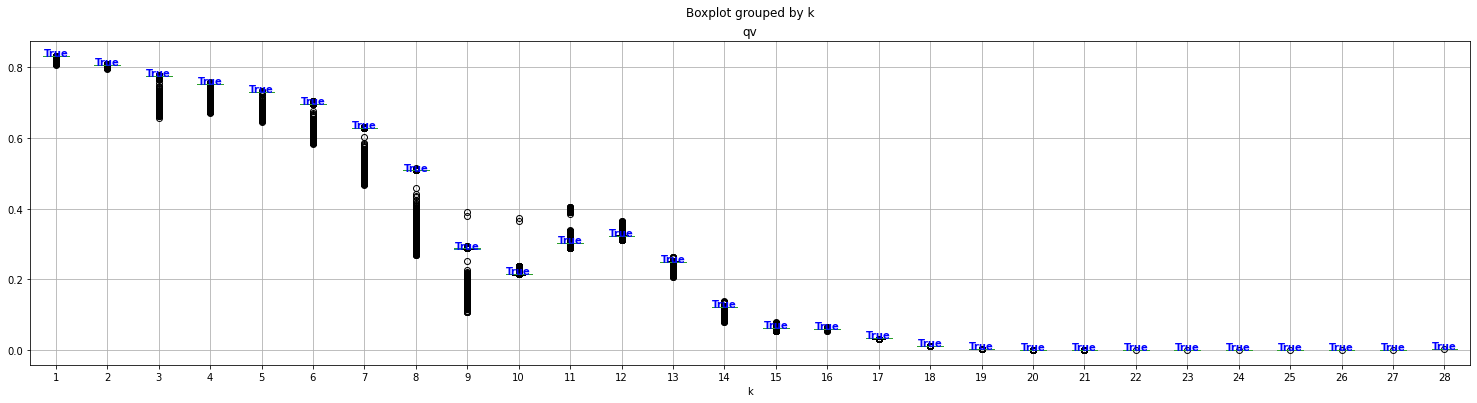

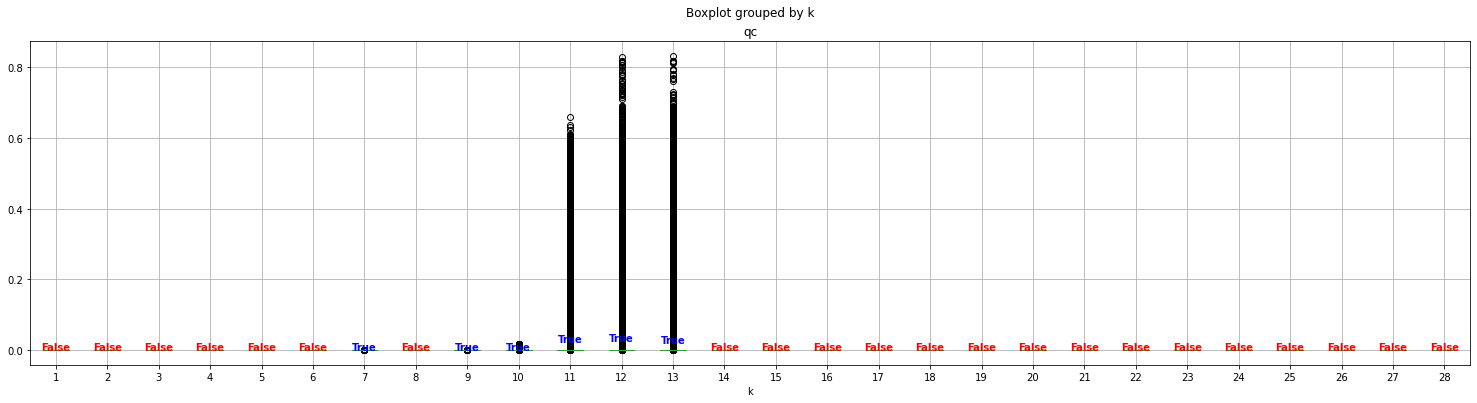

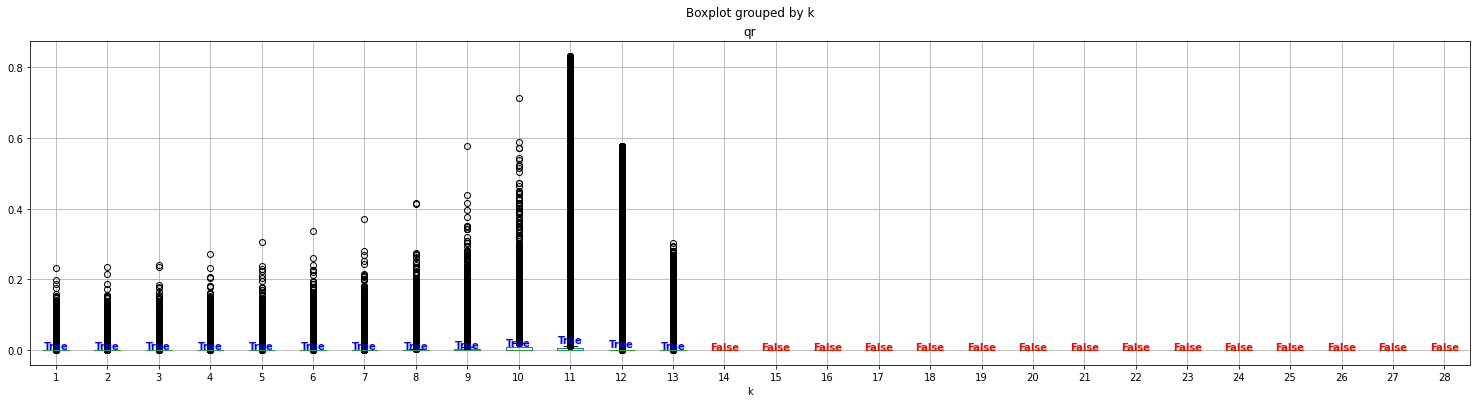

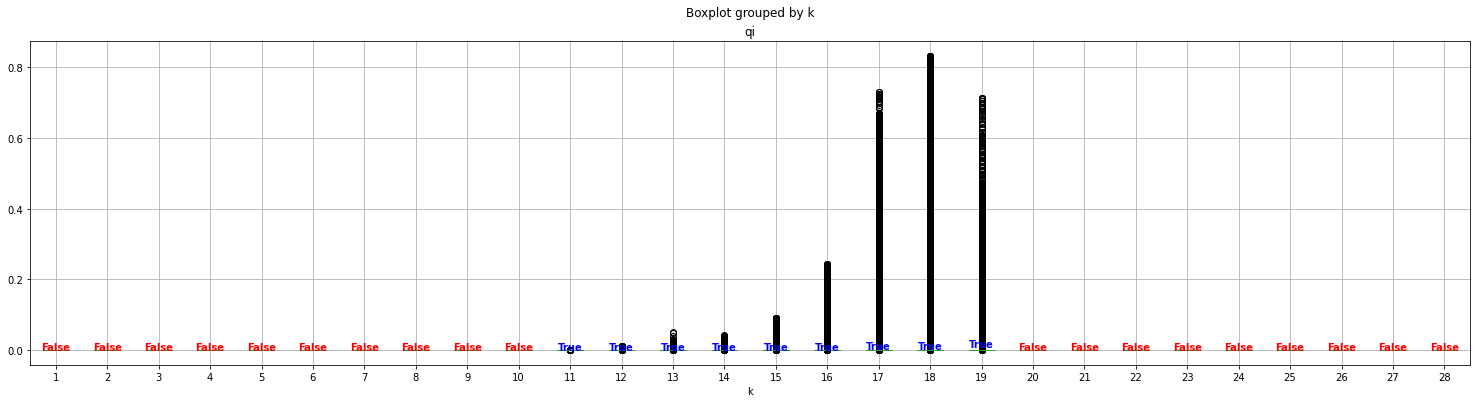

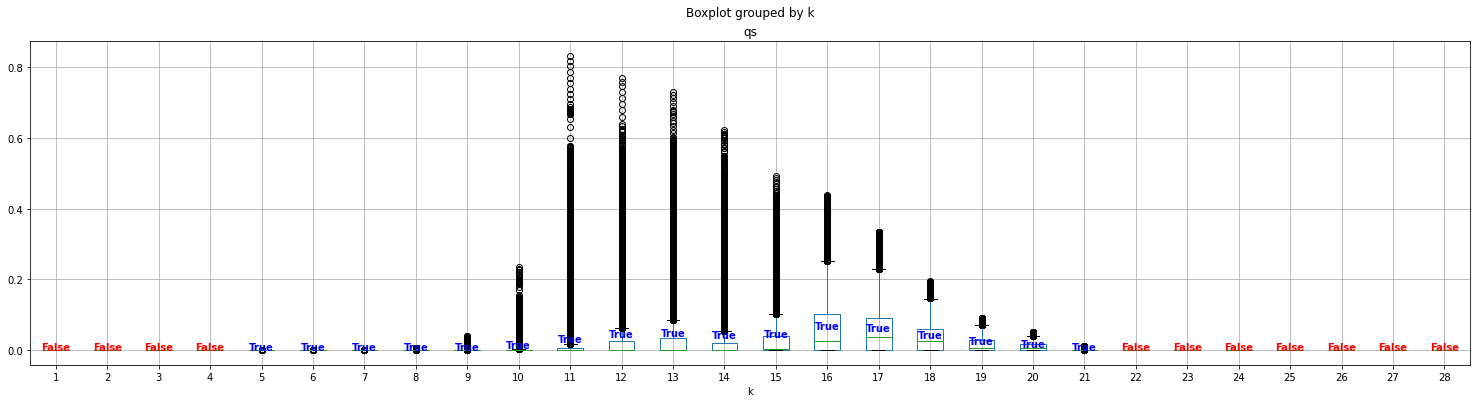

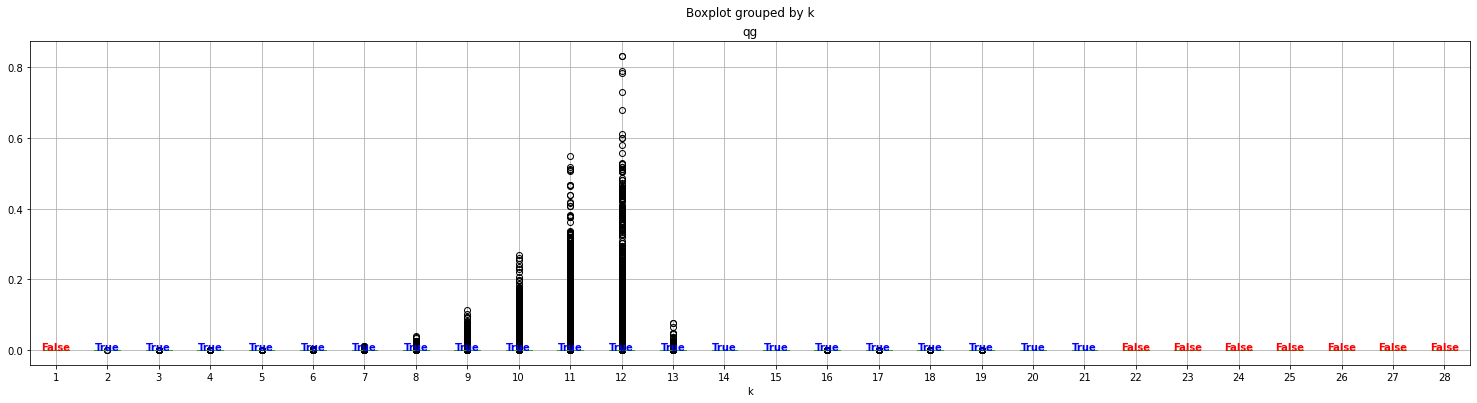

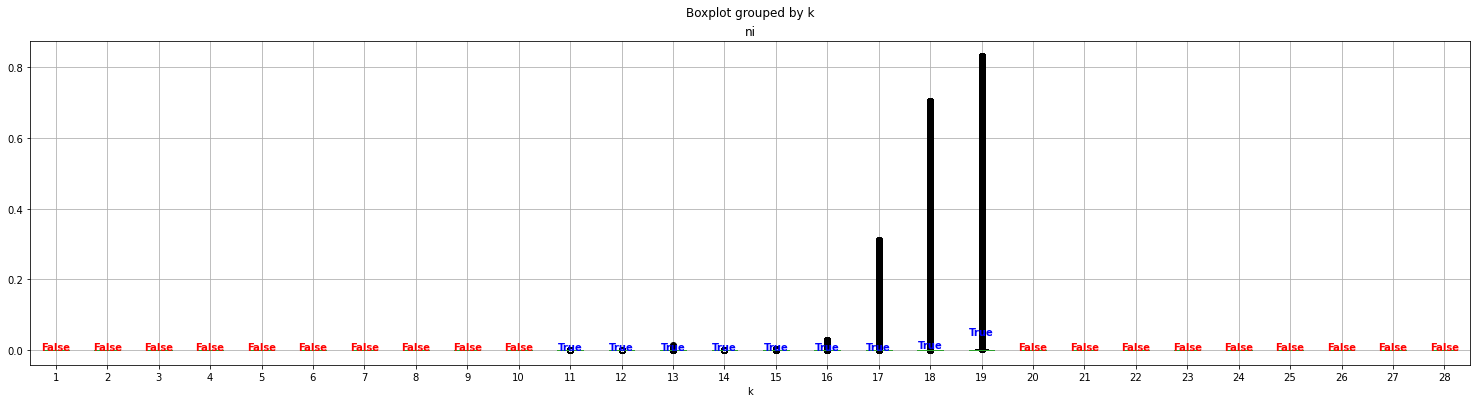

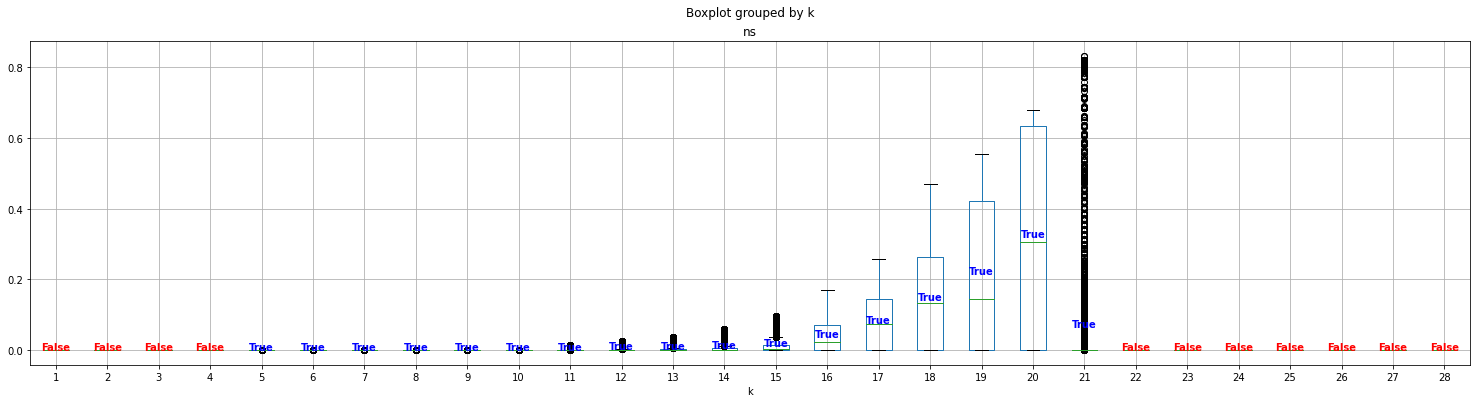

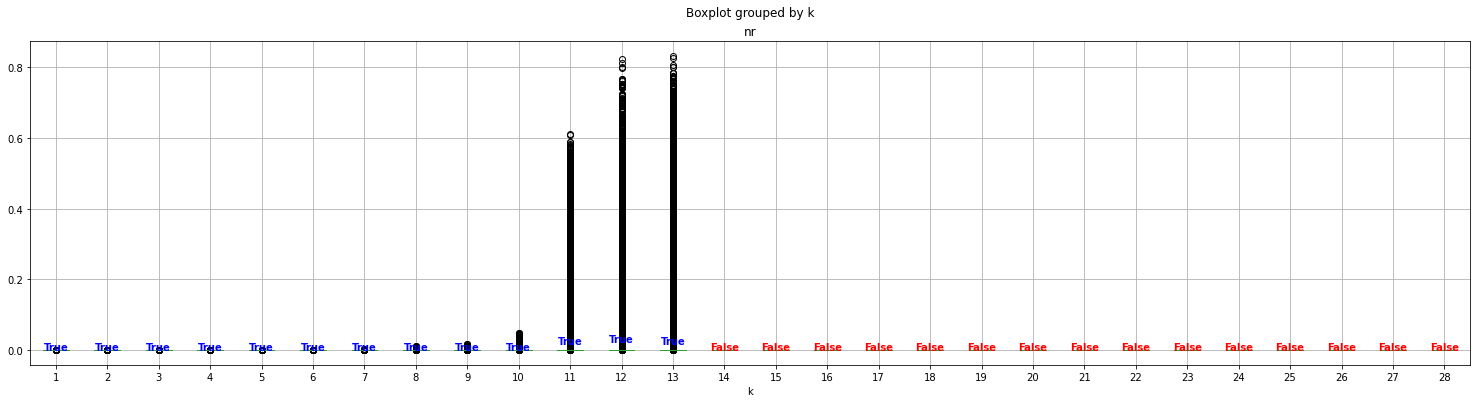

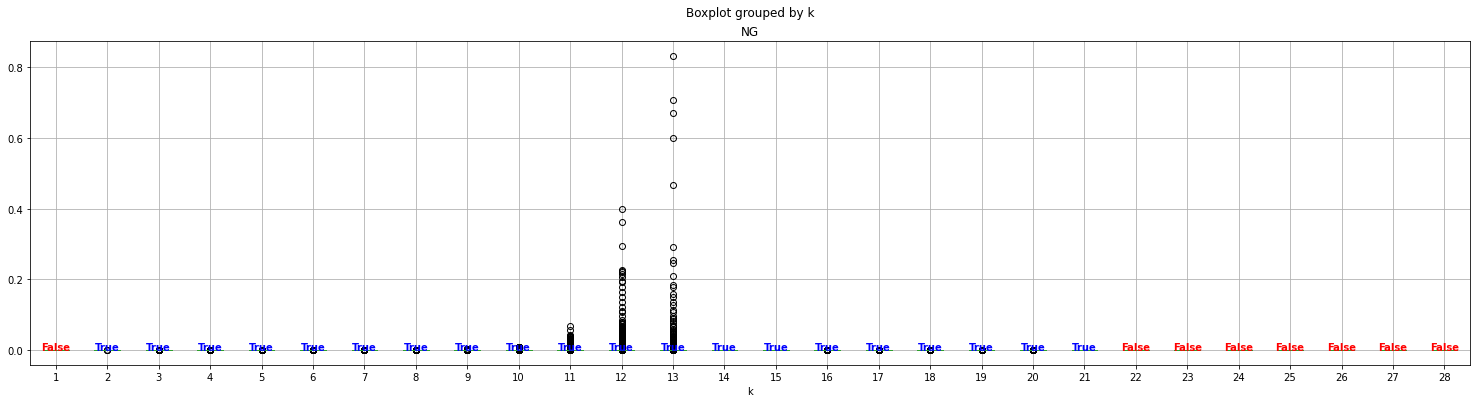

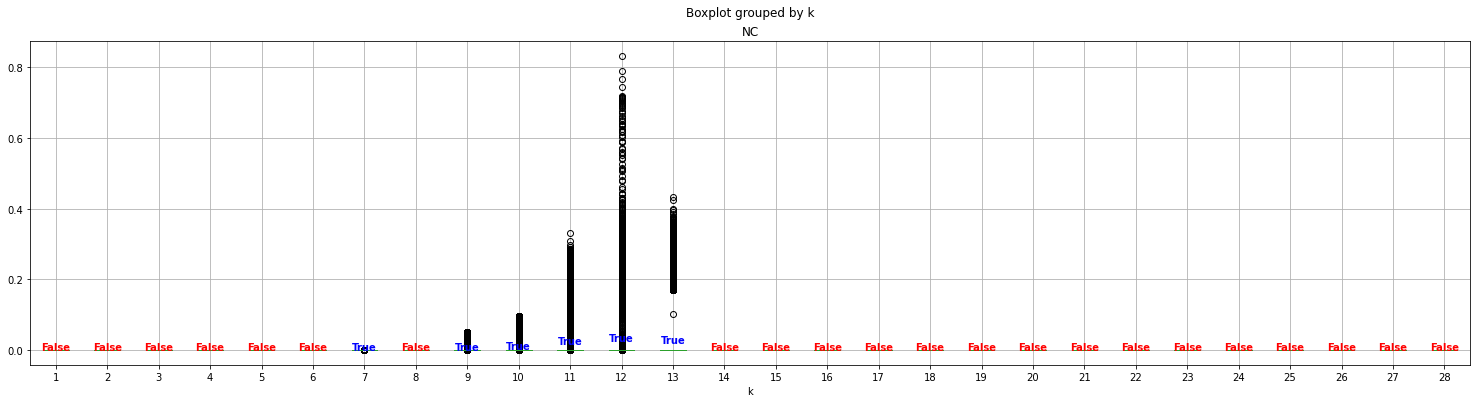

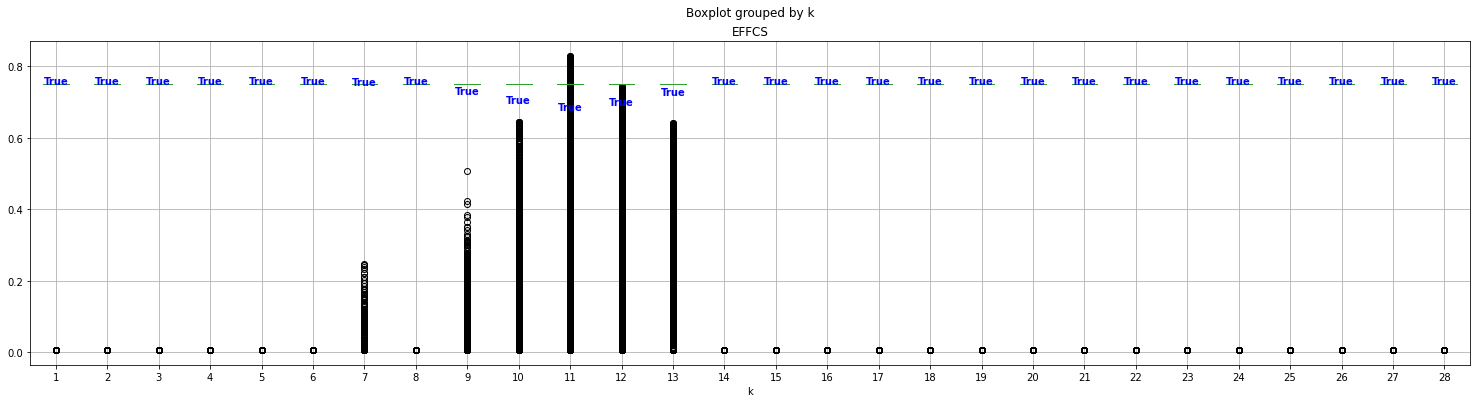

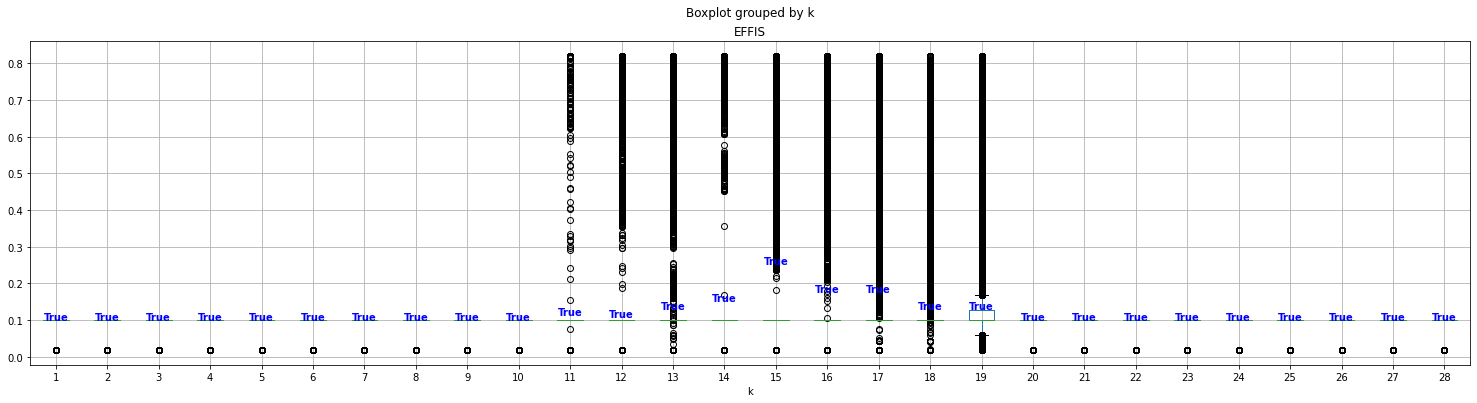

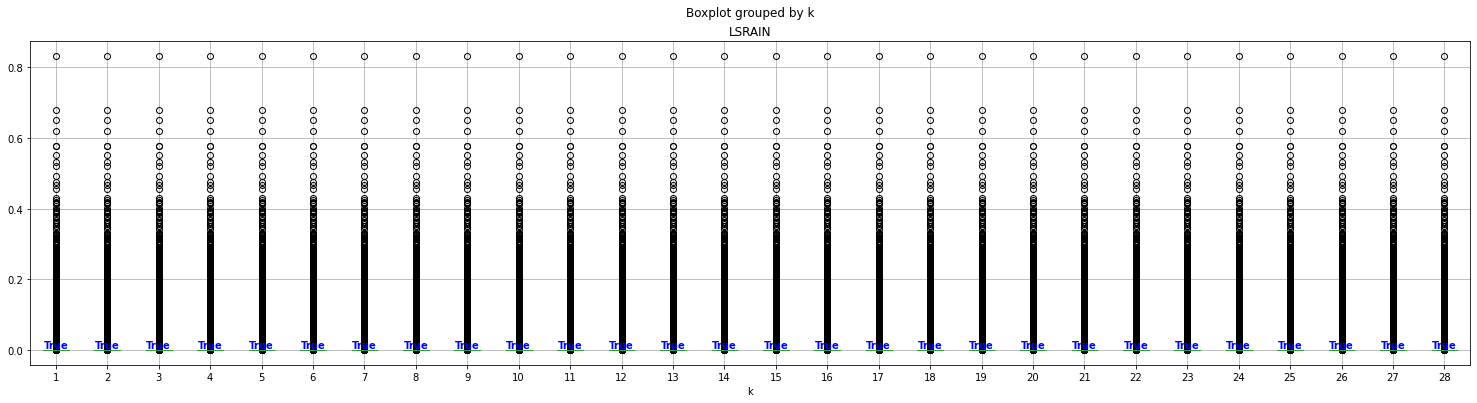

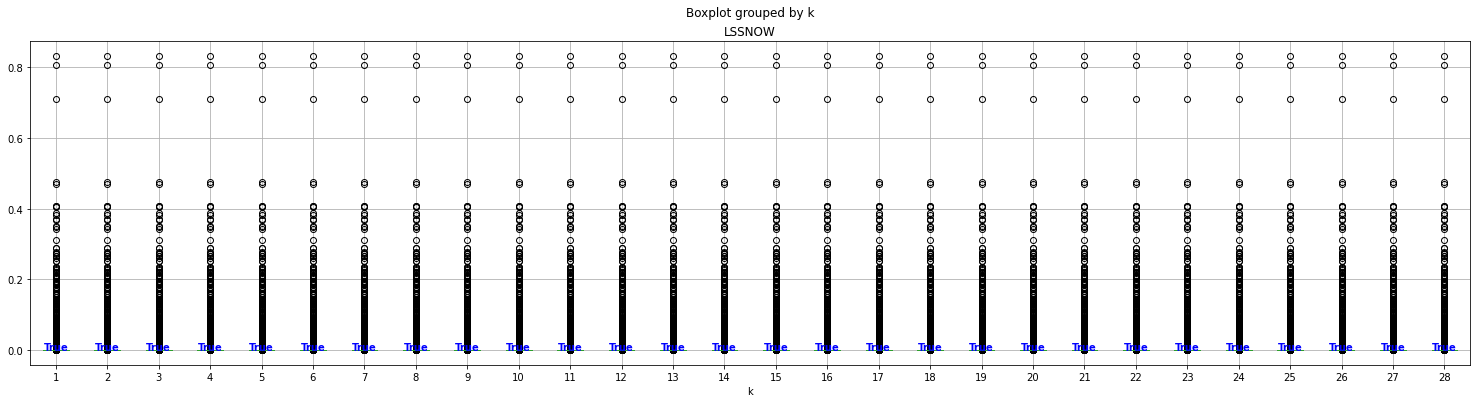

In [ ]:
#
# code below just to show
#

# normalized_all_targets = normalize_linear_scale(all_targets)
bloxplot_levels(normalized_all_targets)

# print("All normalized targets summary:")
# display.display(normalized_all_targets.describe())

### Normalização da base usando diferentes escalas para cada variável

- Diferentes normalizações por variável, como linear, logarítimica e z-score


In [ ]:
def normalize_examples(examples_dataframe):
  # "k", "si", "sl", "Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh", "omega"
  processed_features = pd.DataFrame()

  if len(examples_dataframe["k"]) > 0:
    processed_features["k"] = examples_dataframe["k"]

  for m_var in [ "si", "Tc", "qv"]:
    processed_features[m_var] = linear_scale(examples_dataframe[m_var], examples_dataframe[m_var].min(), examples_dataframe[m_var].max())

  for m_var in [ "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "tke", "kzh"]:
    processed_features[m_var] = log_normalize(examples_dataframe[m_var])

  processed_features["omega"] = z_score_normalize(examples_dataframe["omega"])
  # processed_features["population"] = linear_scale(clip(examples_dataframe["population"], 0, 5000))
    
  return processed_features


#### Boxplot das variáveis de entrada com diferentes normalizações

In [ ]:
# normalized_all_examples = normalize_examples(all_examples)
# normalized_all_targets = normalize_linear_scale(all_targets)

# print("All normalized examples summary:")
# display.display(normalized_all_examples.describe())

# print("All normalized targets summary:")
# display.display(normalized_all_targets.describe())


# # Boxplot of variables through levels
# for key in normalized_all_examples.columns.tolist():
#     if key == "k": continue
#     # plt.subplot(6, 2, idx_plot)
#     normalized_all_examples.boxplot(column=key, by="k", figsize=(15, 6))
# plt.show()

## Amostras dos Conjuntos de treinamento e validação

Exibe  o resumo de entrada e saída de conjuntos de treinamento e validação, para verificar a homogeneidade desses conjuntos


In [ ]:
def get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, train_percent_size):
  # Choose the first x percent for training.
  all_size = len(normalized_all_examples)
  train_size = int(all_size * train_percent_size / k_max)*k_max
  print("train size = {}".format(train_size))

  normalized_training_examples = normalized_all_examples.head(train_size)
  normalized_training_targets = normalized_all_targets.head(train_size)

  # Choose the last (10%) (out of 265468) for validation.
  normalized_validation_examples = normalized_all_examples.iloc[train_size:]
  normalized_validation_targets = normalized_all_targets.iloc[train_size:]
  return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets


# versão atual que grava primeiro por variavel depois por nivel, e remove niveis de LSRAIN e LSSNOW
def get_df_col_k(df_orig, k_inicial, k_final, dic_var_levs_exclude=None):
  
  print(df_orig.columns)
  dic_var_levs_exclude_ok = { \
  'LSRAIN':range(2,29),
  'LSSNOW':range(2,29)
  }  
  if dic_var_levs_exclude is not None:
    dic_var_levs_exclude_ok.update(dic_var_levs_exclude)
    
  df_col_k = pd.DataFrame()
  for col in df_orig.columns.tolist():
    if col == 'k':
        continue
    for k in range(k_inicial, k_final + 1):
      df = df_orig.copy()
      df_k = df[df['k'] == k]
      if col in dic_var_levs_exclude_ok.keys() and k in dic_var_levs_exclude_ok[col]:
          continue
      df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
  return df_col_k


# versão anterior que grava primeiro por nivel depois por variavel
# def get_df_col_k(df_orig, k_inicial, k_final, dic_var_levs_exclude=None):
#   df_col_k = pd.DataFrame()
#     df = df_orig.copy()
#     df_k = df[df['k'] == k]
#     for col in df.columns.tolist():
#       if col == 'k':
#         continue
#       if dic_var_levs_exclude is not None and col in dic_var_levs_exclude.keys():
#         if k in dic_var_levs_exclude[col]:
#           continue
#       df_col_k['{}_k{}'.format(col, k)] = df_k[col].to_numpy()
#   return df_col_k


def get_arr_2D_col_k(df_orig, colname, k_inicial, k_final):
  levels = k_final - k_inicial + 1
  rows_one_level = int(len(df_orig.index)/levels)
  arr_col_2d = np.zeros((rows_one_level, k_max))

  for k in range(k_inicial, k_final + 1):
    df = df_orig.copy()
    df_k = df[df['k'] == k]
    arr_col_2d[:, k-1] = df_k[colname].to_numpy()
 
  return arr_col_2d

In [ ]:
# Choose variables to train and validate
# Eliminate variables are not varying
# Separate 70% for training and 30# for validation

training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

print("Training examples summary:")
display.display(training_examples_tmp.describe())

print("Validation examples summary:")
display.display(validation_examples_tmp.describe())

print("Training targets summary:")
display.display(training_targets_tmp.describe())

print("Validation targets summary:")
display.display(validation_targets_tmp.describe())


train size = 3405696
Training examples summary:


k             si  ...            kzh          omega
count 3405696.000000 3405696.000000  ... 3405696.000000 3405696.000000
mean       14.500000       0.468551  ...      45.851484      -0.012420
std         8.077748       0.363561  ...      94.082704       0.078518
min         1.000000       0.003669  ...       0.030000      -0.985995
25%         7.750000       0.103880  ...       0.100000      -0.024188
50%        14.500000       0.432240  ...       0.100000       0.000000
75%        21.250000       0.834470  ...      31.698106       0.014214
max        28.000000       1.000000  ...     300.000000       0.541837

[8 rows x 17 columns]

Validation examples summary:


k             si  ...            kzh          omega
count 1459612.000000 1459612.000000  ... 1459612.000000 1459612.000000
mean       14.500000       0.468551  ...      51.573874      -0.010004
std         8.077750       0.363561  ...     100.951058       0.080191
min         1.000000       0.003669  ...       0.030000      -1.076957
25%         7.750000       0.103880  ...       0.100000      -0.022978
50%        14.500000       0.432240  ...       0.100000       0.000000
75%        21.250000       0.834470  ...      34.307073       0.017509
max        28.000000       1.000000  ...     300.000000       0.396736

[8 rows x 17 columns]

Training targets summary:


k             Tc  ...         LSRAIN         LSSNOW
count 3405696.000000 3405696.000000  ... 3405696.000000 3405696.000000
mean       14.500000     237.595058  ...       0.000001       0.000000
std         8.077748      61.435035  ...       0.000004       0.000000
min         1.000000      63.503048  ...      -0.000000      -0.000000
25%         7.750000     202.664223  ...       0.000000       0.000000
50%        14.500000     257.319978  ...       0.000000       0.000000
75%        21.250000     288.877419  ...       0.000000       0.000000
max        28.000000     308.583864  ...       0.000133       0.000000

[8 rows x 17 columns]

Validation targets summary:


k             Tc  ...         LSRAIN         LSSNOW
count 1459612.000000 1459612.000000  ... 1459612.000000 1459612.000000
mean       14.500000     238.308012  ...       0.000001       0.000000
std         8.077750      61.152400  ...       0.000003       0.000000
min         1.000000      73.449916  ...      -0.000000      -0.000000
25%         7.750000     202.356310  ...       0.000000       0.000000
50%        14.500000     257.744712  ...       0.000000       0.000000
75%        21.250000     289.447436  ...       0.000000       0.000000
max        28.000000     308.962369  ...       0.000163       0.000000

[8 rows x 17 columns]

In [ ]:
# Set using Variables per K
# training_examples_tmp, training_targets_tmp, validation_examples_tmp, validation_targets_tmp = get_percent_normalized_trainining_and_validation(all_examples, all_targets, 0.7)

# k_inicial = 1
# k_final = k_max

# training_examples_tmp = get_df_col_k(training_examples_tmp, k_inicial, k_final)
# training_targets_tmp = get_df_col_k(training_targets_tmp, k_inicial, k_final)
# validation_examples_tmp = get_df_col_k(validation_examples_tmp, k_inicial, k_final)
# validation_targets_tmp = get_df_col_k(validation_targets_tmp, k_inicial, k_final)



# display.display(training_examples_tmp.describe())
# display.display(validation_examples_tmp.describe())
# display.display(training_targets_tmp.describe())
# display.display(validation_targets_tmp.describe())


# Treinamento da rede neural: Rotinas utilizadas


In [ ]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    print("Features:", features)
    print("Labels:", labels)
    return features, labels

In [ ]:
def use_tpu():

# https://www.tensorflow.org/guide/tpu

# eager é bom pra avaliar os objetos tensor sem precisar de graphs.
# Nesse caso desativo pra não dar o erro Tensor.graph is meaningless when eager execution is enabled. 

  # tf.compat.v1.disable_eager_execution()

  try:

    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    # para TF2
    # resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # https://www.tensorflow.org/guide/tpu
    print('Running on TPU ', resolver.cluster_spec().as_dict()['worker'])
  except ValueError:
    raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
  
  # requer eager
  # tf.config.experimental_connect_to_cluster(resolver)

  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  tpu_strategy = tf.distribute.TPUStrategy(resolver)
  return tpu_strategy

# tpu_strategy = use_tpu()
# with tpu_strategy.scope():
#  code here

In [ ]:
def use_gpu():
# Using GPU ...  mais lento que TPU - mesmo temo que CPU ou pouco mais rápido:
# ex: 
#   INFO:tensorflow:global_step/sec: 299.778
#   INFO:tensorflow:loss = 3.5140946, step = 200 (0.332 sec)
  
  device_name = tf.test.gpu_device_name()
  if device_name != '/device:GPU:0':
    print('GPU device not found')
    return False
  print('Found GPU at: {}'.format(device_name))
  return True

# use_gpu()
with tf.device('/device:GPU:0') as gpu:
    print("Gpu name={}".format(gpu))


Gpu name=None


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jul  8 13:39:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    36W / 250W |    347MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=False):

  # TODO - original_*_df foi limpo pra limpar memória, após a sua última utilização em 
  # all_examples, all_targets. Tentar usar all_examples, all_targets

  spinup_size = int(levels * spin_hours * 3600/delta_t) 
  total_size = len(original_input_df)
  no_spinup_size = total_size-spinup_size
  all_examples_tmp = original_input_df.tail(no_spinup_size)
  all_targets_tmp = original_output_df.tail(no_spinup_size)
  print("First 3 examples and targets for checking spinup start")
  display.display(all_examples_tmp.head(3))
  display.display(all_targets_tmp.head(3))

  if pre_process:
    # select initial filtered variables
    all_examples_tmp = preprocess_features(all_examples_tmp)
    all_targets_tmp = preprocess_targets(all_targets_tmp)

  return all_examples_tmp, all_targets_tmp, no_spinup_size

## Construção das NN customizáveis

In [ ]:
# get sample dataset
def get_dataset():
    X, y = make_regression(n_samples=1000, n_features=10, n_informative=5, n_targets=3, random_state=2)
    return X, y



def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse', dropout=None, batch_norm=None, activation='relu', timesteps_window=None):
    # dropout = Fraction of the input units to drop
    if timesteps_window is None:
      inputs = Input(shape=n_inputs)
    else:
      inputs = Input(shape=(timesteps_window, n_inputs))
    x = inputs
    for neurons in neurons_per_layer:
      if batch_norm is None or batch_norm is False:
        x = Dense(neurons, activation=activation)(x)
      elif batch_norm == 'no_activation':
        x = Dense(neurons, activation=activation)(x)
        x = BatchNormalization()(x)
      else:
        x = Dense(neurons)(x)
        x = BatchNormalization()(x)
        x = Activation(activation)(x)

      if dropout is not None:
        # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
        x = Dropout(dropout)(x)

    if timesteps_window is not None:
      x = Flatten()(x)
      
    level_all = Dense(n_outputs)(x)
    model = Model(inputs=inputs, outputs=level_all)
    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
    return model


def get_cnn_model(n_inputs, n_outputs, arr_convs_filters_kernels_batch_pool, neurons_per_layer, dropout=None, optimizer='adam', loss='mse', timesteps_window=None, is_CNN2D=False, activation='relu'):

    if is_CNN2D and timesteps_window is None:
      print("***************** Must set timesteps_window for CNN2D! ****************************")
      return False
  
    # kernel = 3
    # 448 - (kernel-1)
    # 446 
    model = Sequential()
    for conv in arr_convs_filters_kernels_batch_pool:

      if timesteps_window is None:
        model.add(Conv1D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(n_inputs,1)))
      else:
        if is_CNN2D:
          model.add(Conv2D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(timesteps_window, n_inputs)))
        else:
          model.add(Conv1D(filters=conv[0], kernel_size=conv[1], activation=activation, input_shape=(timesteps_window, n_inputs)))
      
      if conv[2] is not None:
        # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
        model.add(BatchNormalization())
        model.add(Activation("relu"))
    
      if conv[3] is not None:
        if is_CNN2D:
          model.add(MaxPooling2D(pool_size=conv[2]))
        else:
          model.add(MaxPooling1D(pool_size=conv[2]))
    
    model.add(Flatten())
    for neurons in neurons_per_layer:
        if neurons is not None:
          model.add(BatchNormalization())
          model.add(Activation("relu"))
          model.add(Dense(neurons, activation=activation))
          if dropout is not None:
            # https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html
            model.add(Dropout(dropout))
    
    # precisa fazer o reshape quando for usar (caso com timesteps_window)
    model.add(Dense(n_outputs))

    model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model


# idem mas com Sequential - erro ?
# def get_custom_model(n_inputs, n_outputs, neurons_per_layer, optimizer='adam', loss='mse'):

#     model = keras.Sequential()
#     first = True
#     for neurons in neurons_per_layer:
#       if first:
#         model.add(Dense(neurons, input_dim=n_inputs, activation="relu"))
#         first = False
#       else:
#         model.add(Dense(neurons, activation="relu"))

#     model.add(Dense(n_outputs))
#     model.compile(loss=loss, optimizer=optimizer, metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model
    

# get the model
def get_sample_model(n_inputs, n_outputs, loss='mae'):
    # losses = mean_squared_error, mae ... https://keras.io/api/losses/
    
    model = Sequential()
    model.add(Dense(20, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss=loss, optimizer='adam')
    return model


def get_curr_time():
    return datetime.now().strftime("%m-%d.%H.%M")


def get_tb_logdir_var(test_name, layers, epochs, target_var="ALL_VARS"):
  log_dir_test = get_tb_logdir_test(test_name)
  return "{}/{}__{}-layers__{}-epochs___{}".format(log_dir_test, target_var, layers, epochs, get_curr_time())


def create_tb_logdir_test(test_name):
  tb_logdir_test = get_tb_logdir_test(test_name)
  rmtree(tb_logdir_test, ignore_errors=True)
  os.makedirs(tb_logdir_test)
  return tb_logdir_test


def get_tb_logdir_test(test_name):
  return "{}/{}".format(tb_logdir_base, test_name)


def get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  test_dir_name = '{}_{}-inputs_{}-layers_{}-outputs_{}-epochs__{}'.format(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  return test_dir_name


def get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name):
  save_dir='{}/saved_models'.format(colab_in_drive_root_dir)
  model_var_name_dir = '{}/{}'.format(save_dir, get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name))
  return model_var_name_dir


def get_drive_test_log_dir(test_name):
  drive_logs_test_dir = '{}/logs/{}'.format(colab_in_drive_root_dir, test_name)
  return drive_logs_test_dir


def create_drive_test_log_dir(test_name):
  drive_logs_test_dir = get_drive_test_log_dir(test_name)
  rmtree(drive_logs_test_dir, ignore_errors=True)
  os.makedirs(drive_logs_test_dir)
  return drive_logs_test_dir


def save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir, var_name='ALL_VARS'):
  model_var_name_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  rmtree(model_var_name_dir, ignore_errors=True)
  os.makedirs(model_var_name_dir)
  log_msg('Saving model in {} ...'.format(model_var_name_dir))
  
  model.save(model_var_name_dir)
  model.save(model_var_name_dir + '/tmp_model.h5')

  plot_model(model, show_shapes=True, to_file='{}/model.png'.format(model_var_name_dir))

  test_dir_name = get_test_dir_name(test_name, n_inputs, hidden_layers, n_outputs, epochs, var_name)
  drive_logs_test_var_dir = '{}/{}'.format(drive_logs_test_dir, test_dir_name)
  copytree(log_dir_var, drive_logs_test_var_dir)
  log_msg('Saving logs in {} ...'.format(drive_logs_test_var_dir))


# train and evaluate a model using repeated k-fold cross-validation
def train_model(model, X, y, tb_log_dir, epochs=200, mode='split', n_splits=10, batch_size=64, shuffle=True):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_log_dir) 
    log_msg("Start training")
    start = time.time()
    results = list()
    # if len(X.shape) == 1:
    #     n_inputs = 1
    # else:
    #     n_inputs = X.shape[1]
    # if len(y.shape) == 1:
    #     n_outputs = 1
    # else:
    #     n_outputs = y.shape[1]

    if shuffle==False and (mode != 'split' or splits >1):
      print("Modo de divisão inválido")
      return False

    if mode == 'k-folds':
      # Using k-folds ---- bad- must use many splits (number of itens trained) - to slow
      #
      n_repeats = 2
      epochs_k = int(epochs / n_splits)
      cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
      first_time=True
      # enumerate folds
      for train_ix, test_ix in cv.split(X):
          # prepare data
          X_train, X_test = X[train_ix], X[test_ix]
          y_train, y_test = y[train_ix], y[test_ix]
          if first_time:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, callbacks=[tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
            first_time = False
          else:
            model.fit(X_train, y_train, verbose=1, epochs=epochs_k, batch_size=batch_size, use_multiprocessing=True)
          # evaluate model on test set
          loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
          log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl, n_splits, model.loss, loss_metric))
          # store result
          results.append(loss_metric)

    elif mode == 'split':
      early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)

      for spl in range(n_splits):
        X_train, X_test, y_train, y_test = train_test_split(
          X, y, test_size=0.2, random_state=1, shuffle=shuffle)
        display.display(X_train.shape)
        display.display(X_test.shape)
        display.display(y_train.shape)
        display.display(y_test.shape)
        
        # model.fit(X_train, y_train, verbose=1, epochs=epochs, callbacks=[early_stop_callback, tensorboard_callback], batch_size=batch_size, use_multiprocessing=True)
        model.fit(X_train, y_train, verbose=1, epochs=epochs, callbacks=[tensorboard_callback, early_stop_callback], batch_size=batch_size, use_multiprocessing=True)
        
        # evaluate model on test set
        loss_metric = model.evaluate(X_test, y_test, verbose=1, batch_size=batch_size, use_multiprocessing=True)
        log_msg( 'Test on TRAINING set. split {} of {} : [{} loss, metric(rmse)]={}'.format(spl+1, n_splits, model.loss, loss_metric))
        results.append(loss_metric)



    end = time.time()
    log_msg("Training finished in {} seconds".format(end-start))
    log_msg( 'All training mse losses/rmse metric all spits: \n {}'.format(results))
    log_msg( '======> Test on TRAINING set: [{} loss, metric(rmse)]={}'.format(model.loss, loss_metric))
    return results


def validate_model(model, normalized_validation_examples, normalized_validation_targets, batch_size=64, is_CNN=False):
  log_msg("Validating model in test set ...")

  arr_input_val = normalized_validation_examples.to_numpy()
  if len(arr_input_val.shape) > 1:
    num_vars = arr_input_val.shape[1]
  else:
    num_vars = 1
  log_msg("Input Validation variables/size = {}/{}".format(num_vars, arr_input_val.shape[0])) 

  if is_CNN:
    arr_input_val = np.expand_dims(arr_input_val, 2)
    
  arr_output_val = normalized_validation_targets.to_numpy()
  if len(arr_output_val.shape) > 1:
    num_vars = arr_output_val.shape[1]
  else:
    num_vars = 1
  log_msg("Output Validation variables/size = {}/{}".format(num_vars, arr_output_val.shape[0])) 

  loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1, batch_size=batch_size, use_multiprocessing=True) 
  log_msg('=====> Final Test on VALIDATION set: [loss/rmse] = {}'.format(loss_metric_eval))


def validate_model_cnn_timesteps(model, arr_input_val, arr_output_val, batch_size=64):
  log_msg("Validating model in test set ...")
  loss_metric_eval = model.evaluate(arr_input_val, arr_output_val, verbose=1, batch_size=batch_size, use_multiprocessing=True) 
  log_msg('=====> Final Test on VALIDATION set: [loss/rmse] = {}'.format(loss_metric_eval))


def log_msg(message):
  log_file = '{}/log_messages.txt'.format(get_drive_test_log_dir(test_name))
  f = open(log_file, 'a')
  f.write('\n' + message)
  print(message)
 

# sample execution
# #
# # load dataset
# X, y = get_dataset()
# n_inputs, n_outputs = X.shape[1], y.shape[1]
# print(n_inputs, n_outputs)
# n_outputs
# model = get_custom_model(n_inputs, n_outputs, [n_inputs, n_outputs]) #, 'mean_squared_error'
# # model = get_sample_model(n_inputs, n_outputs, 'loss_metric')
# test_name = 'kerastest'
# drive_logs_test_dir = create_drive_test_log_dir(test_name)

# # model.build()
# model.summary(print_fn=log_msg)
# plot_model(model, to_file='./model.png')
# train_model(model, X, y, drive_logs_test_dir, epochs=100, n_splits=3)



# Testes e validação

## Rotinas para cálculo de métricas sobre os resultados

In [ ]:
#
# rotinas para cálculo de métricas sobre os resultados
#

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted


def bias(actual: np.ndarray, predicted: np.ndarray):
    """ BIAS """
    return np.mean(_error(actual, predicted))


def mse(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Squared Error """
    return np.mean(np.square(_error(actual, predicted)))


def rmse(actual: np.ndarray, predicted: np.ndarray):
    """ Root Mean Squared Error """
    return np.sqrt(mse(actual, predicted))


def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))


def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)

    
def mpe(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Percentage Error """
    return np.mean(_percentage_error(actual, predicted))


def mape(actual: np.ndarray, predicted: np.ndarray):
    """
    Mean Absolute Percentage Error
    Properties:
        + Easy to interpret
        + Scale independent
        - Biased, not symmetric
        - Undefined when actual[t] == 0
    Note: result is NOT multiplied by 100
    """
    return np.mean(np.abs(_percentage_error(actual, predicted)))


def rmspe(actual: np.ndarray, predicted: np.ndarray):
    """
    Root Mean Squared Percentage Error
    Note: result is NOT multiplied by 100
    """
    return np.sqrt(np.mean(np.square(_percentage_error(actual, predicted))))


def write_header_B(normalized_all_targets, writer):
  df_tmp = normalized_all_targets.copy()
  if 'k' in df_tmp: 
    df_tmp.drop(columns=['k'], inplace=True)
  writer.writerow(df_tmp.columns)
  df_tmp = None


def get_rmse_csv_writer():
  return get_csv_writer('log_rmse_tmp.csv')


def get_csv_writer(fname):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), fname)
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def get_mean_csv_writer():
  log_file_name = '{}/log_mean_tmp.csv'.format(get_drive_test_log_dir(test_name))
  file = open(log_file_name, 'a+')
  writer = csv.writer(file)
  return writer, file


def calc_rmse_B(normalized_validation_examples, normalized_validation_targets, writer):
  # validation on every line of output file

  arr_input_val = normalized_validation_examples.to_numpy()
  arr_output_val = normalized_validation_targets.to_numpy()

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_rmse = []
  for col_idx in range(arr_output_val.shape[1]):
    line_rmse.append(rmse(y[:,col_idx], arr_output_val[:,col_idx]))
  writer.writerow(line_rmse)

  # just to calculate prediction of 1 pass into routine ...

  arr_input_val = normalized_validation_examples.tail(k_max).to_numpy()
  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_targets_min_values, all_targets_max_values, dic_var_default_values=None, arr_input_val_timesteps=None, arr_output_val_timesteps=None, normalize_targets=True):
    
  writer_rmse, frmse = get_rmse_csv_writer()
  fbias_name = 'log_bias_tmp.csv'
  writer_bias, fbias = get_csv_writer(fbias_name)
  fmse_name = 'log_mse_tmp.csv'
  writer_mse, fmse = get_csv_writer(fmse_name)
  fmae_name = 'log_mae_tmp.csv'
  writer_mae, fmae = get_csv_writer(fmae_name)
  fmean_pred_name = 'log_mean_pred_tmp.csv'
  writer_mean_pred, fmean_pred = get_csv_writer(fmean_pred_name)
  fmean_obs_name = 'log_mean_obs_tmp.csv'
  writer_mean_obs, fmean_obs = get_csv_writer(fmean_obs_name)

  write_header_B(normalized_validation_targets, writer_rmse)
  write_header_B(normalized_validation_targets, writer_mse)
  write_header_B(normalized_validation_targets, writer_bias)
  write_header_B(normalized_validation_targets, writer_mae)
  write_header_B(normalized_validation_targets, writer_mean_pred)
  write_header_B(normalized_validation_targets, writer_mean_obs)

  input_val_informed = False

  if arr_input_val_timesteps is None:
    arr_input_val = normalized_validation_examples.to_numpy()
    arr_output_val = normalized_validation_targets.to_numpy()
  else:
    input_val_informed = True
    arr_input_val = arr_input_val_timesteps
    arr_output_val = arr_output_val_timesteps

  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))

  line_bias = []
  line_mae = []
  line_rmse = []
  line_mse = []
  line_mean_pred = []
  line_mean_obs = []
  for col_idx in range(arr_output_val.shape[1]):
    line_mse.append(mse(arr_output_val[:,col_idx], y[:,col_idx]))
    line_rmse.append(rmse(arr_output_val[:,col_idx], y[:,col_idx]))
    line_bias.append(bias(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mae.append(mae(arr_output_val[:,col_idx], y[:,col_idx]))
    line_mean_pred.append(np.average(y[:,col_idx]))
    line_mean_obs.append(np.average(arr_output_val[:,col_idx]))

  
  writer_rmse.writerow(line_rmse)
  writer_mse.writerow(line_mse)
  writer_bias.writerow(line_bias)
  writer_mae.writerow(line_mae)
  writer_mean_pred.writerow(line_mean_pred)
  writer_mean_obs.writerow(line_mean_obs)

  frmse.close()
  fmse.close()
  fbias.close()
  fmae.close()
  fmean_pred.close()
  fmean_obs.close()

  # convert cols to rows, putting zeros in rows without values
  #
  create_files_csv(all_targets_min_values, all_targets_max_values, 'log_rmse_tmp.csv', 'log_rmse.csv', 'log_rmse_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fbias_name, 'log_bias.csv', 'log_bias_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmae_name, 'log_mae.csv', 'log_mae_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmse_name, 'log_mse.csv', 'log_mse_denorm.csv', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)  
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_pred_name, 'log_mean_pred.csv', 'log_mean_pred_denorm.csv', scale_or_delinear='delinear', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)
  create_files_csv(all_targets_min_values, all_targets_max_values, fmean_obs_name, 'log_mean_obs.csv', 'log_mean_obs_denorm.csv', scale_or_delinear='delinear', dic_var_default_values=dic_var_default_values, normalize_targets=normalize_targets)

  # just to calculate prediction of 1 pass into routine ...
  # case CNN timesteps
  if input_val_informed:
    arr_input_val = arr_input_val[arr_input_val.shape[0]-1:, :, :]
  else:
    arr_input_val = normalized_validation_examples.tail(k_max).to_numpy()
  log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
  start = time.time()
  y = model.predict(arr_input_val, use_multiprocessing=True)
  end = time.time()
  log_msg("Prediction time of 1 pass into routine MULTIPROCESSING in {} seconds".format(end-start))


def create_files_csv(min_values, max_values, log_tmp_file, new_log_filename, new_log_denorm_filename, scale_or_delinear='scale', dic_var_default_values=None, normalize_targets=True):
  log_file_name = '{}/{}'.format(get_drive_test_log_dir(test_name), log_tmp_file)
  df = pd.read_csv(log_file_name)
  all_out_columns = ["Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"]
  df_t = pd.DataFrame(columns=all_out_columns)
  for col_name in all_out_columns:
      if scale_or_delinear == 'delinear' and dic_var_default_values is not None and col_name in dic_var_default_values.keys():
        df_t[col_name] = [dic_var_default_values[col_name]] * k_max
      else:
        df_t[col_name] = [0.0] * k_max
  df_t_denorm = df_t.copy()
  for col in df.columns:
      col_name_k = col.split("_k")
      col_name = col_name_k[0]
      k = int(col_name_k[1])
      df_t[col_name].iloc[k-1] = df[col].values[0]

      if normalize_targets:
        if scale_or_delinear == 'scale':
          df_t_denorm[col_name].iloc[k-1] = df[col].values[0] * (max_values[col_name] - min_values[col_name])
        else:  # delinear scale
          df_t_denorm[col_name].iloc[k-1] = delinear_scale(df[col].values[0], min_values[col_name], max_values[col_name])
      else:
        df_t_denorm[col_name].iloc[k-1] = df[col].values[0]

  df_t.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_filename))
  df_t_denorm.to_csv('{}/{}'.format(get_drive_test_log_dir(test_name), new_log_denorm_filename))


def calc_rmse_A(normalized_validation_examples, normalized_validation_targets, writer, df_rmse, target_key):
  # validation on every line of output file

  line_rmse = []
  for k in range(1,29):
    df_examples = normalized_validation_examples.copy()
    df_examples_k = df_examples[df_examples['k'] == k]
    df_targets = normalized_validation_targets.copy()
    df_targets_k = df_targets[df_targets['k'] == k]
    df_targets_k.drop(columns=['k'], inplace=True)

    arr_input_val = df_examples_k.to_numpy()
    arr_output_val = df_targets_k.to_numpy()

    log_msg("predicting {} registers ".format(arr_input_val.shape[0]))
    start = time.time()
    y = model.predict(arr_input_val, use_multiprocessing=True)
    end = time.time()
    log_msg("Prediction time MULTIPROCESSING in {} seconds".format(end-start))
    print('rmse = ', rmse(y, arr_output_val))
    line_rmse.append(rmse(y, arr_output_val))
    
  df_rmse[target_key] = line_rmse

  return df_rmse

In [ ]:
# all_out_columns = ["Tc", "qv", "qc", "qr", "qi", "qs", "qg", "ni", "ns", "nr", "NG", "NC", "EFFCS", "EFFIS", "LSRAIN", "LSSNOW"]
# df_t = pd.DataFrame(columns=all_out_columns)

# ???????
# df_t["Tc"]=[1,2]
# df_t["Tc"]=[1,2]


## Preparação para os testes Arquitetura C

In [ ]:
def get_data_for_test(all_examples, all_targets, train_percent_size=0.9):

    normalized_all_examples, normalized_all_targets, all_min_values, all_max_values = get_normalized_and_minmax(all_examples, all_targets)

    normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets = \
    get_percent_normalized_trainining_and_validation(normalized_all_examples, normalized_all_targets, train_percent_size)
    del normalized_all_examples, normalized_all_targets
    
    return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values


def get_normalized_and_minmax(all_examples, all_targets, minmax_border_perc=0.2, normalize_targets=True):

    all_minmax_values = {}
    for key in all_examples.columns:
      all_minmax_values[key] = [all_examples[key].min(), all_examples[key].max()]

    if normalize_targets:
      for key in all_targets.columns:
        if key not in all_minmax_values.keys():
          all_minmax_values[key] = [all_targets[key].min(), all_targets[key].max()]
        else:
          if all_targets[key].min() < all_minmax_values[key][0]:
            all_minmax_values[key][0] = all_targets[key].min()
          if all_targets[key].max() > all_minmax_values[key][1]:
            all_minmax_values[key][1] = all_targets[key].max()
        
    all_min_values = {k: all_minmax_values[k][0] - ((all_minmax_values[k][1]-all_minmax_values[k][0])*minmax_border_perc) for k in all_minmax_values.keys()}
    all_max_values = {k: all_minmax_values[k][1] + ((all_minmax_values[k][1]-all_minmax_values[k][0])*minmax_border_perc) for k in all_minmax_values.keys()}
    all_minmax_values = {k: [all_min_values[k], all_max_values[k]] for k in all_minmax_values.keys()}

    print('\n  all minmax values: ')
    print(all_minmax_values)
    
    normalized_all_examples = normalize_linear_scale(all_examples, all_minmax_values)
    if normalize_targets:
      normalized_all_targets = normalize_linear_scale(all_targets, all_minmax_values)
    else:
      normalized_all_targets = all_targets
    return normalized_all_examples, normalized_all_targets, all_min_values, all_max_values


def get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=0, normalize_targets=True):

    normalized_all_examples, normalized_all_targets, all_min_values, all_max_values = get_normalized_and_minmax(all_examples, all_targets, normalize_targets=normalize_targets)
    # all_size = len(normalized_all_examples)
  
    timesteps_by_day = 86400/delta_t
    lines_by_day = timesteps_by_day * k_max

    start_day_rainy = 59
    start_day_dry = 243

    init_line_rainy = int(lines_by_day * start_day_rainy)
    end_line_rainy = int(init_line_rainy + 31*lines_by_day)    

    init_line_dry = int(lines_by_day * start_day_dry)
    end_line_dry = int(init_line_dry + 31*lines_by_day)

    if rain_dry == 0:
      # rainy period = (01/03/2014:31/03/2014 - 59 days from start)
      init_line_test = init_line_rainy
      end_line_test = end_line_rainy
    else:
      # dry period = (01/09/2014:31/09/2014 - 243 days from start)
      init_line_test = init_line_dry
      end_line_test = end_line_dry

    normalized_training_examples = normalized_all_examples.head(init_line_rainy)
    normalized_training_examples = normalized_training_examples.append(normalized_all_examples.iloc[end_line_rainy:init_line_dry])
    normalized_training_examples = normalized_training_examples.append(normalized_all_examples.iloc[end_line_dry:])
    
    normalized_training_targets = normalized_all_targets.head(init_line_rainy)
    normalized_training_targets = normalized_training_targets.append(normalized_all_targets.iloc[end_line_rainy:init_line_dry])
    normalized_training_targets = normalized_training_targets.append(normalized_all_targets.iloc[end_line_dry:])
    
    normalized_validation_examples = normalized_all_examples.iloc[init_line_test:end_line_test]
    normalized_validation_targets = normalized_all_targets.iloc[init_line_test:end_line_test]

    del normalized_all_examples, normalized_all_targets
    
    print("train size = {}".format(len(normalized_training_examples)))
    print("valid size = {}".format(len(normalized_validation_examples)))

    return normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values


def get_arr_input_windowed(b, window):
  w = np.empty( ((b.shape[0]-window+1)*window, b.shape[1]))

  for i in range(window, b.shape[0]+1):
    for ker in range(window):
      w[(i-window)*window + ker,:] = b[i-window+ker,:]
  return w

Após a execução dos testes, os logs ficam armazenados no google drive, para que não se percam na sessão do colab. Outro notebook foi criado para visualizar os resultados no Tensorboard.  
=>  https://colab.research.google.com/drive/1RiIXCWdcpGTdSLimPI3mJDWl7nj5fm1j?usp=sharing

## C) Testes com (k_max níveis x num_var) inputs e (k_max níveis x num_var outputs) (Uma predição por passagem na rotina)

- Utiliza 70% da base para treinamento, 20% para validação interna e 10% para validação independente
- Normalização linear em todas as var de entrada ou outras normalizações
- Faz a regressão para todas as variáveis de saída, para cada nível 

##Testes IOP 2014 (D) ##

- Idem C mas com IOP 2014
- camada de entrada com 17 variáveis x k_max níveis = 476 inputs
- camada de saída com 16 variáveis x k_max níveis -27 níveis LSRAIN LSSONW =  394 outnputs
- Executar a rede neural com normalização linear
- Utilizando esquema de 10 splits e Early stop

In [ ]:
levels = k_max
delta_t = 180
spin_hours = 24
k_inicial = 1
k_final = k_max

### MLP
- Utilizando 1 mês wet (março) e um mês dry (setembro) para testes
- 200 passos
- 5 split com shuffle = True
- Variando Neurônios, camadas, dropout, batchnorm


In [ ]:
agiliza=False

In [ ]:
for use_levs in ['Lev']:
  for rain_dry in [0, 1]:
  # for use_levs in ['NoL']:
    
    if use_levs == 'Lev':
      dic_var_levels_exclude_examples = { \
        # 'sl': range(1,29),                          
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'NG': range(22,29),
        'NC': list(range(1,7)) + list(range(14,29))
      }
      dic_var_levels_exclude_targets = { \
        'qc': list(range(1,7)) + list(range(14,29)),
        'qr': range(14,29),
        'qi': list(range(1,11)) + list(range(20,29)),
        'qs': list(range(1,5)) + list(range(22,29)),
        'qg': [1] + list(range(22,29)),
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'NG': [1] + list(range(22,29)),
        'NC': list(range(1,7)) + list(range(14,29))
      }
    else:
      dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = None, None

    # agiliza bugado
    # if not agiliza:
    normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets,\
    all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry)
    
    normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    # for col in normalized_training_examples.columns:
    #   print(col)

    normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
    # agiliza=True
    
    normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

    arr_input_train = normalized_training_examples.to_numpy()
    arr_output_train = normalized_training_targets.to_numpy()

    del normalized_training_examples, normalized_training_targets

    n_inputs = arr_input_train.shape[1]
    n_outputs = arr_output_train.shape[1]

    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=5
    dropout=None
    batch_norm=True

    # arr_layers = [ [432, 432, 432], [648, 648, 648], [432, 432, 432, 432], [648, 648, 648, 648], [432, 432, 432, 432, 432], [648, 648, 648, 648, 648] ]
    # arr_layers = [ [648, 648, 648, 648, 648], [432, 432, 432, 432], [432, 432, 432, 432, 432] ]
    arr_layers = [ [648, 648, 648, 648, 648] ]
    
    for hidden_layers in arr_layers:
      for activation in ['relu']:  # sigmoid, softmax
        for batch_size in [64]:  # 64, 96, 128, 160, 192 
          
          test_name = "MLP_{}_{}_{}_{}_bat{}".format(rain_dry, use_levs, hidden_layers, activation, batch_size)
          model_name = "MLP_RAINDRY_{}_{}_{}_bat{}".format(use_levs, hidden_layers, activation, batch_size)

          drive_logs_test_dir = get_drive_test_log_dir(test_name)
          if os.path.exists(drive_logs_test_dir): 
            log_msg(" Teste existente, pulando: {}".format(test_name))
            continue
          drive_logs_test_dir = create_drive_test_log_dir(test_name)

          log_msg(" =========== Executando teste {} ==================".format(test_name))

          model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type, dropout=dropout, batch_norm=batch_norm, activation=activation) 
          model.summary(print_fn=log_msg)

          log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
          log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

          model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

          # Train model
          log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
          
          try:
            model = load_model((model_dir + '/tmp_model.h5'))
          except Exception as e:
            try:
              with tf.device('/device:GPU:0') as gpu:
                train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=splits, batch_size=batch_size, shuffle=True)
            except Exception as e:
              print("erro Treinando. Continuando ... " + str(e))
              continue
            try:
              save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
            except Exception as e:
              print("erro Salvando modelo. Continuando ... " + str(e))
              continue

        

          validate_model(model, normalized_validation_examples, normalized_validation_targets)
          dic_var_default_values = { \
            'qc': 0.0,
            'qr': 0.0,
            'qi': 0.0,
            'qs': 0.0,
            'ni': 0.0,
            'ns': 0.0,
            'nr': 0.0,
            'NG': 0.0,
            'NC': 0.0,
            'EFFCS': 0.749263,
            'EFFIS': 0.100275	
          }
          calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values)




  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [14.4111837508, 358.05423266919996], 'qv': [-0.0032517155872040003, 0.019530782912984], 'qc': [-8.152933864900001e-05, 0.000489176031894], 'qr': [-0.0001688621731468, 0.0010131730388807999], 'qi': [-2.9744539003200002e-05, 0.00017846723401919998], 'qs': [-0.000325782881516, 0.0019546972890959998], 'qg': [-7.763461422280002e-05, 0.00046580768533680005], 'ni': [-229018.88708000001, 1374113.32248], 'ns': [-588453.308328, 3530719.849968], 'nr': [-304311.313978, 1825867.883868], 'NG': [-1207.701001962, 7246.206011772], 'NC': [-7098915.02352, 42593490.14112], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4007154571420002, 0.865595832352], 'EFFCS': [-4.316398510180001, 32.898391061080005], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-3.26281254548e-05, 0.00019576875272879997], 'LSSNOW': [-1.809745453412e-11, 1.0858472720471999e-10]}
train size = 403202

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
1800/1800 [==============================] - 10s 4ms/step - loss: 0.0166 - root_mean_squared_error: 0.1726
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0629
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.9591e-04 - root_mean_squared_error: 0.0519
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.9446e-04 - root_mean_squared_error: 0.0462
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.8250e-04 - root_mean_squared_error: 0.0425
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0662e-04 - root_mean_squared_error: 0.0397
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.5168e-04 - root_mean_squared_error: 0.0374
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.4744e-04 - root_mean_squared_error: 0.0354
Epoch 9/200
1800/1800 [========

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.6034e-05 - root_mean_squared_error: 0.0103
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.2406e-05 - root_mean_squared_error: 0.0103
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1944e-05 - root_mean_squared_error: 0.0103
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1428e-05 - root_mean_squared_error: 0.0102
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.2437e-05 - root_mean_squared_error: 0.0102
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.2435e-05 - root_mean_squared_error: 0.0102
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0370e-05 - root_mean_squared_error: 0.0102
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1873e-05 - root_mean_squared_error: 0.0102
Epoch 9/200
1800/1800 [=

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4309e-05 - root_mean_squared_error: 0.0086
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5573e-05 - root_mean_squared_error: 0.0085
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4075e-05 - root_mean_squared_error: 0.0085
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4760e-05 - root_mean_squared_error: 0.0085
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4026e-05 - root_mean_squared_error: 0.0085
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5041e-05 - root_mean_squared_error: 0.0085
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5072e-05 - root_mean_squared_error: 0.0085
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4042e-05 - root_mean_squared_error: 0.0085
Epoch 9/200
1800/1800 [=

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1100e-05 - root_mean_squared_error: 0.0078
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0355e-05 - root_mean_squared_error: 0.0078
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0945e-05 - root_mean_squared_error: 0.0078
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1502e-05 - root_mean_squared_error: 0.0078
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.2412e-05 - root_mean_squared_error: 0.0078
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.2800e-05 - root_mean_squared_error: 0.0078
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1528e-05 - root_mean_squared_error: 0.0078
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1195e-05 - root_mean_squared_error: 0.0078
Epoch 9/200
1800/1800 [=

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0784e-05 - root_mean_squared_error: 0.0077
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0542e-05 - root_mean_squared_error: 0.0077
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4856e-05 - root_mean_squared_error: 0.0077
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1505e-05 - root_mean_squared_error: 0.0077
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0982e-05 - root_mean_squared_error: 0.0077
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1109e-05 - root_mean_squared_error: 0.0077
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1628e-05 - root_mean_squared_error: 0.0077
Epoch 9/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1854e-05 - root_mean_squared_error: 0.0076
Epoch 10/200
1800/1800 [

### MLP - Testes BAM1D


In [ ]:
for use_levs in ['Lev']:
  for rain_dry in [0, 1]:
  # for use_levs in ['NoL']:
    
    if use_levs == 'Lev':
      dic_var_levels_exclude_examples = { \
        # 'sl': range(1,29),                          
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'NG': range(22,29),
        'NC': list(range(1,7)) + list(range(14,29))
      }
      dic_var_levels_exclude_targets = { \
        'qc': list(range(1,7)) + list(range(14,29)),
        'qr': range(14,29),
        'qi': list(range(1,11)) + list(range(20,29)),
        'qs': list(range(1,5)) + list(range(22,29)),
        'qg': [1] + list(range(22,29)),
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'NG': [1] + list(range(22,29)),
        'NC': list(range(1,7)) + list(range(14,29))
      }
    else:
      dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = None, None

    # agiliza bugado
    # if not agiliza:
    normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets,\
    all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry, normalize_targets=True)
    
    normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    # for col in normalized_training_examples.columns:
    #   print(col)

    normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
    # agiliza=True
    
    normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

    arr_input_train = normalized_training_examples.to_numpy()
    arr_output_train = normalized_training_targets.to_numpy()

    del normalized_training_examples, normalized_training_targets

    n_inputs = arr_input_train.shape[1]
    n_outputs = arr_output_train.shape[1]

    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=15
    dropout=None
    
    # TESTANDO
    batch_norm='no_activation'

    # arr_layers = [ [432, 432, 432], [648, 648, 648], [432, 432, 432, 432], [648, 648, 648, 648], [432, 432, 432, 432, 432], [648, 648, 648, 648, 648] ]
    # arr_layers = [ [648, 648, 648, 648, 648], [432, 432, 432, 432], [432, 432, 432, 432, 432] ]
    arr_layers = [ [648, 648, 648, 648, 648] ]
    
    for hidden_layers in arr_layers:
      for activation in ['relu']:  # sigmoid, softmax
        for batch_size in [128]:  # 64, 96, 128, 160, 192 
          
          test_name = "MLP_TEST_{}_{}_{}_{}_bat{}".format(rain_dry, use_levs, hidden_layers, activation, batch_size)
          model_name = "MLP_TEST_RAINDRY_{}_{}_{}_bat{}".format(use_levs, hidden_layers, activation, batch_size)

          drive_logs_test_dir = get_drive_test_log_dir(test_name)

          if os.path.exists(drive_logs_test_dir): 
            log_msg(" Teste existente, pulando: {}".format(test_name))
            continue
          drive_logs_test_dir = create_drive_test_log_dir(test_name)

          log_msg(" =========== Executando teste {} ==================".format(test_name))

          model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type, dropout=dropout, batch_norm=batch_norm, activation=activation) 
          model.summary(print_fn=log_msg)

          log_msg( "Input  train variables/size = {}/{}".format(n_inputs, arr_input_train.shape[0]))
          log_msg( "Output train variables/size = {}/{} ".format(n_outputs, arr_output_train.shape[0]))

          model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

          # Train model
          log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
          
          try:
            model = load_model((model_dir + '/tmp_model.h5'))
          except Exception as e:
            try:
              with tf.device('/device:GPU:0') as gpu:
                train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=splits, batch_size=batch_size, shuffle=True)
            except Exception as e:
              print("erro Treinando. Continuando ... " + str(e))
              continue
            try:
              save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
            except Exception as e:
              print("erro Salvando modelo. Continuando ... " + str(e))
              continue

          validate_model(model, normalized_validation_examples, normalized_validation_targets)
          dic_var_default_values = { \
            'qc': 0.0,
            'qr': 0.0,
            'qi': 0.0,
            'qs': 0.0,
            'ni': 0.0,
            'ns': 0.0,
            'nr': 0.0,
            'NG': 0.0,
            'NC': 0.0,
            # 'EFFCS': 25.0,
            # 'EFFIS': 25.0	
            'EFFCS': 0.749263,
            'EFFIS': 0.100275	            
          }
          calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, normalize_targets=False)




  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [14.4111837508, 358.05423266919996], 'qv': [-0.0032517155872040003, 0.019530782912984], 'qc': [-8.152933864900001e-05, 0.000489176031894], 'qr': [-0.0001688621731468, 0.0010131730388807999], 'qi': [-2.9744539003200002e-05, 0.00017846723401919998], 'qs': [-0.000325782881516, 0.0019546972890959998], 'qg': [-7.763461422280002e-05, 0.00046580768533680005], 'ni': [-229018.88708000001, 1374113.32248], 'ns': [-588453.308328, 3530719.849968], 'nr': [-304311.313978, 1825867.883868], 'NG': [-1207.701001962, 7246.206011772], 'NC': [-7098915.02352, 42593490.14112], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4007154571420002, 0.865595832352], 'EFFCS': [-4.316398510180001, 32.898391061080005], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-3.26281254548e-05, 0.00019576875272879997], 'LSSNOW': [-1.809745453412e-11, 1.0858472720471999e-10]}
train size = 403202

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 6s 4ms/step - loss: 0.0723 - root_mean_squared_error: 0.3659
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.1188
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0920
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0791
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0711
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0656
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 9.0722e-04 - root_mean_squared_error: 0.0613
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 8.3421e-04 - root_mean_squared_error: 0.0580
Epoch 9/200
900/900 [==============================] - 3s 4ms/st

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 5.7692e-05 - root_mean_squared_error: 0.0153
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 5.8800e-05 - root_mean_squared_error: 0.0153
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 5.5960e-05 - root_mean_squared_error: 0.0152
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 5.8538e-05 - root_mean_squared_error: 0.0152
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 5.9451e-05 - root_mean_squared_error: 0.0152
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 5.5959e-05 - root_mean_squared_error: 0.0152
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 5.9931e-05 - root_mean_squared_error: 0.0151
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 5.7942e-05 - root_mean_squared_error: 0.0151
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.5631e-05 - root_mean_squared_error: 0.0119
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.5251e-05 - root_mean_squared_error: 0.0119
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4963e-05 - root_mean_squared_error: 0.0119
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.5767e-05 - root_mean_squared_error: 0.0119
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.6283e-05 - root_mean_squared_error: 0.0119
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.6007e-05 - root_mean_squared_error: 0.0119
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4991e-05 - root_mean_squared_error: 0.0119
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.5084e-05 - root_mean_squared_error: 0.0119
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.7073e-05 - root_mean_squared_error: 0.0115
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3876e-05 - root_mean_squared_error: 0.0115
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3635e-05 - root_mean_squared_error: 0.0115
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3372e-05 - root_mean_squared_error: 0.0115
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4595e-05 - root_mean_squared_error: 0.0115
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3762e-05 - root_mean_squared_error: 0.0115
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3359e-05 - root_mean_squared_error: 0.0115
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4240e-05 - root_mean_squared_error: 0.0115
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.5797e-05 - root_mean_squared_error: 0.0112
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4506e-05 - root_mean_squared_error: 0.0112
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3096e-05 - root_mean_squared_error: 0.0112
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4006e-05 - root_mean_squared_error: 0.0112
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.8575e-05 - root_mean_squared_error: 0.0112
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4419e-05 - root_mean_squared_error: 0.0112
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4185e-05 - root_mean_squared_error: 0.0112
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.5587e-05 - root_mean_squared_error: 0.0111
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.2335e-05 - root_mean_squared_error: 0.0109
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4930e-05 - root_mean_squared_error: 0.0109
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.7546e-05 - root_mean_squared_error: 0.0109
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1884e-05 - root_mean_squared_error: 0.0109
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.2392e-05 - root_mean_squared_error: 0.0109
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1539e-05 - root_mean_squared_error: 0.0109
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4641e-05 - root_mean_squared_error: 0.0109
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.4171e-05 - root_mean_squared_error: 0.0109
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.1636e-05 - root_mean_squared_error: 0.0115
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1504e-05 - root_mean_squared_error: 0.0115
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3374e-05 - root_mean_squared_error: 0.0115
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.2141e-05 - root_mean_squared_error: 0.0115
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.2274e-05 - root_mean_squared_error: 0.0114
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1314e-05 - root_mean_squared_error: 0.0114
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1815e-05 - root_mean_squared_error: 0.0114
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.2157e-05 - root_mean_squared_error: 0.0114
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.0555e-05 - root_mean_squared_error: 0.0118
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1024e-05 - root_mean_squared_error: 0.0118
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3397e-05 - root_mean_squared_error: 0.0117
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1677e-05 - root_mean_squared_error: 0.0117
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0544e-05 - root_mean_squared_error: 0.0117
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.2238e-05 - root_mean_squared_error: 0.0117
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1251e-05 - root_mean_squared_error: 0.0117
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1407e-05 - root_mean_squared_error: 0.0117
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8954e-05 - root_mean_squared_error: 0.0114
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0103e-05 - root_mean_squared_error: 0.0114
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1856e-05 - root_mean_squared_error: 0.0114
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0195e-05 - root_mean_squared_error: 0.0114
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0406e-05 - root_mean_squared_error: 0.0114
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0049e-05 - root_mean_squared_error: 0.0114
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9529e-05 - root_mean_squared_error: 0.0114
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1208e-05 - root_mean_squared_error: 0.0114
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.1147e-05 - root_mean_squared_error: 0.0114
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1178e-05 - root_mean_squared_error: 0.0113
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 4.3180e-05 - root_mean_squared_error: 0.0113
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1142e-05 - root_mean_squared_error: 0.0113
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1847e-05 - root_mean_squared_error: 0.0113
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0063e-05 - root_mean_squared_error: 0.0113
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 3.8747e-05 - root_mean_squared_error: 0.0113
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9996e-05 - root_mean_squared_error: 0.0113
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 3.9585e-05 - root_mean_squared_error: 0.0112
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1364e-05 - root_mean_squared_error: 0.0112
Epoch 3/200
900/900 [==============================] - 4s 4ms/step - loss: 4.0738e-05 - root_mean_squared_error: 0.0112
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0339e-05 - root_mean_squared_error: 0.0112
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 3.8579e-05 - root_mean_squared_error: 0.0112
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9929e-05 - root_mean_squared_error: 0.0112
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9714e-05 - root_mean_squared_error: 0.0112
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 3.8746e-05 - root_mean_squared_error: 0.0112
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 4.1221e-05 - root_mean_squared_error: 0.0111
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0263e-05 - root_mean_squared_error: 0.0111
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9242e-05 - root_mean_squared_error: 0.0111
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 3.8703e-05 - root_mean_squared_error: 0.0111
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9089e-05 - root_mean_squared_error: 0.0111
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9759e-05 - root_mean_squared_error: 0.0111
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9845e-05 - root_mean_squared_error: 0.0111
Epoch 8/200
900/900 [==============================] - 3s 4ms/step - loss: 4.1115e-05 - root_mean_squared_error: 0.0111
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8061e-05 - root_mean_squared_error: 0.0109
Epoch 2/200
900/900 [==============================] - 3s 4ms/step - loss: 3.8902e-05 - root_mean_squared_error: 0.0109
Epoch 3/200
900/900 [==============================] - 3s 4ms/step - loss: 3.9191e-05 - root_mean_squared_error: 0.0109
Epoch 4/200
900/900 [==============================] - 3s 4ms/step - loss: 3.7867e-05 - root_mean_squared_error: 0.0109
Epoch 5/200
900/900 [==============================] - 3s 4ms/step - loss: 3.8054e-05 - root_mean_squared_error: 0.0109
Epoch 6/200
900/900 [==============================] - 3s 4ms/step - loss: 3.8138e-05 - root_mean_squared_error: 0.0109
Epoch 7/200
900/900 [==============================] - 3s 4ms/step - loss: 4.0278e-05 - root_mean_squared_error: 0.0109
Epoch 8/200
900/900 [==============================] - 4s 4ms/step - loss: 3.9085e-05 - root_mean_squared_error: 0.0109
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 3.7678e-05 - root_mean_squared_error: 0.0107
Epoch 2/200
900/900 [==============================] - 4s 4ms/step - loss: 3.9244e-05 - root_mean_squared_error: 0.0107
Epoch 3/200
900/900 [==============================] - 4s 4ms/step - loss: 3.9620e-05 - root_mean_squared_error: 0.0107
Epoch 4/200
900/900 [==============================] - 4s 4ms/step - loss: 3.7306e-05 - root_mean_squared_error: 0.0107
Epoch 5/200
900/900 [==============================] - 4s 4ms/step - loss: 3.6969e-05 - root_mean_squared_error: 0.0107
Epoch 6/200
900/900 [==============================] - 4s 4ms/step - loss: 3.7682e-05 - root_mean_squared_error: 0.0107
Epoch 7/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8218e-05 - root_mean_squared_error: 0.0107
Epoch 8/200
900/900 [==============================] - 4s 4ms/step - loss: 3.7474e-05 - root_mean_squared_error: 0.0107
Epoch 9/200
900/900 [===================

(115200, 375)

(28801, 375)

(115200, 246)

(28801, 246)

Epoch 1/200
900/900 [==============================] - 4s 4ms/step - loss: 3.9143e-05 - root_mean_squared_error: 0.0106
Epoch 2/200
900/900 [==============================] - 4s 4ms/step - loss: 3.9798e-05 - root_mean_squared_error: 0.0106
Epoch 3/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8668e-05 - root_mean_squared_error: 0.0106
Epoch 4/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8092e-05 - root_mean_squared_error: 0.0106
Epoch 5/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8019e-05 - root_mean_squared_error: 0.0106
Epoch 6/200
900/900 [==============================] - 4s 4ms/step - loss: 4.0139e-05 - root_mean_squared_error: 0.0106
Epoch 7/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8231e-05 - root_mean_squared_error: 0.0106
Epoch 8/200
900/900 [==============================] - 4s 4ms/step - loss: 3.8410e-05 - root_mean_squared_error: 0.0106
Epoch 9/200
900/900 [===================

### MLP timesteps
- Utilizando 1 mês wet (março) e um mês dry (setembro) para testes
- 200 passos
- 5 split com shuffle = True
- Variando Window, Neurônios, camadas, dropout, batchnorm, batch


In [ ]:

for use_levs in ['Lev']:
  for rain_dry in [0, 1]:
    
    if use_levs == 'Lev':
      dic_var_levels_exclude_examples = { \
        # 'sl': range(1,29),                          
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'ng': range(22,29),
        'NC': list(range(1,7)) + list(range(14,29))
      }
      dic_var_levels_exclude_targets = { \
        'qc': list(range(1,7)) + list(range(14,29)),
        'qr': range(14,29),
        'qi': list(range(1,11)) + list(range(20,29)),
        'qs': list(range(1,5)) + list(range(22,29)),
        'qg': [1] + list(range(22,29)),
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'ng': [1] + list(range(22,29)),
        'NC': list(range(1,7)) + list(range(14,29))
      }
    else:
      dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = None, None

    normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry)

    normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
    
    normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

    arr_input_train_1 = normalized_training_examples.to_numpy()
    arr_output_train_1 = normalized_training_targets.to_numpy()
    arr_input_val_1 = normalized_validation_examples.to_numpy()
    arr_output_val_1 = normalized_validation_targets.to_numpy()

    del normalized_training_examples, normalized_training_targets

    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=5
    dropout=None
    batch_norm=True

    arr_layers = [  [648, 648, 648, 648, 648] ]
    timesteps_window_arr = [3]

    for batch_size in [64]:  # 64, 96, 128, 160, 192 
      for hidden_layers in arr_layers:
        for activation in ['relu']:  # sigmoid, softmax
          for timesteps_window in timesteps_window_arr:
            
            test_name = "MLP_T_{}_{}_{}_{}_bat{}_time{}".format(rain_dry, use_levs, hidden_layers, activation, batch_size, timesteps_window)
            model_name = "MLP_T_RAINDRY_{}_{}_{}_bat{}_time{}".format(use_levs, hidden_layers, activation, batch_size, timesteps_window)

            drive_logs_test_dir = get_drive_test_log_dir(test_name)
            if os.path.exists(drive_logs_test_dir): 
              log_msg(" Teste existente, pulando: {}".format(test_name))
              continue
            drive_logs_test_dir = create_drive_test_log_dir(test_name)

            try:
              print("getting window train")
              arr_input_train = get_arr_input_windowed(arr_input_train_1, timesteps_window)
              print("getting window val")
              arr_input_val = get_arr_input_windowed(arr_input_val_1, timesteps_window)

              # # TRAIN
              new_samples=int(arr_input_train.shape[0]/timesteps_window)
              arr_input_train = arr_input_train[0:new_samples*timesteps_window,:]
              arr_input_train = arr_input_train.reshape(new_samples, timesteps_window, arr_input_train.shape[1])
              arr_output_train = arr_output_train_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

              # # VALIDATION
              new_samples = int(arr_input_val.shape[0]/timesteps_window)
              arr_input_val = arr_input_val[0:new_samples*timesteps_window,:]
              arr_input_val = arr_input_val.reshape(new_samples, timesteps_window, arr_input_val.shape[1])
              arr_output_val = arr_output_val_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

              n_inputs = arr_input_train.shape[2]  # 448
              n_outputs = arr_output_train.shape[1]  # 394
            except Exception as e:
              print("erro obtendo janela. Continuando ... " + str(e))
              continue

            try:
              model = get_custom_model(n_inputs, n_outputs, hidden_layers, loss=loss_type, dropout=dropout, batch_norm=batch_norm, activation=activation, timesteps_window=timesteps_window) 
              model.summary(print_fn=log_msg)
            except Exception as e:
              print("erro obtendo MLP. Continuando ... " + str(e))
              continue

            log_msg( "Input  train size/window/variables = {}/{}/{}".format(arr_input_train.shape[0], arr_input_train.shape[1], arr_input_train.shape[2]))
            log_msg( "Output train size/variables = {}/{}".format(arr_output_train.shape[0], arr_output_train.shape[1]))

            model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

            # Train model
            log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
            

            try:
              model = load_model((model_dir + '/tmp_model.h5'))
            except Exception as e:

              try:
                with tf.device('/device:GPU:0') as gpu:
                  train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=splits, batch_size=batch_size, shuffle=True)
              except Exception as e:
                print("erro Treinando. Continuando ... " + str(e))
                continue
              try:
                save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
              except Exception as e:
                print("erro Salvando modelo. Continuando ... " + str(e))
                continue

            del arr_input_train, arr_output_train


            try:
              # ********* agilizando ...
              # use trained model
              # model = load_model((model_dir + '/tmp_model.h5'))
              validate_model_cnn_timesteps(model, arr_input_val, arr_output_val)
              dic_var_default_values = { \
                'qc': 0.0,
                'qr': 0.0,
                'qi': 0.0,
                'qs': 0.0,
                'ni': 0.0,
                'ns': 0.0,
                'nr': 0.0,
                'NG': 0.0,
                'NC': 0.0,
                'EFFCS': 0.749263,
                'EFFIS': 0.100275	
              }
            except Exception as e:
              print("erro Validando cnn. Continuando ... " + str(e))
              continue

            try:
              calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, arr_input_val, arr_output_val)
              del arr_input_val, arr_output_val
              del model
            except Exception as e:
              log_msg("Erro calculando skill " + str(e))



  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [14.4111837508, 358.05423266919996], 'qv': [-0.0032517155872040003, 0.019530782912984], 'qc': [-8.152933864900001e-05, 0.000489176031894], 'qr': [-0.0001688621731468, 0.0010131730388807999], 'qi': [-2.9744539003200002e-05, 0.00017846723401919998], 'qs': [-0.000325782881516, 0.0019546972890959998], 'qg': [-7.763461422280002e-05, 0.00046580768533680005], 'ni': [-229018.88708000001, 1374113.32248], 'ns': [-588453.308328, 3530719.849968], 'nr': [-304311.313978, 1825867.883868], 'NG': [-1207.701001962, 7246.206011772], 'NC': [-7098915.02352, 42593490.14112], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4007154571420002, 0.865595832352], 'EFFCS': [-4.316398510180001, 32.898391061080005], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-3.26281254548e-05, 0.00019576875272879997], 'LSSNOW': [-1.809745453412e-11, 1.0858472720471999e-10]}
train size = 403202

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 25s 6ms/step - loss: 0.0227 - root_mean_squared_error: 0.2030
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0707
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0572
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 8.2491e-04 - root_mean_squared_error: 0.0508
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 6.5378e-04 - root_mean_squared_error: 0.0463
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 5.8646e-04 - root_mean_squared_error: 0.0430
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.6291e-04 - root_mean_squared_error: 0.0404
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.0795e-04 - root_mean_squared_error: 0.0381
Epoch 9/200
1800/1800 [=====

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1195e-05 - root_mean_squared_error: 0.0107
Epoch 2/200
1800/1800 [==============================] - 10s 6ms/step - loss: 3.2870e-05 - root_mean_squared_error: 0.0106
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.2638e-05 - root_mean_squared_error: 0.0106
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.2814e-05 - root_mean_squared_error: 0.0106
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.2158e-05 - root_mean_squared_error: 0.0106
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1730e-05 - root_mean_squared_error: 0.0106
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1844e-05 - root_mean_squared_error: 0.0105
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 3.1367e-05 - root_mean_squared_error: 0.0105
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.4241e-05 - root_mean_squared_error: 0.0084
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3606e-05 - root_mean_squared_error: 0.0084
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.4195e-05 - root_mean_squared_error: 0.0084
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.4382e-05 - root_mean_squared_error: 0.0084
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3315e-05 - root_mean_squared_error: 0.0084
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3461e-05 - root_mean_squared_error: 0.0084
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.3771e-05 - root_mean_squared_error: 0.0084
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.4112e-05 - root_mean_squared_error: 0.0083
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.1893e-05 - root_mean_squared_error: 0.0077
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1466e-05 - root_mean_squared_error: 0.0077
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1258e-05 - root_mean_squared_error: 0.0077
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1346e-05 - root_mean_squared_error: 0.0077
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1238e-05 - root_mean_squared_error: 0.0077
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.1846e-05 - root_mean_squared_error: 0.0077
Epoch 7/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.1145e-05 - root_mean_squared_error: 0.0077
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0724e-05 - root_mean_squared_error: 0.0077
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.0252e-05 - root_mean_squared_error: 0.0074
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0059e-05 - root_mean_squared_error: 0.0074
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0347e-05 - root_mean_squared_error: 0.0074
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0255e-05 - root_mean_squared_error: 0.0074
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9786e-05 - root_mean_squared_error: 0.0074
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0015e-05 - root_mean_squared_error: 0.0074
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9802e-05 - root_mean_squared_error: 0.0074
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0517e-05 - root_mean_squared_error: 0.0073
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 12s 6ms/step - loss: 0.0222 - root_mean_squared_error: 0.2003
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0016 - root_mean_squared_error: 0.0706
Epoch 3/200
1800/1800 [==============================] - 10s 6ms/step - loss: 0.0011 - root_mean_squared_error: 0.0576
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 8.1683e-04 - root_mean_squared_error: 0.0508
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 5.2593e-04 - root_mean_squared_error: 0.0463
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.2581e-04 - root_mean_squared_error: 0.0427
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 5.5904e-04 - root_mean_squared_error: 0.0400
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.8307e-04 - root_mean_squared_error: 0.0379
Epoch 9/200
1800/1800 [=====

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 4.3193e-05 - root_mean_squared_error: 0.0146
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.4021e-05 - root_mean_squared_error: 0.0145
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.2145e-05 - root_mean_squared_error: 0.0144
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.2277e-05 - root_mean_squared_error: 0.0144
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.9411e-05 - root_mean_squared_error: 0.0143
Epoch 6/200
1800/1800 [==============================] - 10s 6ms/step - loss: 4.1230e-05 - root_mean_squared_error: 0.0143
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.0922e-05 - root_mean_squared_error: 0.0142
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 4.0690e-05 - root_mean_squared_error: 0.0142
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.7648e-05 - root_mean_squared_error: 0.0107
Epoch 2/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.7645e-05 - root_mean_squared_error: 0.0107
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.7406e-05 - root_mean_squared_error: 0.0107
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6975e-05 - root_mean_squared_error: 0.0107
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6814e-05 - root_mean_squared_error: 0.0106
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.8383e-05 - root_mean_squared_error: 0.0106
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6655e-05 - root_mean_squared_error: 0.0106
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.6649e-05 - root_mean_squared_error: 0.0106
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.0044e-05 - root_mean_squared_error: 0.0084
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9818e-05 - root_mean_squared_error: 0.0084
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0712e-05 - root_mean_squared_error: 0.0084
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9832e-05 - root_mean_squared_error: 0.0084
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 2.0735e-05 - root_mean_squared_error: 0.0083
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9329e-05 - root_mean_squared_error: 0.0083
Epoch 7/200
1800/1800 [==============================] - 10s 6ms/step - loss: 2.0252e-05 - root_mean_squared_error: 0.0083
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9650e-05 - root_mean_squared_error: 0.0083
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 10s 6ms/step - loss: 1.8649e-05 - root_mean_squared_error: 0.0078
Epoch 2/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8869e-05 - root_mean_squared_error: 0.0078
Epoch 3/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8994e-05 - root_mean_squared_error: 0.0078
Epoch 4/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8463e-05 - root_mean_squared_error: 0.0078
Epoch 5/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9085e-05 - root_mean_squared_error: 0.0078
Epoch 6/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.9152e-05 - root_mean_squared_error: 0.0077
Epoch 7/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8324e-05 - root_mean_squared_error: 0.0077
Epoch 8/200
1800/1800 [==============================] - 10s 5ms/step - loss: 1.8436e-05 - root_mean_squared_error: 0.0077
Epoch 9/200
1800

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 11s 5ms/step - loss: 0.0219 - root_mean_squared_error: 0.1993
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0704
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0571
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 8.1596e-04 - root_mean_squared_error: 0.0504
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 6.2832e-04 - root_mean_squared_error: 0.0460
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.8588e-04 - root_mean_squared_error: 0.0426
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.7804e-04 - root_mean_squared_error: 0.0400
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.0132e-04 - root_mean_squared_error: 0.0377
Epoch 9/200
1800/1800 [============

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3070e-05 - root_mean_squared_error: 0.0104
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3371e-05 - root_mean_squared_error: 0.0104
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4537e-05 - root_mean_squared_error: 0.0104
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3317e-05 - root_mean_squared_error: 0.0104
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4328e-05 - root_mean_squared_error: 0.0103
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.2814e-05 - root_mean_squared_error: 0.0103
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3938e-05 - root_mean_squared_error: 0.0103
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.2190e-05 - root_mean_squared_error: 0.0103
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6789e-05 - root_mean_squared_error: 0.0087
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.8248e-05 - root_mean_squared_error: 0.0087
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6460e-05 - root_mean_squared_error: 0.0087
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7804e-05 - root_mean_squared_error: 0.0087
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6995e-05 - root_mean_squared_error: 0.0087
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7065e-05 - root_mean_squared_error: 0.0087
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7037e-05 - root_mean_squared_error: 0.0087
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7508e-05 - root_mean_squared_error: 0.0087
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.8206e-05 - root_mean_squared_error: 0.0084
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5554e-05 - root_mean_squared_error: 0.0084
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5685e-05 - root_mean_squared_error: 0.0084
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5373e-05 - root_mean_squared_error: 0.0084
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5620e-05 - root_mean_squared_error: 0.0084
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5869e-05 - root_mean_squared_error: 0.0084
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.7087e-05 - root_mean_squared_error: 0.0084
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5434e-05 - root_mean_squared_error: 0.0084
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.4897e-05 - root_mean_squared_error: 0.0080
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5737e-05 - root_mean_squared_error: 0.0080
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.4454e-05 - root_mean_squared_error: 0.0080
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5045e-05 - root_mean_squared_error: 0.0080
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5328e-05 - root_mean_squared_error: 0.0080
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.3661e-05 - root_mean_squared_error: 0.0080
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5897e-05 - root_mean_squared_error: 0.0080
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.3892e-05 - root_mean_squared_error: 0.0080
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 11s 5ms/step - loss: 0.0216 - root_mean_squared_error: 0.1976
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0703
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0571
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0013 - root_mean_squared_error: 0.0519
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 6.3846e-04 - root_mean_squared_error: 0.0473
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 5.0949e-04 - root_mean_squared_error: 0.0438
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.1984e-04 - root_mean_squared_error: 0.0410
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.6816e-04 - root_mean_squared_error: 0.0388
Epoch 9/200
1800/1800 [================

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3668e-05 - root_mean_squared_error: 0.0128
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4730e-05 - root_mean_squared_error: 0.0128
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3717e-05 - root_mean_squared_error: 0.0127
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3200e-05 - root_mean_squared_error: 0.0127
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3245e-05 - root_mean_squared_error: 0.0127
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.3777e-05 - root_mean_squared_error: 0.0127
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.2989e-05 - root_mean_squared_error: 0.0126
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.4333e-05 - root_mean_squared_error: 0.0126
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.8388e-05 - root_mean_squared_error: 0.0098
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.2418e-05 - root_mean_squared_error: 0.0098
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5933e-05 - root_mean_squared_error: 0.0098
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5792e-05 - root_mean_squared_error: 0.0098
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6061e-05 - root_mean_squared_error: 0.0098
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6769e-05 - root_mean_squared_error: 0.0098
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.5666e-05 - root_mean_squared_error: 0.0098
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.6074e-05 - root_mean_squared_error: 0.0098
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1753e-05 - root_mean_squared_error: 0.0085
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1588e-05 - root_mean_squared_error: 0.0085
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1213e-05 - root_mean_squared_error: 0.0085
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.3624e-05 - root_mean_squared_error: 0.0085
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1381e-05 - root_mean_squared_error: 0.0085
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1417e-05 - root_mean_squared_error: 0.0085
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.2406e-05 - root_mean_squared_error: 0.0085
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.1800e-05 - root_mean_squared_error: 0.0085
Epoch 9/200
1800/1800 [=

(115199, 3, 388)

(28800, 3, 388)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9166e-05 - root_mean_squared_error: 0.0078
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 2.0258e-05 - root_mean_squared_error: 0.0078
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9150e-05 - root_mean_squared_error: 0.0078
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9584e-05 - root_mean_squared_error: 0.0078
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9440e-05 - root_mean_squared_error: 0.0078
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9159e-05 - root_mean_squared_error: 0.0078
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9287e-05 - root_mean_squared_error: 0.0078
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 1.9476e-05 - root_mean_squared_error: 0.0078
Epoch 9/200
1800/1800 [=

Testes utilizando CNNs

### Teste CNN com Levels



  all minmax values: 
{'k': [1, 28], 'si': [0.0036691060265900003, 1.0], 'Tc': [63.503047882, 308.96236853799996], 'qv': [2.92705568e-06, 0.0162761402701], 'qc': [0.0, 0.000407646693245], 'qr': [0.0, 0.0008443108657339999], 'qi': [0.0, 0.000148722695016], 'qs': [0.0, 0.0016289144075799999], 'qg': [0.0, 0.00038817307111400006], 'ni': [0.0, 1145094.4354], 'ns': [0.0, 2942266.54164], 'nr': [0.0, 1521556.56989], 'NG': [0.0, 6038.50500981], 'NC': [0.0, 35494575.1176], 'tke': [0.0, 6.0], 'kzh': [0.03, 300.0], 'omega': [-1.0769567015000001, 0.5418370767099999], 'EFFCS': [1.0, 27.5819925509], 'EFFIS': [13.0, 130.0], 'LSRAIN': [-1.0830010430299997e-24, 0.00016314062727399998], 'LSSNOW': [-1.0475281590399999e-28, 9.048727267059999e-11]}
train size = 4032028
valid size = 416640
Index(['k', 'si', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns', 'nr',
       'NG', 'NC', 'tke', 'kzh', 'omega'],
      dtype='object')
Index(['k', 'Tc', 'qv', 'qc', 'qr', 'qi', 'qs', 'qg', 'ni', 'ns', 'nr', 'NG',


(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.1146 - root_mean_squared_error: 0.4596
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0051 - root_mean_squared_error: 0.1454
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0030 - root_mean_squared_error: 0.1158
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0017 - root_mean_squared_error: 0.0999
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0893
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 0.0011 - root_mean_squared_error: 0.0815
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 7.8471e-04 - root_mean_squared_error: 0.0756
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 7.5396e-04 - root_mean_squared_error: 0.0709
Epoch 9/200
1800/1800 [========================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2897e-04 - root_mean_squared_error: 0.0253
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2842e-04 - root_mean_squared_error: 0.0252
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2733e-04 - root_mean_squared_error: 0.0252
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2733e-04 - root_mean_squared_error: 0.0252
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2713e-04 - root_mean_squared_error: 0.0252
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2741e-04 - root_mean_squared_error: 0.0252
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2674e-04 - root_mean_squared_error: 0.0251
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2771e-04 - root_mean_squared_error: 0.0251
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.0876e-04 - root_mean_squared_error: 0.0234
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0972e-04 - root_mean_squared_error: 0.0234
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0853e-04 - root_mean_squared_error: 0.0234
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0916e-04 - root_mean_squared_error: 0.0234
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.1076e-04 - root_mean_squared_error: 0.0234
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0864e-04 - root_mean_squared_error: 0.0233
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1055e-04 - root_mean_squared_error: 0.0233
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0970e-04 - root_mean_squared_error: 0.0233
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.9897e-04 - root_mean_squared_error: 0.0226
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0111e-04 - root_mean_squared_error: 0.0226
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0026e-04 - root_mean_squared_error: 0.0226
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.3605e-04 - root_mean_squared_error: 0.0226
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0383e-04 - root_mean_squared_error: 0.0226
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.6792e-04 - root_mean_squared_error: 0.0226
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.4366e-04 - root_mean_squared_error: 0.0226
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.2262e-04 - root_mean_squared_error: 0.0226
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.0039e-04 - root_mean_squared_error: 0.0225
Epoch 2/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0045e-04 - root_mean_squared_error: 0.0225
Epoch 3/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.1019e-04 - root_mean_squared_error: 0.0225
Epoch 4/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9852e-04 - root_mean_squared_error: 0.0225
Epoch 5/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9672e-04 - root_mean_squared_error: 0.0225
Epoch 6/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0623e-04 - root_mean_squared_error: 0.0225
Epoch 7/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9806e-04 - root_mean_squared_error: 0.0225
Epoch 8/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.7155e-04 - root_mean_squared_error: 0.0225
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0343 - root_mean_squared_error: 0.2507
Epoch 2/200
1800/1800 [==============================] - 6s 4ms/step - loss: 0.0018 - root_mean_squared_error: 0.0841
Epoch 3/200
1800/1800 [==============================] - 6s 3ms/step - loss: 0.0014 - root_mean_squared_error: 0.0678
Epoch 4/200
1800/1800 [==============================] - 6s 3ms/step - loss: 0.0011 - root_mean_squared_error: 0.0596
Epoch 5/200
1800/1800 [==============================] - 6s 3ms/step - loss: 9.5101e-04 - root_mean_squared_error: 0.0544
Epoch 6/200
1800/1800 [==============================] - 6s 3ms/step - loss: 8.4178e-04 - root_mean_squared_error: 0.0506
Epoch 7/200
1800/1800 [==============================] - 6s 4ms/step - loss: 8.0806e-04 - root_mean_squared_error: 0.0478
Epoch 8/200
1800/1800 [==============================] - 6s 4ms/step - loss: 7.5730e-04 - root_mean_squared_error: 0.0455
Epoch 9/200
1800/1800 [=================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.7374e-04 - root_mean_squared_error: 0.0241
Epoch 2/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7376e-04 - root_mean_squared_error: 0.0241
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7457e-04 - root_mean_squared_error: 0.0241
Epoch 4/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7454e-04 - root_mean_squared_error: 0.0241
Epoch 5/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7301e-04 - root_mean_squared_error: 0.0240
Epoch 6/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7353e-04 - root_mean_squared_error: 0.0240
Epoch 7/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7243e-04 - root_mean_squared_error: 0.0240
Epoch 8/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7338e-04 - root_mean_squared_error: 0.0240
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6472e-04 - root_mean_squared_error: 0.0235
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6766e-04 - root_mean_squared_error: 0.0235
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6994e-04 - root_mean_squared_error: 0.0235
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6574e-04 - root_mean_squared_error: 0.0235
Epoch 5/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6370e-04 - root_mean_squared_error: 0.0235
Epoch 6/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.7345e-04 - root_mean_squared_error: 0.0235
Epoch 7/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6540e-04 - root_mean_squared_error: 0.0235
Epoch 8/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.6363e-04 - root_mean_squared_error: 0.0234
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0373e-04 - root_mean_squared_error: 0.0233
Epoch 2/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0347e-04 - root_mean_squared_error: 0.0233
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0238e-04 - root_mean_squared_error: 0.0233
Epoch 4/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0182e-04 - root_mean_squared_error: 0.0233
Epoch 5/200
1800/1800 [==============================] - 6s 4ms/step - loss: 5.0187e-04 - root_mean_squared_error: 0.0233
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0160e-04 - root_mean_squared_error: 0.0233
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0002e-04 - root_mean_squared_error: 0.0232
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.0030e-04 - root_mean_squared_error: 0.0232
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3807e-04 - root_mean_squared_error: 0.0225
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.4363e-04 - root_mean_squared_error: 0.0225
Epoch 3/200
1800/1800 [==============================] - 6s 4ms/step - loss: 4.2804e-04 - root_mean_squared_error: 0.0225
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2914e-04 - root_mean_squared_error: 0.0225
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3260e-04 - root_mean_squared_error: 0.0225
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2736e-04 - root_mean_squared_error: 0.0225
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3240e-04 - root_mean_squared_error: 0.0225
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3167e-04 - root_mean_squared_error: 0.0225
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0801 - root_mean_squared_error: 0.3843
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0032 - root_mean_squared_error: 0.1217
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0024 - root_mean_squared_error: 0.0968
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 0.0014 - root_mean_squared_error: 0.0837
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 9.6491e-04 - root_mean_squared_error: 0.0750
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 8.1247e-04 - root_mean_squared_error: 0.0687
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 7.1953e-04 - root_mean_squared_error: 0.0639
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 6.7008e-04 - root_mean_squared_error: 0.0602
Epoch 9/200
1800/1800 [================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.7031e-04 - root_mean_squared_error: 0.0228
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6779e-04 - root_mean_squared_error: 0.0228
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6516e-04 - root_mean_squared_error: 0.0227
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6229e-04 - root_mean_squared_error: 0.0227
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.6117e-04 - root_mean_squared_error: 0.0227
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5835e-04 - root_mean_squared_error: 0.0227
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5829e-04 - root_mean_squared_error: 0.0227
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 3.5638e-04 - root_mean_squared_error: 0.0226
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6759e-04 - root_mean_squared_error: 0.0216
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6657e-04 - root_mean_squared_error: 0.0216
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6410e-04 - root_mean_squared_error: 0.0216
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6136e-04 - root_mean_squared_error: 0.0216
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.6012e-04 - root_mean_squared_error: 0.0216
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.5900e-04 - root_mean_squared_error: 0.0216
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.5654e-04 - root_mean_squared_error: 0.0216
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.5589e-04 - root_mean_squared_error: 0.0216
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2786e-04 - root_mean_squared_error: 0.0213
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.3030e-04 - root_mean_squared_error: 0.0213
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2223e-04 - root_mean_squared_error: 0.0213
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2231e-04 - root_mean_squared_error: 0.0213
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1695e-04 - root_mean_squared_error: 0.0213
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1446e-04 - root_mean_squared_error: 0.0213
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2975e-04 - root_mean_squared_error: 0.0213
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2169e-04 - root_mean_squared_error: 0.0213
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2832e-04 - root_mean_squared_error: 0.0214
Epoch 2/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2678e-04 - root_mean_squared_error: 0.0214
Epoch 3/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2639e-04 - root_mean_squared_error: 0.0214
Epoch 4/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.3120e-04 - root_mean_squared_error: 0.0214
Epoch 5/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.2434e-04 - root_mean_squared_error: 0.0214
Epoch 6/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.3833e-04 - root_mean_squared_error: 0.0214
Epoch 7/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.1711e-04 - root_mean_squared_error: 0.0214
Epoch 8/200
1800/1800 [==============================] - 9s 5ms/step - loss: 4.4471e-04 - root_mean_squared_error: 0.0214
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0335 - root_mean_squared_error: 0.2480
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0017 - root_mean_squared_error: 0.0817
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0659
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0580
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.8231e-04 - root_mean_squared_error: 0.0529
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.9926e-04 - root_mean_squared_error: 0.0493
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.3593e-04 - root_mean_squared_error: 0.0465
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.0419e-04 - root_mean_squared_error: 0.0443
Epoch 9/200
1800/1800 [=================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.3200e-04 - root_mean_squared_error: 0.0208
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3170e-04 - root_mean_squared_error: 0.0208
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.2846e-04 - root_mean_squared_error: 0.0208
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3134e-04 - root_mean_squared_error: 0.0208
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3083e-04 - root_mean_squared_error: 0.0208
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.2971e-04 - root_mean_squared_error: 0.0208
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.4579e-04 - root_mean_squared_error: 0.0207
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.4260e-04 - root_mean_squared_error: 0.0207
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.3571e-04 - root_mean_squared_error: 0.0206
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3489e-04 - root_mean_squared_error: 0.0206
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3777e-04 - root_mean_squared_error: 0.0205
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3344e-04 - root_mean_squared_error: 0.0205
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3387e-04 - root_mean_squared_error: 0.0205
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3782e-04 - root_mean_squared_error: 0.0205
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3770e-04 - root_mean_squared_error: 0.0205
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.3314e-04 - root_mean_squared_error: 0.0205
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1198e-04 - root_mean_squared_error: 0.0194
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1445e-04 - root_mean_squared_error: 0.0194
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1539e-04 - root_mean_squared_error: 0.0194
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1705e-04 - root_mean_squared_error: 0.0194
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1862e-04 - root_mean_squared_error: 0.0194
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1110e-04 - root_mean_squared_error: 0.0194
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1317e-04 - root_mean_squared_error: 0.0194
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0793e-04 - root_mean_squared_error: 0.0194
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1917e-04 - root_mean_squared_error: 0.0192
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0396e-04 - root_mean_squared_error: 0.0192
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1518e-04 - root_mean_squared_error: 0.0192
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0491e-04 - root_mean_squared_error: 0.0192
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1098e-04 - root_mean_squared_error: 0.0192
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1619e-04 - root_mean_squared_error: 0.0192
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0942e-04 - root_mean_squared_error: 0.0192
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.1090e-04 - root_mean_squared_error: 0.0192
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0365 - root_mean_squared_error: 0.2583
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0020 - root_mean_squared_error: 0.0861
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0696
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0610
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.9500e-04 - root_mean_squared_error: 0.0554
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.5542e-04 - root_mean_squared_error: 0.0513
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.0217e-04 - root_mean_squared_error: 0.0482
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 6.7355e-04 - root_mean_squared_error: 0.0458
Epoch 9/200
1800/1800 [================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.3329e-04 - root_mean_squared_error: 0.0230
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.3849e-04 - root_mean_squared_error: 0.0230
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2188e-04 - root_mean_squared_error: 0.0230
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2103e-04 - root_mean_squared_error: 0.0230
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2478e-04 - root_mean_squared_error: 0.0230
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2477e-04 - root_mean_squared_error: 0.0230
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.2282e-04 - root_mean_squared_error: 0.0230
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1770e-04 - root_mean_squared_error: 0.0230
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 4.0542e-04 - root_mean_squared_error: 0.0220
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0471e-04 - root_mean_squared_error: 0.0220
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0506e-04 - root_mean_squared_error: 0.0220
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0303e-04 - root_mean_squared_error: 0.0220
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0399e-04 - root_mean_squared_error: 0.0220
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0997e-04 - root_mean_squared_error: 0.0220
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0192e-04 - root_mean_squared_error: 0.0220
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0436e-04 - root_mean_squared_error: 0.0220
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9902e-04 - root_mean_squared_error: 0.0217
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9651e-04 - root_mean_squared_error: 0.0217
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9735e-04 - root_mean_squared_error: 0.0217
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0018e-04 - root_mean_squared_error: 0.0217
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9618e-04 - root_mean_squared_error: 0.0217
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9885e-04 - root_mean_squared_error: 0.0217
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9572e-04 - root_mean_squared_error: 0.0217
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0056e-04 - root_mean_squared_error: 0.0217
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 3.9330e-04 - root_mean_squared_error: 0.0214
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9182e-04 - root_mean_squared_error: 0.0214
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1631e-04 - root_mean_squared_error: 0.0214
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.0806e-04 - root_mean_squared_error: 0.0214
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9835e-04 - root_mean_squared_error: 0.0214
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.8978e-04 - root_mean_squared_error: 0.0214
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.9734e-04 - root_mean_squared_error: 0.0214
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.8853e-04 - root_mean_squared_error: 0.0214
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0133 - root_mean_squared_error: 0.1543
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0016 - root_mean_squared_error: 0.0598
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0512
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0472
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0449
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0434
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0013 - root_mean_squared_error: 0.0422
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0412
Epoch 9/200
1800/1800 [==============================] -

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2558e-04 - root_mean_squared_error: 0.0271
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2565e-04 - root_mean_squared_error: 0.0271
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2463e-04 - root_mean_squared_error: 0.0271
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2451e-04 - root_mean_squared_error: 0.0271
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2252e-04 - root_mean_squared_error: 0.0271
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2381e-04 - root_mean_squared_error: 0.0271
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2456e-04 - root_mean_squared_error: 0.0270
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 6.2403e-04 - root_mean_squared_error: 0.0270
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8765e-04 - root_mean_squared_error: 0.0258
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8587e-04 - root_mean_squared_error: 0.0258
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8731e-04 - root_mean_squared_error: 0.0258
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8592e-04 - root_mean_squared_error: 0.0258
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8367e-04 - root_mean_squared_error: 0.0258
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8727e-04 - root_mean_squared_error: 0.0258
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8414e-04 - root_mean_squared_error: 0.0258
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.8546e-04 - root_mean_squared_error: 0.0258
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7049e-04 - root_mean_squared_error: 0.0254
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6971e-04 - root_mean_squared_error: 0.0254
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7115e-04 - root_mean_squared_error: 0.0254
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7129e-04 - root_mean_squared_error: 0.0254
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7209e-04 - root_mean_squared_error: 0.0254
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6935e-04 - root_mean_squared_error: 0.0254
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6913e-04 - root_mean_squared_error: 0.0254
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.7073e-04 - root_mean_squared_error: 0.0254
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 5.6677e-04 - root_mean_squared_error: 0.0253
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6894e-04 - root_mean_squared_error: 0.0253
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6759e-04 - root_mean_squared_error: 0.0253
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6821e-04 - root_mean_squared_error: 0.0253
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6712e-04 - root_mean_squared_error: 0.0253
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6655e-04 - root_mean_squared_error: 0.0253
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6679e-04 - root_mean_squared_error: 0.0253
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 5.6691e-04 - root_mean_squared_error: 0.0253
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0091 - root_mean_squared_error: 0.1273
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0513
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0440
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0407
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0388
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.8480e-04 - root_mean_squared_error: 0.0375
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.4007e-04 - root_mean_squared_error: 0.0366
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.0501e-04 - root_mean_squared_error: 0.0358
Epoch 9/200
1800/1800 [=====================

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.9080e-04 - root_mean_squared_error: 0.0204
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8997e-04 - root_mean_squared_error: 0.0203
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.9110e-04 - root_mean_squared_error: 0.0203
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.9163e-04 - root_mean_squared_error: 0.0203
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8997e-04 - root_mean_squared_error: 0.0203
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8631e-04 - root_mean_squared_error: 0.0203
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8585e-04 - root_mean_squared_error: 0.0203
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.8649e-04 - root_mean_squared_error: 0.0202
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4834e-04 - root_mean_squared_error: 0.0224
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5163e-04 - root_mean_squared_error: 0.0224
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4501e-04 - root_mean_squared_error: 0.0224
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4926e-04 - root_mean_squared_error: 0.0223
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4945e-04 - root_mean_squared_error: 0.0223
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5812e-04 - root_mean_squared_error: 0.0223
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4850e-04 - root_mean_squared_error: 0.0223
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5024e-04 - root_mean_squared_error: 0.0223
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5180e-04 - root_mean_squared_error: 0.0215
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4284e-04 - root_mean_squared_error: 0.0214
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4075e-04 - root_mean_squared_error: 0.0214
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4247e-04 - root_mean_squared_error: 0.0214
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4053e-04 - root_mean_squared_error: 0.0214
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4037e-04 - root_mean_squared_error: 0.0214
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4098e-04 - root_mean_squared_error: 0.0214
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4222e-04 - root_mean_squared_error: 0.0214
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3887e-04 - root_mean_squared_error: 0.0211
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3298e-04 - root_mean_squared_error: 0.0211
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2063e-04 - root_mean_squared_error: 0.0211
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1721e-04 - root_mean_squared_error: 0.0211
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1307e-04 - root_mean_squared_error: 0.0211
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0686e-04 - root_mean_squared_error: 0.0211
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0290e-04 - root_mean_squared_error: 0.0211
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1208e-04 - root_mean_squared_error: 0.0211
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0124 - root_mean_squared_error: 0.1495
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0014 - root_mean_squared_error: 0.0573
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0012 - root_mean_squared_error: 0.0486
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0445
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0421
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0405
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0393
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0384
Epoch 9/200
1800/1800 [==============================] -

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.6217e-04 - root_mean_squared_error: 0.0242
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.7170e-04 - root_mean_squared_error: 0.0242
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6065e-04 - root_mean_squared_error: 0.0242
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6145e-04 - root_mean_squared_error: 0.0241
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6647e-04 - root_mean_squared_error: 0.0241
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6355e-04 - root_mean_squared_error: 0.0241
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.5952e-04 - root_mean_squared_error: 0.0241
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.6076e-04 - root_mean_squared_error: 0.0241
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.3938e-04 - root_mean_squared_error: 0.0233
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3602e-04 - root_mean_squared_error: 0.0233
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3581e-04 - root_mean_squared_error: 0.0233
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.4089e-04 - root_mean_squared_error: 0.0233
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3622e-04 - root_mean_squared_error: 0.0232
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3548e-04 - root_mean_squared_error: 0.0232
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3520e-04 - root_mean_squared_error: 0.0232
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.3488e-04 - root_mean_squared_error: 0.0232
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1680e-04 - root_mean_squared_error: 0.0224
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1622e-04 - root_mean_squared_error: 0.0224
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1563e-04 - root_mean_squared_error: 0.0224
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1829e-04 - root_mean_squared_error: 0.0224
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1422e-04 - root_mean_squared_error: 0.0224
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.2247e-04 - root_mean_squared_error: 0.0224
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1662e-04 - root_mean_squared_error: 0.0223
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1515e-04 - root_mean_squared_error: 0.0223
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 4.1548e-04 - root_mean_squared_error: 0.0221
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0938e-04 - root_mean_squared_error: 0.0221
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0870e-04 - root_mean_squared_error: 0.0221
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1334e-04 - root_mean_squared_error: 0.0221
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.0835e-04 - root_mean_squared_error: 0.0221
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1121e-04 - root_mean_squared_error: 0.0221
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1141e-04 - root_mean_squared_error: 0.0221
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 4.1369e-04 - root_mean_squared_error: 0.0221
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 9s 4ms/step - loss: 0.0072 - root_mean_squared_error: 0.1121
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0475
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 9.3993e-04 - root_mean_squared_error: 0.0410
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.6768e-04 - root_mean_squared_error: 0.0379
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.2445e-04 - root_mean_squared_error: 0.0360
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 8.1074e-04 - root_mean_squared_error: 0.0347
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.9042e-04 - root_mean_squared_error: 0.0338
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 7.5410e-04 - root_mean_squared_error: 0.0330
Epoch 9/200
1800/1800 [=========

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.6827e-04 - root_mean_squared_error: 0.0172
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.7055e-04 - root_mean_squared_error: 0.0172
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.9559e-04 - root_mean_squared_error: 0.0171
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5711e-04 - root_mean_squared_error: 0.0171
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.7002e-04 - root_mean_squared_error: 0.0171
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.7156e-04 - root_mean_squared_error: 0.0171
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.6871e-04 - root_mean_squared_error: 0.0171
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.6955e-04 - root_mean_squared_error: 0.0171
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5072e-04 - root_mean_squared_error: 0.0154
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5176e-04 - root_mean_squared_error: 0.0154
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5207e-04 - root_mean_squared_error: 0.0154
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4959e-04 - root_mean_squared_error: 0.0154
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5134e-04 - root_mean_squared_error: 0.0153
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5075e-04 - root_mean_squared_error: 0.0153
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4905e-04 - root_mean_squared_error: 0.0153
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.5100e-04 - root_mean_squared_error: 0.0153
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.4649e-04 - root_mean_squared_error: 0.0149
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4246e-04 - root_mean_squared_error: 0.0149
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4454e-04 - root_mean_squared_error: 0.0149
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4653e-04 - root_mean_squared_error: 0.0149
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4846e-04 - root_mean_squared_error: 0.0148
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4377e-04 - root_mean_squared_error: 0.0148
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4653e-04 - root_mean_squared_error: 0.0148
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 1.4393e-04 - root_mean_squared_error: 0.0148
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.2946e-04 - root_mean_squared_error: 0.0148
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.2317e-04 - root_mean_squared_error: 0.0148
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1975e-04 - root_mean_squared_error: 0.0148
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1293e-04 - root_mean_squared_error: 0.0148
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.1055e-04 - root_mean_squared_error: 0.0148
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0743e-04 - root_mean_squared_error: 0.0148
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0436e-04 - root_mean_squared_error: 0.0148
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.0054e-04 - root_mean_squared_error: 0.0148
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0100 - root_mean_squared_error: 0.1338
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0011 - root_mean_squared_error: 0.0529
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 0.0010 - root_mean_squared_error: 0.0449
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.7669e-04 - root_mean_squared_error: 0.0413
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.4597e-04 - root_mean_squared_error: 0.0391
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.1918e-04 - root_mean_squared_error: 0.0376
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.8386e-04 - root_mean_squared_error: 0.0366
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.5160e-04 - root_mean_squared_error: 0.0357
Epoch 9/200
1800/1800 [============

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.6645e-04 - root_mean_squared_error: 0.0197
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6829e-04 - root_mean_squared_error: 0.0197
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6311e-04 - root_mean_squared_error: 0.0196
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6058e-04 - root_mean_squared_error: 0.0196
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5637e-04 - root_mean_squared_error: 0.0196
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.6755e-04 - root_mean_squared_error: 0.0196
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5729e-04 - root_mean_squared_error: 0.0196
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.5532e-04 - root_mean_squared_error: 0.0196
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4581e-04 - root_mean_squared_error: 0.0186
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5136e-04 - root_mean_squared_error: 0.0186
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5647e-04 - root_mean_squared_error: 0.0186
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4244e-04 - root_mean_squared_error: 0.0186
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4990e-04 - root_mean_squared_error: 0.0186
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5018e-04 - root_mean_squared_error: 0.0186
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.5140e-04 - root_mean_squared_error: 0.0186
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4055e-04 - root_mean_squared_error: 0.0186
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4221e-04 - root_mean_squared_error: 0.0179
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.6008e-04 - root_mean_squared_error: 0.0179
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3531e-04 - root_mean_squared_error: 0.0179
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4553e-04 - root_mean_squared_error: 0.0179
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4165e-04 - root_mean_squared_error: 0.0179
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4481e-04 - root_mean_squared_error: 0.0179
Epoch 7/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4494e-04 - root_mean_squared_error: 0.0179
Epoch 8/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3254e-04 - root_mean_squared_error: 0.0179
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.4353e-04 - root_mean_squared_error: 0.0177
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.3369e-04 - root_mean_squared_error: 0.0177
Epoch 3/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.4125e-04 - root_mean_squared_error: 0.0177
Epoch 4/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3772e-04 - root_mean_squared_error: 0.0177
Epoch 5/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3319e-04 - root_mean_squared_error: 0.0177
Epoch 6/200
1800/1800 [==============================] - 7s 4ms/step - loss: 2.3193e-04 - root_mean_squared_error: 0.0177
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.3968e-04 - root_mean_squared_error: 0.0177
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.3989e-04 - root_mean_squared_error: 0.0177
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 10s 5ms/step - loss: 0.0083 - root_mean_squared_error: 0.1212
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 9.9906e-04 - root_mean_squared_error: 0.0486
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.9132e-04 - root_mean_squared_error: 0.0414
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 8.2494e-04 - root_mean_squared_error: 0.0380
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.7610e-04 - root_mean_squared_error: 0.0360
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 7.2854e-04 - root_mean_squared_error: 0.0345
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 6.9171e-04 - root_mean_squared_error: 0.0333
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 6.3963e-04 - root_mean_squared_error: 0.0324
Epoch 9/200
1800/1800 [====

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0694e-04 - root_mean_squared_error: 0.0194
Epoch 2/200
1800/1800 [==============================] - 7s 4ms/step - loss: 3.0678e-04 - root_mean_squared_error: 0.0194
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0415e-04 - root_mean_squared_error: 0.0194
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0275e-04 - root_mean_squared_error: 0.0194
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0179e-04 - root_mean_squared_error: 0.0194
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 3.0077e-04 - root_mean_squared_error: 0.0194
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.9899e-04 - root_mean_squared_error: 0.0194
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.9757e-04 - root_mean_squared_error: 0.0194
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 1.9496e-04 - root_mean_squared_error: 0.0170
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9578e-04 - root_mean_squared_error: 0.0170
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9290e-04 - root_mean_squared_error: 0.0170
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.0298e-04 - root_mean_squared_error: 0.0170
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9763e-04 - root_mean_squared_error: 0.0170
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9555e-04 - root_mean_squared_error: 0.0170
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9383e-04 - root_mean_squared_error: 0.0170
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.9286e-04 - root_mean_squared_error: 0.0170
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 1.8009e-04 - root_mean_squared_error: 0.0163
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7758e-04 - root_mean_squared_error: 0.0163
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7823e-04 - root_mean_squared_error: 0.0163
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 2.1208e-04 - root_mean_squared_error: 0.0163
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7917e-04 - root_mean_squared_error: 0.0163
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7517e-04 - root_mean_squared_error: 0.0163
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7566e-04 - root_mean_squared_error: 0.0163
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.8023e-04 - root_mean_squared_error: 0.0162
Epoch 9/200
1800/1800 [=

(115200, 448, 1)

(28801, 448, 1)

(115200, 394, 1)

(28801, 394, 1)

Epoch 1/200
1800/1800 [==============================] - 8s 5ms/step - loss: 1.7637e-04 - root_mean_squared_error: 0.0161
Epoch 2/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7550e-04 - root_mean_squared_error: 0.0161
Epoch 3/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7764e-04 - root_mean_squared_error: 0.0161
Epoch 4/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7263e-04 - root_mean_squared_error: 0.0161
Epoch 5/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7613e-04 - root_mean_squared_error: 0.0161
Epoch 6/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7977e-04 - root_mean_squared_error: 0.0161
Epoch 7/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7372e-04 - root_mean_squared_error: 0.0161
Epoch 8/200
1800/1800 [==============================] - 8s 4ms/step - loss: 1.7178e-04 - root_mean_squared_error: 0.0161
Epoch 9/200
1800/1800 [=

### Teste CNN com timesteps
- 448 features de entrada
- n timesteps onde ocorre a conv1D


In [ ]:
agiliza = False

In [ ]:
for rain_dry in [0, 1]:
  for use_levs in ['Lev']:
    
    if use_levs == 'Lev':
      dic_var_levels_exclude_examples = { \
        # 'sl': range(1,29),                          
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'ng': range(22,29),
        'NC': list(range(1,7)) + list(range(14,29))
      }
      dic_var_levels_exclude_targets = { \
        'qc': list(range(1,7)) + list(range(14,29)),
        'qr': range(14,29),
        'qi': list(range(1,11)) + list(range(20,29)),
        'qs': list(range(1,5)) + list(range(22,29)),
        'qg': [1] + list(range(22,29)),
        'ni': list(range(1,11)) + list(range(20,29)),
        'ns': list(range(1,5)) + list(range(22,29)),
        'nr': range(14,29),
        'ng': [1] + list(range(22,29)),
        'NC': list(range(1,7)) + list(range(14,29))
      }
    else:
      dic_var_levels_exclude_examples, dic_var_levels_exclude_targets = None, None

    normalized_training_examples, normalized_training_targets,\
    normalized_validation_examples, normalized_validation_targets,\
    all_min_values, all_max_values = get_data_for_test_rainy_dry(all_examples, all_targets, rain_dry=rain_dry)

    normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude_targets)
    
    normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude_examples)
    normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude_targets)

    arr_input_train_1 = normalized_training_examples.to_numpy()
    arr_output_train_1 = normalized_training_targets.to_numpy()
    arr_input_val_1 = normalized_validation_examples.to_numpy()
    arr_output_val_1 = normalized_validation_targets.to_numpy()

    del normalized_training_examples, normalized_training_targets


    # Train model parameters
    #
    loss_type = 'mse'
    epochs=200
    splits=5

    dropout = None

    # hidden_layers_arr = [ [108], [216], [108, 108] ]  #, [108, 108]]
    hidden_layers_arr = [ [432, 432, 432, 432, 432] ]  #, [108, 108]]

    # batch_norm_arr_1 = [True, None]
    # batch_norm_arr_2 = [True, None]
    batch_norm_arr_1 = [True]
    batch_norm_arr_2 = [True]

    # max_pooling_arr_1 = [None, 2, 3]
    # max_pooling_arr_2 = [2, 3]
    max_pooling_arr_1 = [None, 2]
    max_pooling_arr_2 = [None, 2, 3]

    # n_filters_1 = [32, 64] 
    # n_filters_2 = [32, 64] 
    n_filters_1 = [64] 
    n_filters_2 = [64] 

    # n_kernels_1 = [5, 3, 2]
    # n_kernels_2 = [5, 3, 2]
    n_kernels_1 = [3]
    n_kernels_2 = [3]

    timesteps_window_arr = [6]
    # timesteps_window_arr = [9]

    batch_size_arr=[64]
    # TODO escolher o melhor batch size de MLP



    # for batch_size in batch_size_arr:
    #   for batch_norm_1 in batch_norm_arr_1:        
    #     for batch_norm_2 in batch_norm_arr_2:        
    #       # for max_pooling in max_pooling_arr:
    #       for max_pooling_1 in max_pooling_arr_1:
    #         for max_pooling_2 in max_pooling_arr_2:  
    #           # for nf in n_filters:
    #           for nf_1 in n_filters_1:
    #             for nf_2 in n_filters_2:
    #                 # for nk in n_kernels:
    #                 for nk_1 in n_kernels_1:
    #                   for nk_2 in n_kernels_2:
                        # for arr_convs in [ [[nf_1, nk_1, batch_norm_1, max_pooling_1], [nf_2, nk_2, batch_norm_2, max_pooling_2]] ]:
                          # for timesteps_window in timesteps_window_arr:
                          #   for hidden_layers in hidden_layers_arr:

                              # if nk_1 > timesteps_window or nk_2 > timesteps_window: continue

    batch_size=64
    timesteps_window=3
    hidden_layers=[648, 648, 648, 648, 648]
    # for arr_convs in [ [[128, 2, True, None]] ]:
    for arr_convs in [ [[64, 2, True, None], [64, 2, True, None]]]:

          test_name = "CNN_T_{}_{}_wind{}_fKer{}_hid{}_bat{}".format(rain_dry, use_levs, timesteps_window, arr_convs, hidden_layers, batch_size) 
          model_name = "CNN_T_RAINDRY_{}_wind{}_fKer{}_hid{}_bat{}".format(use_levs, timesteps_window, arr_convs, hidden_layers, batch_size) 

          drive_logs_test_dir = get_drive_test_log_dir(test_name)
          if os.path.exists(drive_logs_test_dir): 
            log_msg(" Teste existente, pulando: {}".format(test_name))
            continue

          drive_logs_test_dir = create_drive_test_log_dir(test_name)
          log_msg(" =========== Executando teste {} ==================".format(test_name))

          try:
            print("getting window train")
            arr_input_train = get_arr_input_windowed(arr_input_train_1, timesteps_window)
            print("getting window val")
            arr_input_val = get_arr_input_windowed(arr_input_val_1, timesteps_window)

            # # TRAIN
            new_samples=int(arr_input_train.shape[0]/timesteps_window)
            arr_input_train = arr_input_train[0:new_samples*timesteps_window,:]
            arr_input_train = arr_input_train.reshape(new_samples, timesteps_window, arr_input_train.shape[1])
            arr_output_train = arr_output_train_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

            # # VALIDATION
            new_samples = int(arr_input_val.shape[0]/timesteps_window)
            arr_input_val = arr_input_val[0:new_samples*timesteps_window,:]
            arr_input_val = arr_input_val.reshape(new_samples, timesteps_window, arr_input_val.shape[1])
            arr_output_val = arr_output_val_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

            n_inputs = arr_input_train.shape[2]  # 448
            n_outputs = arr_output_train.shape[1]  # 394
          except Exception as e:
            print("erro obtendo janela. Continuando ... " + str(e))
            continue

          try:
            model = get_cnn_model(n_inputs, n_outputs, arr_convs, hidden_layers, dropout, loss=loss_type, timesteps_window=timesteps_window) 
            model.summary(print_fn=log_msg)
          except Exception as e:
            print("erro obtendo CNN. Continuando ... " + str(e))
            continue

          log_msg( "Input  train size/window/variables = {}/{}/{}".format(arr_input_train.shape[0], arr_input_train.shape[1], arr_input_train.shape[2]))
          log_msg( "Output train size/variables = {}/{}".format(arr_output_train.shape[0], arr_output_train.shape[1]))

          model_dir = get_mode_var_name_dir(model_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

          # Train model
          log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
          
          try:
            model = load_model((model_dir + '/tmp_model.h5'))
          except Exception as e:
            try:
              with tf.device('/device:GPU:0') as gpu:
                train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=splits, batch_size=batch_size, shuffle=True)
            except Exception as e:
              print("erro Treinando. Continuando ... " + str(e))
              continue
            try:
              save_model_and_logs(model, test_name, model_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
            except Exception as e:
              print("erro Salvando modelo. Continuando ... " + str(e))
              continue
          del arr_input_train, arr_output_train


          try:
            validate_model_cnn_timesteps(model, arr_input_val, arr_output_val)
            dic_var_default_values = { \
              'qc': 0.0,
              'qr': 0.0,
              'qi': 0.0,
              'qs': 0.0,
              'ni': 0.0,
              'ns': 0.0,
              'nr': 0.0,
              'NG': 0.0,
              'NC': 0.0,
              'EFFCS': 0.749263,
              'EFFIS': 0.100275	
            }
          except Exception as e:
            print("erro Validando cnn. Continuando ... " + str(e))
            continue

          try:
            calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, arr_input_val, arr_output_val)
            del arr_input_val, arr_output_val
            del model
          except Exception as e:
            log_msg("Erro calculando skill " + str(e))


  all minmax values: 
{'k': [-4.4, 33.4], 'si': [-0.195597072768092, 1.199266178794682], 'Tc': [14.4111837508, 358.05423266919996], 'qv': [-0.0032517155872040003, 0.019530782912984], 'qc': [-8.152933864900001e-05, 0.000489176031894], 'qr': [-0.0001688621731468, 0.0010131730388807999], 'qi': [-2.9744539003200002e-05, 0.00017846723401919998], 'qs': [-0.000325782881516, 0.0019546972890959998], 'qg': [-7.763461422280002e-05, 0.00046580768533680005], 'ni': [-229018.88708000001, 1374113.32248], 'ns': [-588453.308328, 3530719.849968], 'nr': [-304311.313978, 1825867.883868], 'NG': [-1207.701001962, 7246.206011772], 'NC': [-7098915.02352, 42593490.14112], 'tke': [-1.2000000000000002, 7.2], 'kzh': [-59.964000000000006, 359.994], 'omega': [-1.4007154571420002, 0.865595832352], 'EFFCS': [-4.316398510180001, 32.898391061080005], 'EFFIS': [-10.400000000000002, 153.4], 'LSRAIN': [-3.26281254548e-05, 0.00019576875272879997], 'LSSNOW': [-1.809745453412e-11, 1.0858472720471999e-10]}
train size = 403202

(115199, 3, 382)

(28800, 3, 382)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 19s 9ms/step - loss: 0.0146 - root_mean_squared_error: 0.1624
Epoch 2/200
1800/1800 [==============================] - 15s 9ms/step - loss: 0.0012 - root_mean_squared_error: 0.0600
Epoch 3/200
1800/1800 [==============================] - 15s 9ms/step - loss: 9.6856e-04 - root_mean_squared_error: 0.0496
Epoch 4/200
1800/1800 [==============================] - 15s 8ms/step - loss: 8.4233e-04 - root_mean_squared_error: 0.0445
Epoch 5/200
1800/1800 [==============================] - 15s 8ms/step - loss: 7.3607e-04 - root_mean_squared_error: 0.0412
Epoch 6/200
1800/1800 [==============================] - 15s 8ms/step - loss: 6.5089e-04 - root_mean_squared_error: 0.0389
Epoch 7/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.6648e-04 - root_mean_squared_error: 0.0370
Epoch 8/200
1800/1800 [==============================] - 15s 8ms/step - loss: 4.8715e-04 - root_mean_squared_error: 0.0353
Epoch 9/200
1800/1800 [=

(115199, 3, 382)

(28800, 3, 382)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 15s 9ms/step - loss: 5.1579e-05 - root_mean_squared_error: 0.0129
Epoch 2/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.5428e-05 - root_mean_squared_error: 0.0129
Epoch 3/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.1487e-05 - root_mean_squared_error: 0.0128
Epoch 4/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.0308e-05 - root_mean_squared_error: 0.0128
Epoch 5/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.3741e-05 - root_mean_squared_error: 0.0128
Epoch 6/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.0837e-05 - root_mean_squared_error: 0.0128
Epoch 7/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.1771e-05 - root_mean_squared_error: 0.0128
Epoch 8/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.2665e-05 - root_mean_squared_error: 0.0127
Epoch 9/200
1800

(115199, 3, 382)

(28800, 3, 382)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 15s 9ms/step - loss: 4.8488e-05 - root_mean_squared_error: 0.0119
Epoch 2/200
1800/1800 [==============================] - 15s 8ms/step - loss: 4.8495e-05 - root_mean_squared_error: 0.0119
Epoch 3/200
1800/1800 [==============================] - 15s 8ms/step - loss: 4.8018e-05 - root_mean_squared_error: 0.0119
Epoch 4/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.0587e-05 - root_mean_squared_error: 0.0118
Epoch 5/200
1800/1800 [==============================] - 15s 8ms/step - loss: 5.2162e-05 - root_mean_squared_error: 0.0118
Epoch 6/200
1800/1800 [==============================] - 15s 8ms/step - loss: 4.7819e-05 - root_mean_squared_error: 0.0118
Epoch 7/200
1800/1800 [==============================] - 15s 8ms/step - loss: 4.8128e-05 - root_mean_squared_error: 0.0118
Epoch 8/200
1800/1800 [==============================] - 15s 8ms/step - loss: 4.8396e-05 - root_mean_squared_error: 0.0118
Epoch 9/200
1800

(115199, 3, 382)

(28800, 3, 382)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 15s 8ms/step - loss: 3.8997e-05 - root_mean_squared_error: 0.0238
Epoch 2/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.7879e-05 - root_mean_squared_error: 0.0237
Epoch 3/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.8423e-05 - root_mean_squared_error: 0.0237
Epoch 4/200
1800/1800 [==============================] - 14s 8ms/step - loss: 4.1165e-05 - root_mean_squared_error: 0.0237
Epoch 5/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.8017e-05 - root_mean_squared_error: 0.0237
Epoch 6/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.6731e-05 - root_mean_squared_error: 0.0236
Epoch 7/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.6939e-05 - root_mean_squared_error: 0.0236
Epoch 8/200
1800/1800 [==============================] - 15s 8ms/step - loss: 3.9413e-05 - root_mean_squared_error: 0.0236
Epoch 9/200
1800

(115199, 3, 382)

(28800, 3, 382)

(115199, 254)

(28800, 254)

Epoch 1/200
1800/1800 [==============================] - 15s 8ms/step - loss: 3.7550e-05 - root_mean_squared_error: 0.6928
Epoch 2/200
1800/1800 [==============================] - 15s 8ms/step - loss: 3.6134e-05 - root_mean_squared_error: 0.6920
Epoch 3/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.6435e-05 - root_mean_squared_error: 0.6913
Epoch 4/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.8388e-05 - root_mean_squared_error: 0.6906
Epoch 5/200
1800/1800 [==============================] - 14s 8ms/step - loss: 3.7545e-05 - root_mean_squared_error: 0.6898
Epoch 6/200
1800/1800 [==============================] - 15s 8ms/step - loss: 3.6756e-05 - root_mean_squared_error: 0.6891
Epoch 7/200
1800/1800 [==============================] - 15s 8ms/step - loss: 3.7195e-05 - root_mean_squared_error: 0.6884
Epoch 8/200
1800/1800 [==============================] - 15s 8ms/step - loss: 3.6153e-05 - root_mean_squared_error: 0.6876
Epoch 9/200
1800

### Teste CNN 2D
- 448 features de entrada
- n timesteps x 448 features, onde ocorre a conv2D


In [ ]:
agiliza = False

In [ ]:
# TODO
# all_spin_examples, all_spin_targets, no_spinup_size = get_no_spinup_examples_and_targets(levels, delta_t, spin_hours, pre_process=True)    
# normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
# get_data_for_test(all_spin_examples, all_spin_targets)


use_levs = 'NoLv'

# usando 90% da base com Colab PRo por motivos de memoria 
# ########################################################
if not agiliza:
  normalized_training_examples, normalized_training_targets, normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values = \
  get_data_for_test(all_examples, all_targets, 0.9)
  if use_levs == 'Levs':
    dic_var_levels_exclude = { \
      # 'sl': range(1,29),                          
      'qv': range(20,29),
      'qc': list(range(1,10)) + list(range(14,29)),
      'qr': range(14,29),
      'qi': list(range(1,12)) + list(range(20,29)),
      'ni': list(range(1,11)) + list(range(20,29)),
      'ns': list(range(1,4)) + [22, 29],
      'nr': range(14,29),
      'NC': list(range(1,9)) + list(range(14,29)),
      'omega': range(23,29)
    }
  else:
    dic_var_levels_exclude = None
  normalized_training_examples = get_df_col_k(normalized_training_examples, k_inicial, k_final, dic_var_levels_exclude)
  normalized_training_targets = get_df_col_k(normalized_training_targets, k_inicial, k_final, dic_var_levels_exclude)
  normalized_validation_examples = get_df_col_k(normalized_validation_examples, k_inicial, k_final, dic_var_levels_exclude)
  normalized_validation_targets = get_df_col_k(normalized_validation_targets, k_inicial, k_final, dic_var_levels_exclude)

  arr_input_train_1 = normalized_training_examples.to_numpy()
  arr_output_train_1 = normalized_training_targets.to_numpy()
  arr_input_val_1 = normalized_validation_examples.to_numpy()
  arr_output_val_1 = normalized_validation_targets.to_numpy()


  del normalized_training_examples, normalized_training_targets

  agiliza = True
  # ********* fim agilizando ...


# Train model parameters
#
loss_type = 'mse'
epochs=100
n_splits=1

dropout = None
# hidden_layers_arr = [ [108, 108] ]  #, [108, 108]]
# batch_norm_arr_1 = [True, None]
# batch_norm_arr_2 = [True, None]
# max_pooling_arr_1 = [None, 2, 3]
# max_pooling_arr_2 = [2, 3]
# n_filters_1 = [32, 64] 
# n_filters_2 = [32, 64] 
# n_kernels_1 = [2, 3, 5, 7]
# n_kernels_2 = [2, 3, 5, 7]
# timesteps_window_arr = [2, 3, 6, 9]

hidden_layers_arr = [ [108, 108] ]  #, [108, 108]]
batch_norm_arr_1 = [True]
batch_norm_arr_2 = [True]
max_pooling_arr_1 = [None]
max_pooling_arr_2 = [2]
n_filters_1 = [64] 
n_filters_2 = [64] 
n_kernels_1 = [5]
n_kernels_2 = [5]
timesteps_window_arr = [9]


# for arr_convs in [ [[nf, nk]], [[nf, nk], [nf, nk]], [[nf, nk], [nf, nk], [nf, nk]] ]:
for batch_norm_1 in batch_norm_arr_1:        
  for batch_norm_2 in batch_norm_arr_2:        
    # for max_pooling in max_pooling_arr:
    for max_pooling_1 in max_pooling_arr_1:
      for max_pooling_2 in max_pooling_arr_2:  
        # for nf in n_filters:
        for nf_1 in n_filters_1:
          for nf_2 in n_filters_2:
              # for nk in n_kernels:
              for nk_1 in n_kernels_1:
                for nk_2 in n_kernels_2:
                  # for arr_convs in [ [[nf, nk]] ]:
                  for arr_convs in [ [[nf_1, nk_1, batch_norm_1, max_pooling_1], [nf_2, nk_2, batch_norm_2, max_pooling_2]] ]:
                    for timesteps_window in timesteps_window_arr:
                      for hidden_layers in hidden_layers_arr:
                        if nk_1 > timesteps_window or nk_2 > timesteps_window: continue

                        
                        test_name = "CNN2_T_{}_wind{}_fKer{}_hid{}_drp{}".format(use_levs, timesteps_window, arr_convs, hidden_layers, dropout) 
                        drive_logs_test_dir = get_drive_test_log_dir(test_name)
                        if os.path.exists(drive_logs_test_dir): 
                          log_msg(" Teste existente, pulando: {}".format(test_name))
                          continue

                        drive_logs_test_dir = create_drive_test_log_dir(test_name)
                        log_msg(" =========== Executando teste {} ==================".format(test_name))

                        try:
                          print("getting window train")
                          arr_input_train = get_arr_input_windowed(arr_input_train_1, timesteps_window)
                          print("getting window val")
                          arr_input_val = get_arr_input_windowed(arr_input_val_1, timesteps_window)

                          # # TRAIN
                          new_samples=int(arr_input_train.shape[0]/timesteps_window)
                          arr_input_train = arr_input_train[0:new_samples*timesteps_window,:]
                          arr_input_train = arr_input_train.reshape(new_samples, timesteps_window, arr_input_train.shape[1])
                          arr_output_train = arr_output_train_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

                          # # VALIDATION
                          new_samples = int(arr_input_val.shape[0]/timesteps_window)
                          arr_input_val = arr_input_val[0:new_samples*timesteps_window,:]
                          arr_input_val = arr_input_val.reshape(new_samples, timesteps_window, arr_input_val.shape[1])
                          arr_output_val = arr_output_val_1[timesteps_window-1:,:]  # inicia pelo ultimo usado na janela do treino

                          n_inputs = arr_input_train.shape[2]  # 448
                          n_outputs = arr_output_train.shape[1]  # 394
                        except Exception as e:
                          print("erro obtendo janela. Continuando ... " + str(e))
                          continue


                        try:
                          model = get_cnn_model(n_inputs, n_outputs, arr_convs, hidden_layers, dropout, loss=loss_type, timesteps_window=timesteps_window, is_CNN2D=True) 
                          model.summary(print_fn=log_msg)
                        except Exception as e:
                          print("erro obtendo CNN. Continuando ... " + str(e))
                          continue

                        log_msg( "Input  train size/window/variables = {}/{}/{}".format(arr_input_train.shape[0], arr_input_train.shape[1], arr_input_train.shape[2]))
                        log_msg( "Output train size/variables = {}/{}".format(arr_output_train.shape[0], arr_output_train.shape[1]))

                        model_dir = get_mode_var_name_dir(test_name, n_inputs, hidden_layers, n_outputs, epochs, 'ALL_VARS')

                        # Train model
                        log_dir_var = get_tb_logdir_var(test_name, hidden_layers, epochs)
                        # ********* agilizando ...
                        
                        try:
                          with tf.device('/device:GPU:0') as gpu:
                            train_model(model, arr_input_train, arr_output_train, log_dir_var, epochs=epochs, n_splits=n_splits)
                        except Exception as e:
                          print("erro Treinando. Continuando ... " + str(e))
                          continue

                        del arr_input_train, arr_output_train

                        try:
                          save_model_and_logs(model, test_name, n_inputs, n_outputs, hidden_layers, epochs, log_dir_var, drive_logs_test_dir)
                        except Exception as e:
                          print("erro Salvando modelo. Continuando ... " + str(e))
                          continue

                        try:
                          # ********* agilizando ...
                          # use trained model
                          # model = load_model((model_dir + '/tmp_model.h5'))
                          validate_model_cnn_timesteps(model, arr_input_val, arr_output_val)
                          dic_var_default_values = { \
                            'qc': 0.0,
                            'qr': 0.0,
                            'qi': 0.0,
                            'qs': 0.0,
                            'ni': 0.0,
                            'ns': 0.0,
                            'nr': 0.0,
                            'NG': 0.0,
                            'NC': 0.0,
                            'EFFCS': 0.749263,
                            'EFFIS': 0.100275	
                          }
                        except Exception as e:
                          print("erro Validando cnn. Continuando ... " + str(e))
                          continue

                        try:
                          calc_skill_C(normalized_validation_examples, normalized_validation_targets, all_min_values, all_max_values, dic_var_default_values, arr_input_val, arr_output_val)
                          del arr_input_val, arr_output_val
                          del model
                        except Exception as e:
                          log_msg("Erro calculando skill " + str(e))

 =========== Executando teste CNN2_T_NoLv_wind9_fKer[[64, 5, True, None], [64, 5, True, 2]]_hid[108, 108]_drpNone ==================
getting window train
getting window val
erro obtendo CNN. Continuando ... Input 0 of layer conv2d is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 9, 448)


### FKB Test

In [ ]:
# FKB Testing ...
#
print("colunas de entrada")
print(normalized_validation_examples.columns.values)
print("colunas de saída:")
print(normalized_validation_targets.columns.values)

arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
print("\n\n FKB Testing")
print("input = ")
print(*arr_one_input_val[0], sep=", ")
print("output = ")
print(*arr_one_output_val[0], sep=", ")
           

y = model.predict(arr_one_input_val, use_multiprocessing=True)
print("prediction h5 = ")                  
print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name=model_dir + '/tmp_model.h5', 
    output_file_name=model_dir + '/fkb_model.txt'
)
copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

print("\n\nprediction FORTRAN = \n ")                  
command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
!{command_fkb}

### FKB Generate txt local
baixe o modelo em downloads e execute. Depois ./run_IOP2014_and_copy_fkb.sh copiará o .txt para o local correto

In [ ]:
# FKB Testing ...
#
# print("colunas de entrada")
# print(normalized_validation_examples.columns.values)
# print("colunas de saída:")
# print(normalized_validation_targets.columns.values)

# arr_one_input_val = normalized_validation_examples.tail(1).to_numpy()
# arr_one_output_val = normalized_validation_targets.tail(1).to_numpy()
# print("\n\n FKB Testing")
# print("input = ")
# print(*arr_one_input_val[0], sep=", ")
# print("output = ")
# print(*arr_one_output_val[0], sep=", ")
           

# y = model.predict(arr_one_input_val, use_multiprocessing=True)
# print("prediction h5 = ")                  
# print(y, sep=", ")
                  

from KerasWeightsProcessing.convert_weights import txt_to_h5, h5_to_txt

h5_to_txt(
    weights_file_name='/home/denis/Downloads/tmp_model.h5', 
    output_file_name='./fkb_model.txt'
)
# copyfile(model_dir + '/fkb_model.txt', './fkb_model.txt')

# print("\n\nprediction FORTRAN = \n ")                  
# command_fkb = "../FKB/build/bin/test_keras ./fkb_model.txt"
# !{command_fkb}

# Resultados

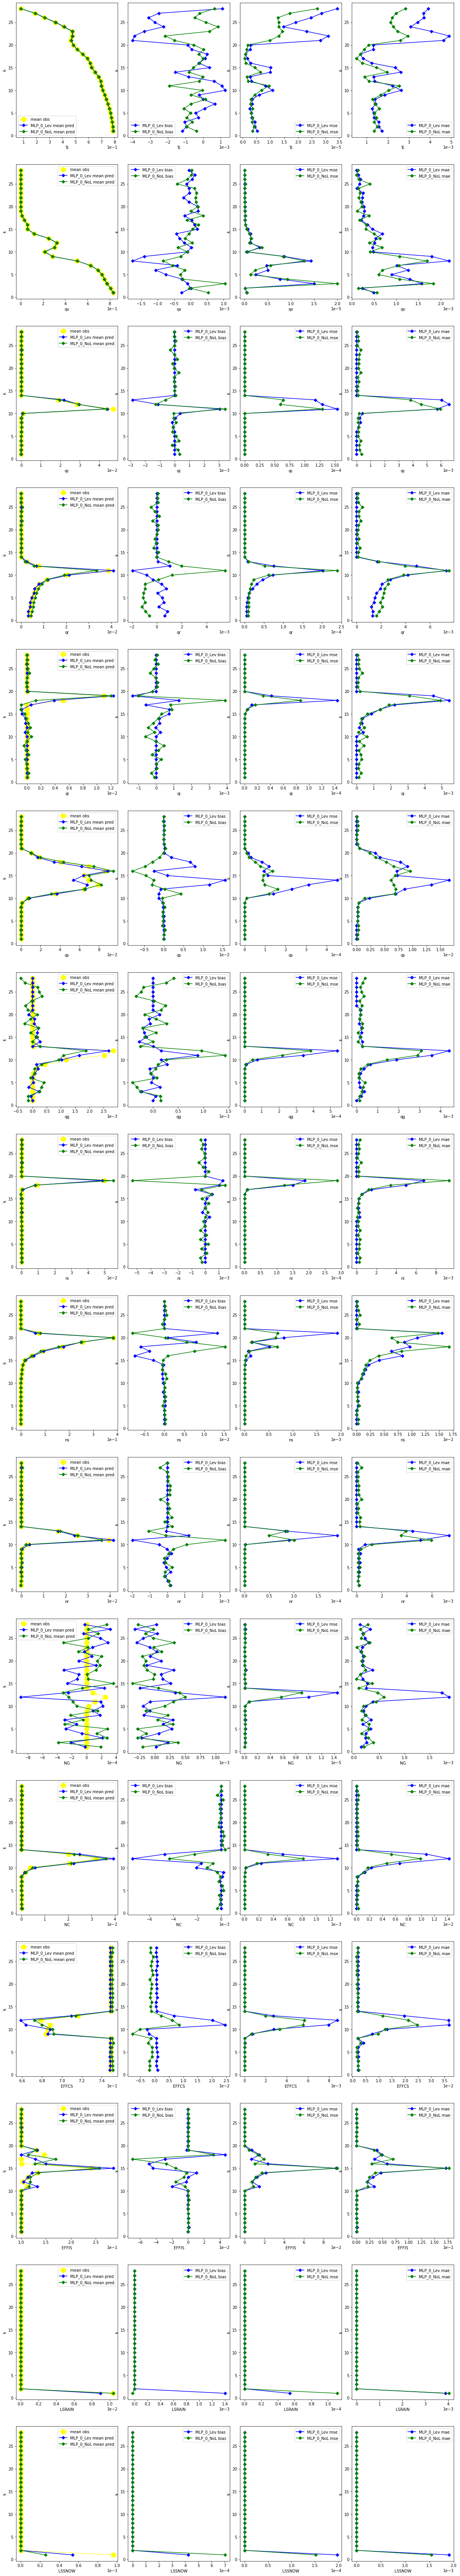

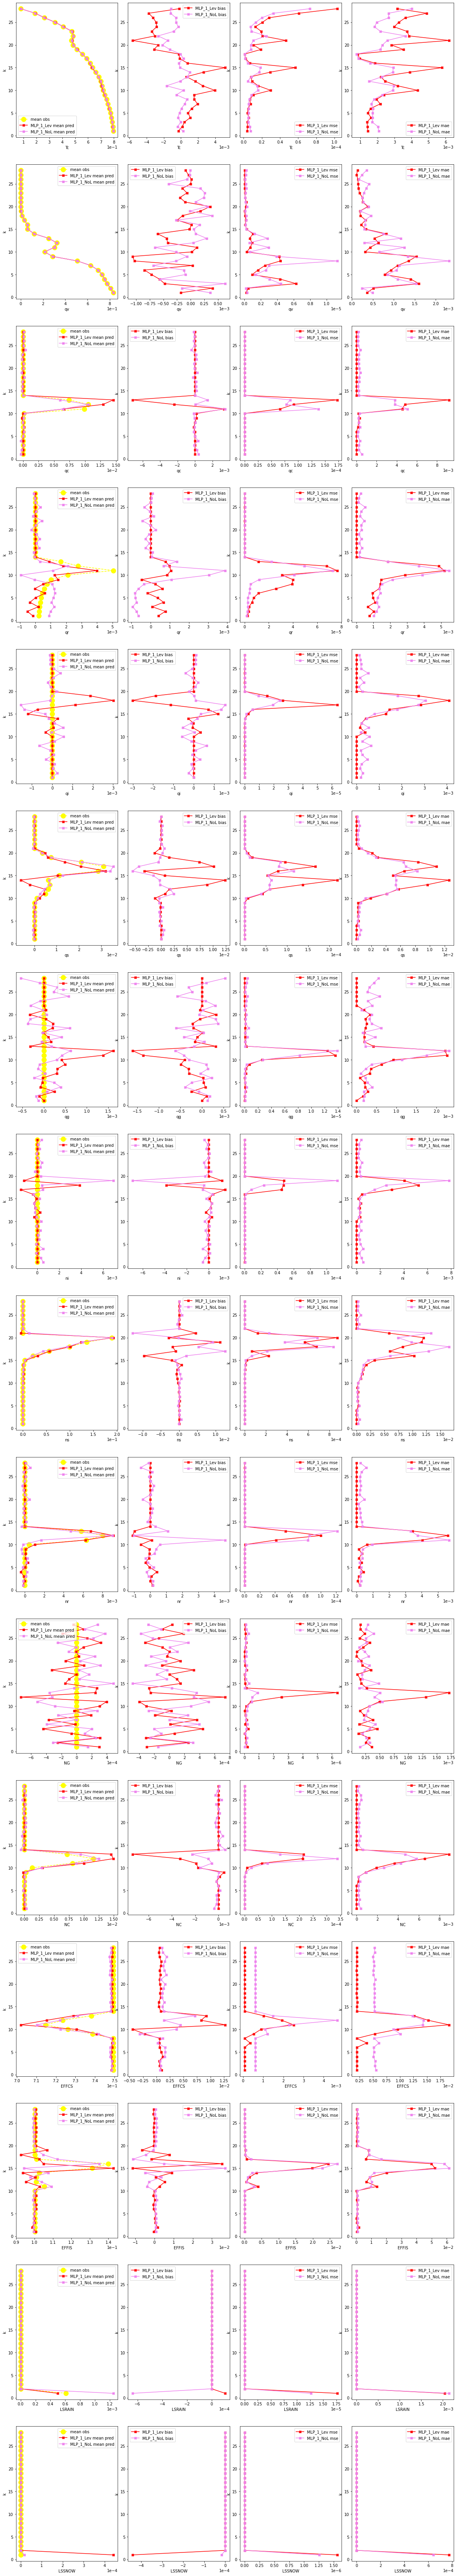

In [ ]:
def generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, arr_labels, plot_sci_numbers=True):
  for test, mark, color, label in zip(arr_test, arr_markers, arr_colors, arr_labels):
    path = '{}/{}/{}'.format(exp1_dir, test, skill_fname)  
    df_skill = pd.read_csv(path)
    skill_values = df_skill[key].values
    plt.plot(skill_values, range(1, len(skill_values)+1), label=label + ' ' + skill, marker=mark, color=color)
  if plot_sci_numbers:
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
  plt.legend()


def generate_subplot(ncols, nskills, idx_plot, key):
  plt.subplot(ncols, nskills, idx_plot)
  plt.ylabel("k")
  plt.xlabel(key)


def generate_all_graphics(arr_test, cols, obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, arr_labels, plot_sci_numbers=True):
  idx_plot = 1
  plt.figure(figsize=(20, 120))
  for key in cols:
      if key == 'Unnamed: 0': 
        continue
      generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)

      mean_obs_path = '{}/{}/{}'.format(exp1_dir, arr_test[0], obs_file_name)
      df_mean_obs = pd.read_csv(mean_obs_path)
      obs_values = df_mean_obs[key].values
      plt.plot(obs_values, range(1, len(obs_values)+1), label='mean obs',  marker='o', linestyle='dashed', color='yellow', markersize=12)
      
      generate_skill_graphic('mean pred', pred_file_name, key, arr_test, arr_markers, arr_colors, arr_labels, plot_sci_numbers)
      idx_plot += 1

      for skill, skill_fname in zip(arr_skills, arr_skill_filenames):
        generate_subplot(len(cols)-1, len(arr_skills)+1, idx_plot, key)
        generate_skill_graphic(skill, skill_fname, key, arr_test, arr_markers, arr_colors, arr_labels, plot_sci_numbers)
        idx_plot += 1
  
  plt.subplots_adjust(hspace=0.2, wspace=0.1)
  plt.show()



# exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs_models_rttmg_dt60'
exp1_dir = '/content/drive/My Drive/Colab Notebooks/logs'
# exp1_dir = tb_logdir_base

arr_test = [ 'MLP_0_Lev_[432, 432, 432, 432]_relu_bat128', 'MLP_0_NoL_[432, 432, 432, 432]_relu_bat128']
arr_markers = ['D', 'D']
arr_colors = ['blue', 'green']
arr_labels = [ 'MLP_0_Lev', 'MLP_0_NoL']
dummy_path = '{}/{}/{}'.format(exp1_dir, 'MLP_0_Lev_[432, 432, 432, 432]_relu_bat128', 'log_mean_obs.csv')
dummy_df = pd.read_csv(dummy_path)
arr_skills = ['bias', 'mse', 'mae']
obs_file_name = 'log_mean_obs.csv'
pred_file_name = 'log_mean_pred.csv'
arr_skill_filenames = ['log_bias.csv', 'log_mse.csv', 'log_mae.csv']
generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, arr_labels)


arr_test = [ 'MLP_1_Lev_[432, 432, 432, 432]_relu_bat128','MLP_1_NoL_[432, 432, 432, 432]_relu_bat128' ]
arr_markers = ['X', 'X']
arr_colors = ['red', 'violet']
arr_labels = [ 'MLP_1_Lev', 'MLP_1_NoL']
dummy_path = '{}/{}/{}'.format(exp1_dir, 'MLP_0_Lev_[432, 432, 432, 432]_relu_bat128', 'log_mean_obs.csv')
dummy_df = pd.read_csv(dummy_path)
arr_skills = ['bias', 'mse', 'mae']
obs_file_name = 'log_mean_obs.csv'
pred_file_name = 'log_mean_pred.csv'
arr_skill_filenames = ['log_bias.csv', 'log_mse.csv', 'log_mae.csv']
generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors, arr_labels)


In [ ]:
arr_test = [ 'teste_D.6']
arr_markers = ['D']
arr_colors = ['blue']
generate_all_graphics(arr_test, dummy_df.columns.to_list(), obs_file_name, pred_file_name, arr_skills, arr_skill_filenames, arr_markers, arr_colors)

NameError: ignored